# Long Notebook TDT4173 Project

Kaggle Team Name: `Tay 2.0`

Group Number (Blackboard): `081`

Team Members:
- `560944 - Sondre Kolberg`
- `546179 - Oscar Timm Marcussen`
- `561803 - Magnus Eivindson Byrkjeland`


# Initialization
Initial loading of libraries and data.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import seaborn as sns
from scipy import stats

%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')

# 1. Exploratory Data Analysis (EDA)


## 1.1 Domain Knowledge

Solar panel efficiency is affected by a lot of factors. Therefore, predicting solar energy production for the next day is really tricky. However, it boils down to how much sunlight reach the photovotiac cells on the panels.

1. **Sunlight**: Solar panels require sunlight to generate electricity. More sunlight translates to more power production. Hence, clear, sunny days are ideal for maximum efficiency.

2. **Clouds**: Cloud cover can reduce the efficiency of solar panels. While they can still generate electricity on cloudy days, the output is lower compared to sunny conditions.

3. **Solar Radiation**: Solar panels convert solar radiation into electricity. The intensity of solar radiation affects their efficiency. Regions closer to the equator, receiving higher solar radiation, generally see better solar panel performance. 

4. **Snow/Dust**: Accumulation of snow or dust on solar panels can block sunlight, reducing their efficiency. Snow generally melts or slides off due to the panels' angle. Thin covers of snow may actually help energy production as it acts as a "mirror" reflecting back light onto the panel.

5. **Temperature**: Solar panels are more efficient in cooler temperatures. High temperatures can reduce the efficiency of solar panels. As the temperature increases, the electrical output decreases due to the increase in resistance.

Overall, the ideal conditions for solar panel efficiency are clear, sunny days with moderate temperatures, and no obstruction from snow or dust on the panels.

[https://www.energy.gov/eere/solar/solar-performance-and-efficiency](https://www.energy.gov/eere/solar/solar-performance-and-efficiency)<br />
[https://www.sisolarco.com/effects-weather-solar-panels-production/](https://www.sisolarco.com/effects-weather-solar-panels-production/)


### The features

After investigating the features we noticed that some features were cummulative. After reading about the features on meteomatics we concluded that there were three different types of featuress.
- Instantanious features, example: `direct_rad`. A feature of this kind would tell us the value at the exact time of date_forecast
- Cummulative features, example `direct_rad_energy_1h`. These features included a timeinterval which told us in what period it was measured. for example a value at 15:00 for `direct_rad_energy_1h:J` told us that the total energy from the sun in the period 14:00-15:00
- Lastly some features were neither stated as cummulative or instantanious, we assumed these to be cummulative of the last 15 minutes



## 1.2 Understand how the data was generated


### Observed
The observed datasets contains values logged from measurements from sensors from three different locations. These sensors are subject for a lot of noise, and the data is not always reliable as they may contain NaN values and wierd/wrong measurements. 

### Estimated
The estimated datasets are generated in controlled environments, and looks to be cleaner with less noise and missing values. However, the estimations themselves are not reliable as they are not actual measurements.

### Target Data
Exploring the target data, it is obvious that the pv_measurements is affected by the season. What stood out to us was that dataset B contained som wierd intervals with constant values. It doesn't seem reasonable that the pv_measurements would be constant for long periods of time, so we decided to look into this further.

As the broken intervals streches over thousands of lines of data, we wanted to try to impute the measurements in order to keep as much data as we could. To begin we tried exchanging values from the same intervals in C as we initally throught the data looked to be quite similar. The scale of the data looked good - unfortunately the model performed worse when we did this. We continued by removing the biggest broken intervals from B, and exchanging measurements from C on the shorter intervals. In the end we decided to remove all the broken intervals from B. It gave us the best results.

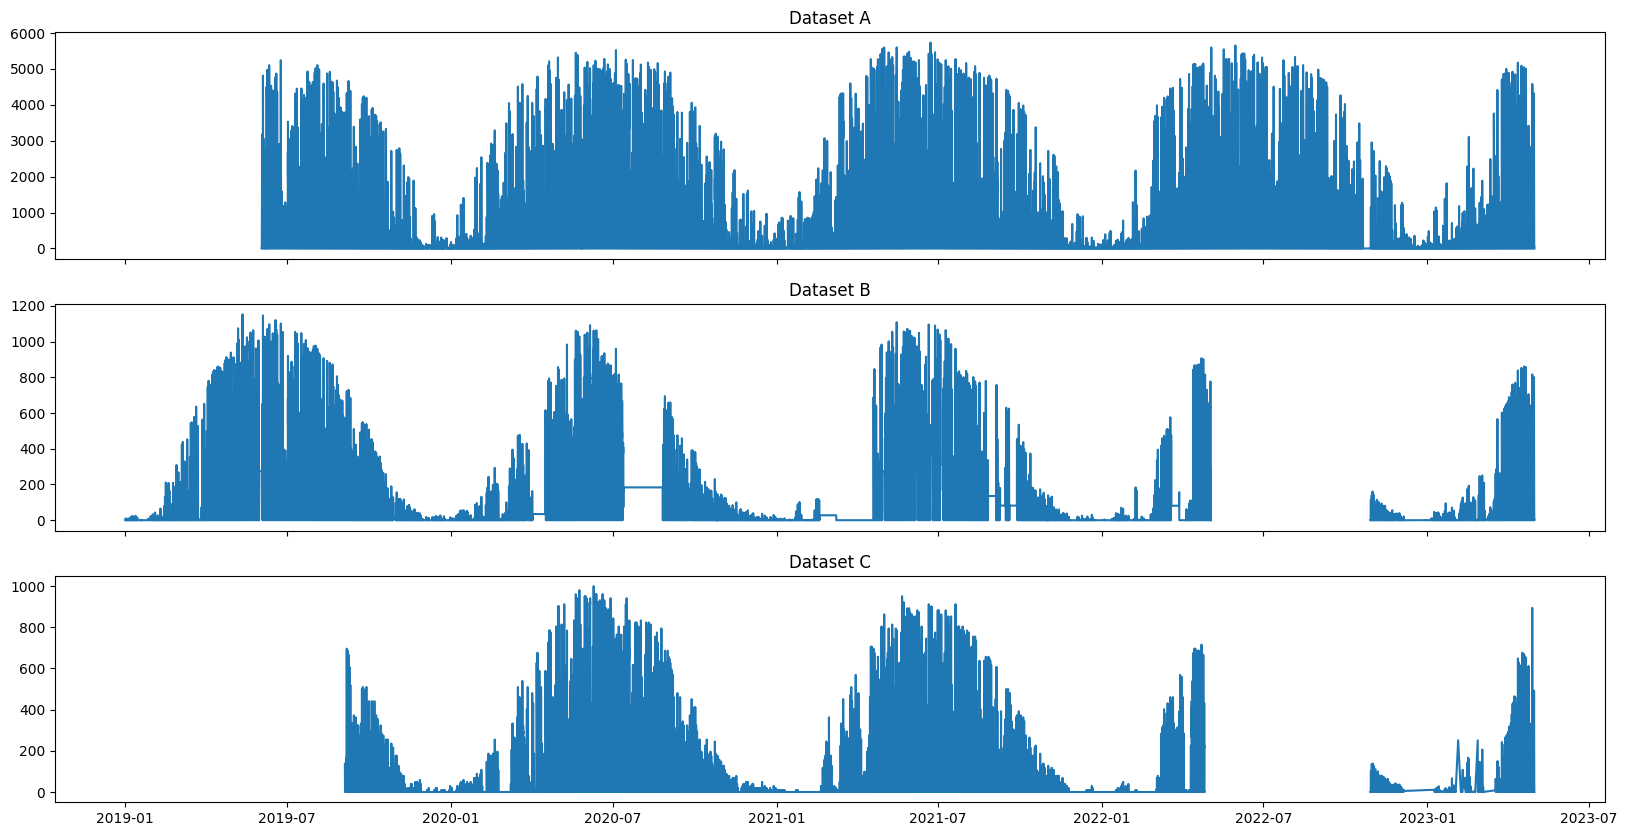

In [2]:
fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
axs[0].plot(train_a['time'], train_a['pv_measurement'])
axs[0].set_title('Dataset A')
axs[1].plot(train_b['time'], train_b['pv_measurement'])
axs[1].set_title('Dataset B')
axs[2].plot(train_c['time'], train_c['pv_measurement'])
axs[2].set_title('Dataset C')
plt.show()

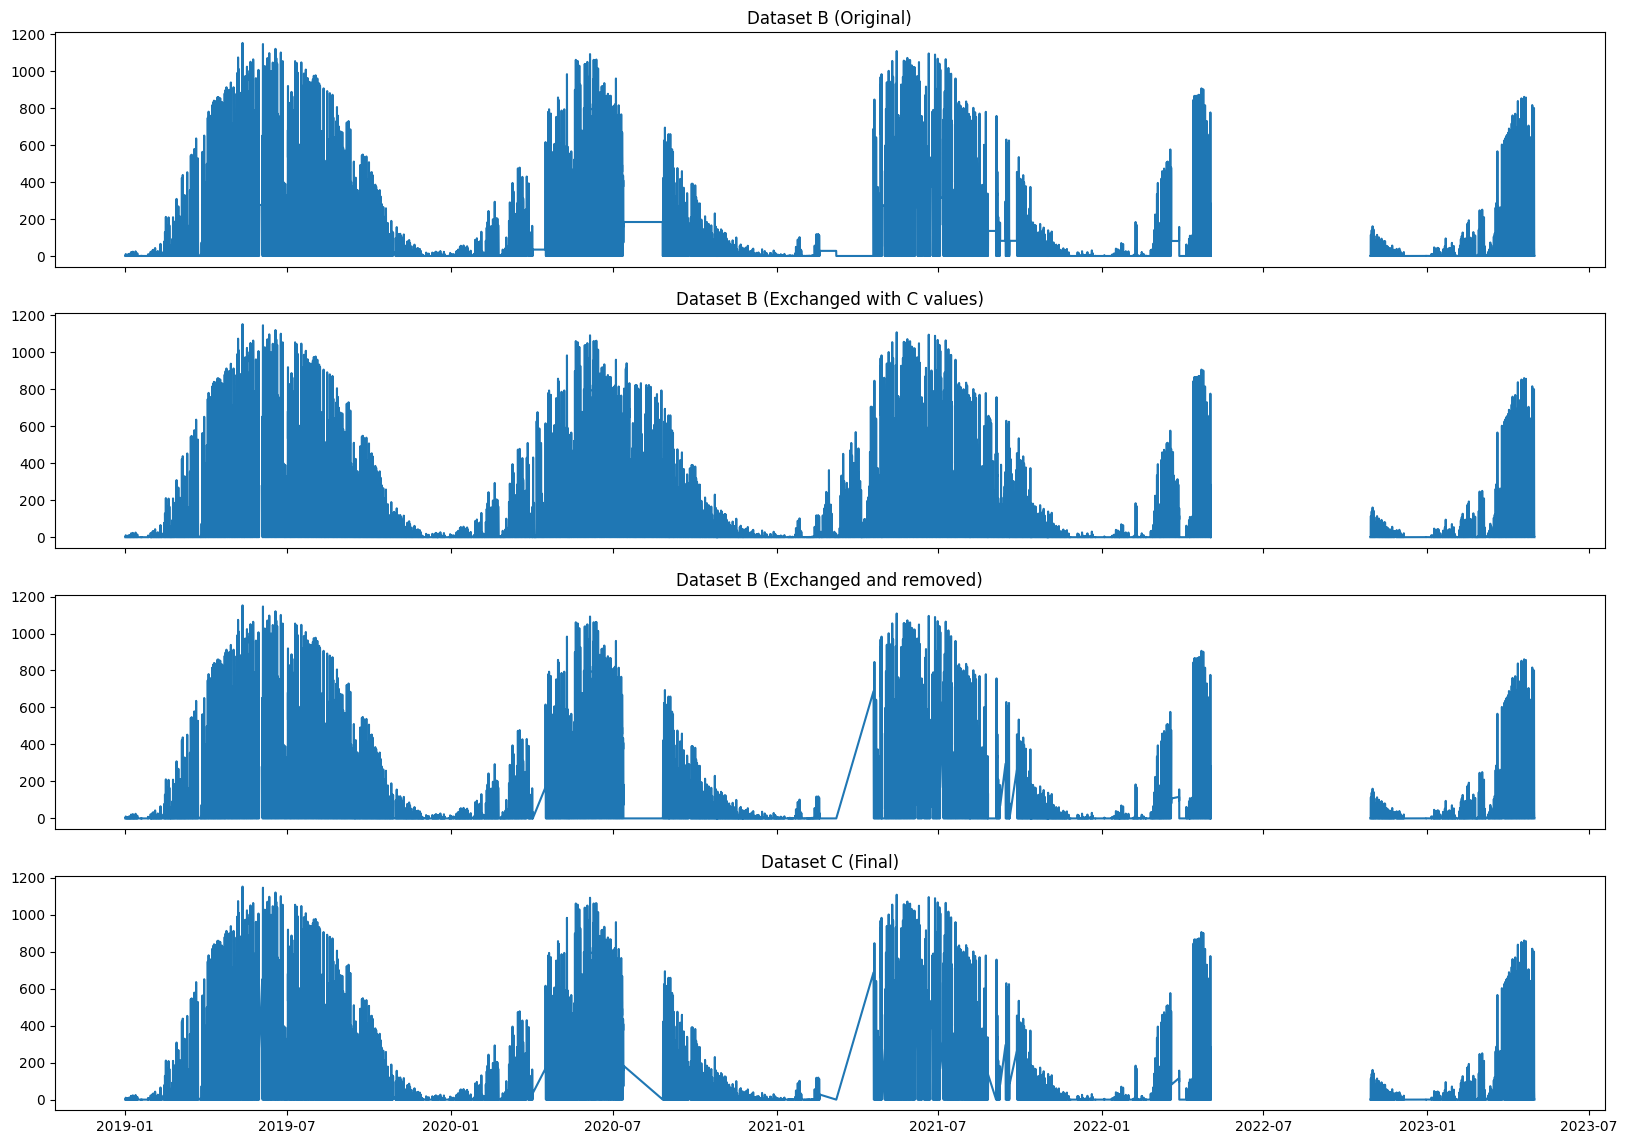

In [3]:
# Exchanged
data_B = train_b.copy()
data_B['diff'] = data_B['pv_measurement'].diff()

# Identify intervals where the difference is zero and the measurement is not 0.0
constant_intervals_B = data_B[(data_B['diff'] == 0) & (data_B['pv_measurement'] != 0) & (data_B['pv_measurement'].notna())]

# Group these intervals and count their lengths
grouped_intervals_B = (constant_intervals_B
                       .assign(group=(constant_intervals_B['time'].diff() != pd.Timedelta(hours=1)).cumsum())
                       .groupby('group')
                       .agg(start_time=('time', 'first'), end_time=('time', 'last'), count=('time', 'count'), constant_value=('pv_measurement', 'first'))
                       .reset_index(drop=True))

# Filter out short intervals (e.g., less than 3 hours) as they might not be considered "broken"
long_constant_intervals_B = grouped_intervals_B[grouped_intervals_B['count'] >= 3]

def replace_with_values_from_C(data_B, data_C, constant_intervals):
    data_B_copy = data_B.copy()
    """
    Replace values in dataset B's constant intervals with corresponding values from dataset C.

    :param data_B: DataFrame for dataset B.
    :param data_C: DataFrame for dataset C.
    :param constant_intervals: DataFrame with constant intervals in B to be replaced.
    :return: Modified dataset B with values replaced from C.
    """
    for index, row in constant_intervals.iterrows():
        start_time, end_time = row['start_time'], row['end_time']

        # Iterate through each timestamp within the interval
        for time in pd.date_range(start=start_time, end=end_time, freq='H'):
            # Check if there's a corresponding timestamp in C
            if time in data_C['time'].values:
                # Replace the value in B with the value from C
                value_C = data_C.loc[data_C['time'] == time, 'pv_measurement'].values[0]
                data_B_copy.loc[data_B_copy['time'] == time, 'pv_measurement'] = value_C

    # Replace the constant 0.0 values from line 19140 to 20143 in dataset B with the values from the same timestamp in dataset C.

    # Iterate through each timestamp within the interval
    for time in pd.date_range(start='2021-03-08 15:00:00', end='2021-04-19 11:00:00', freq='H'):
        # Check if there's a corresponding timestamp in C
        if time in data_C['time'].values:
            # Replace the value in B with the value from C
            value_C = data_C.loc[data_C['time'] == time, 'pv_measurement'].values[0]
            data_B_copy.loc[data_B_copy['time'] == time, 'pv_measurement'] = value_C


    return data_B_copy

# Replace values in dataset B using dataset C for the identified constant intervals
train_B_modified = replace_with_values_from_C(data_B, train_c, long_constant_intervals_B)



# Modified and removed
train_b_cleaned = train_b.copy()
train_b_cleaned = pd.concat([train_b_cleaned[:19140], train_b_cleaned[20142:]])
train_b_cleaned["rolling"] = train_b_cleaned["pv_measurement"].rolling(4).mean()
train_b_cleaned["keep"] = train_b_cleaned["pv_measurement"] - train_b_cleaned["rolling"] != 0 + train_b_cleaned["pv_measurement"].apply(lambda a: a==0)
train_b_cleaned = train_b_cleaned[train_b_cleaned["keep"]]
train_b_cleaned = train_b_cleaned.iloc[:,:3]

# Replace values in dataset B using dataset C for the identified constant intervals

train_b_modified_cleaned = replace_with_values_from_C(train_b_cleaned, train_c, long_constant_intervals_B)






# Removed
train_b_cleaned = train_b.copy()
train_b_cleaned = pd.concat([train_b_cleaned[:19140], train_b_cleaned[20142:]])
train_b_cleaned["rolling"] = train_b_cleaned["pv_measurement"].rolling(4).mean()
train_b_cleaned["keep"] = train_b_cleaned["pv_measurement"] - train_b_cleaned["rolling"] != 0 + train_b_cleaned["pv_measurement"].apply(lambda a: a==0)
train_b_cleaned = train_b_cleaned[train_b_cleaned["keep"]]
train_b_cleaned = train_b_cleaned.iloc[:,:3]

fig, axs = plt.subplots(4, 1, figsize=(20, 14), sharex=True)
axs[0].plot(train_b['time'], train_b['pv_measurement'])
axs[0].set_title('Dataset B (Original)')
axs[1].plot(train_B_modified['time'], train_B_modified['pv_measurement'])
axs[1].set_title('Dataset B (Exchanged with C values)')
axs[2].plot(train_b_modified_cleaned['time'], train_b_modified_cleaned['pv_measurement'])
axs[2].set_title('Dataset B (Exchanged and removed)')
axs[3].plot(train_b_cleaned['time'], train_b_cleaned['pv_measurement'])
axs[3].set_title('Dataset C (Final)')
plt.show()



## 1.3 Explore individual features & cleaning
By taking a quick look at each of the features, some are cyclical.

- **sun_elevation*: 
- *clear_sky_rad:W*

### Feature information

### Plotting features of interest to see how they look during our time period

In [4]:
# features = X_test_estimated_a.columns.drop(['date_forecast', 'date_calc']).tolist()
# print(features)

# for feature in features:
#     fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
#     feature_name = feature
#     X_train_observed_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test A', color='red')
#     X_train_estimated_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test A', color='blue')
#     X_test_estimated_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test  A', color='green')

#     X_train_observed_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='red')
#     X_train_estimated_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='blue')
#     X_test_estimated_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='green')

#     X_train_observed_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='red')
#     X_train_estimated_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='blue')
#     X_test_estimated_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='green')

### Ceiling Height & Cloud Base
While exploring ceiling height, we were wondering why the measurements became so radically different after early 2020. After digging into the data, we realized the measurements must have changed from meters to feet. We decided to convert the measurements that were done in meters to to feet and plotted the data again. The feature name remained unchanged as it would cause problems later in the notebook. 

Cloud base also had the same issue, however, this feature is dropped.

<Axes: title={'center': 'Train/Test C (Converted)'}, xlabel='date_forecast'>

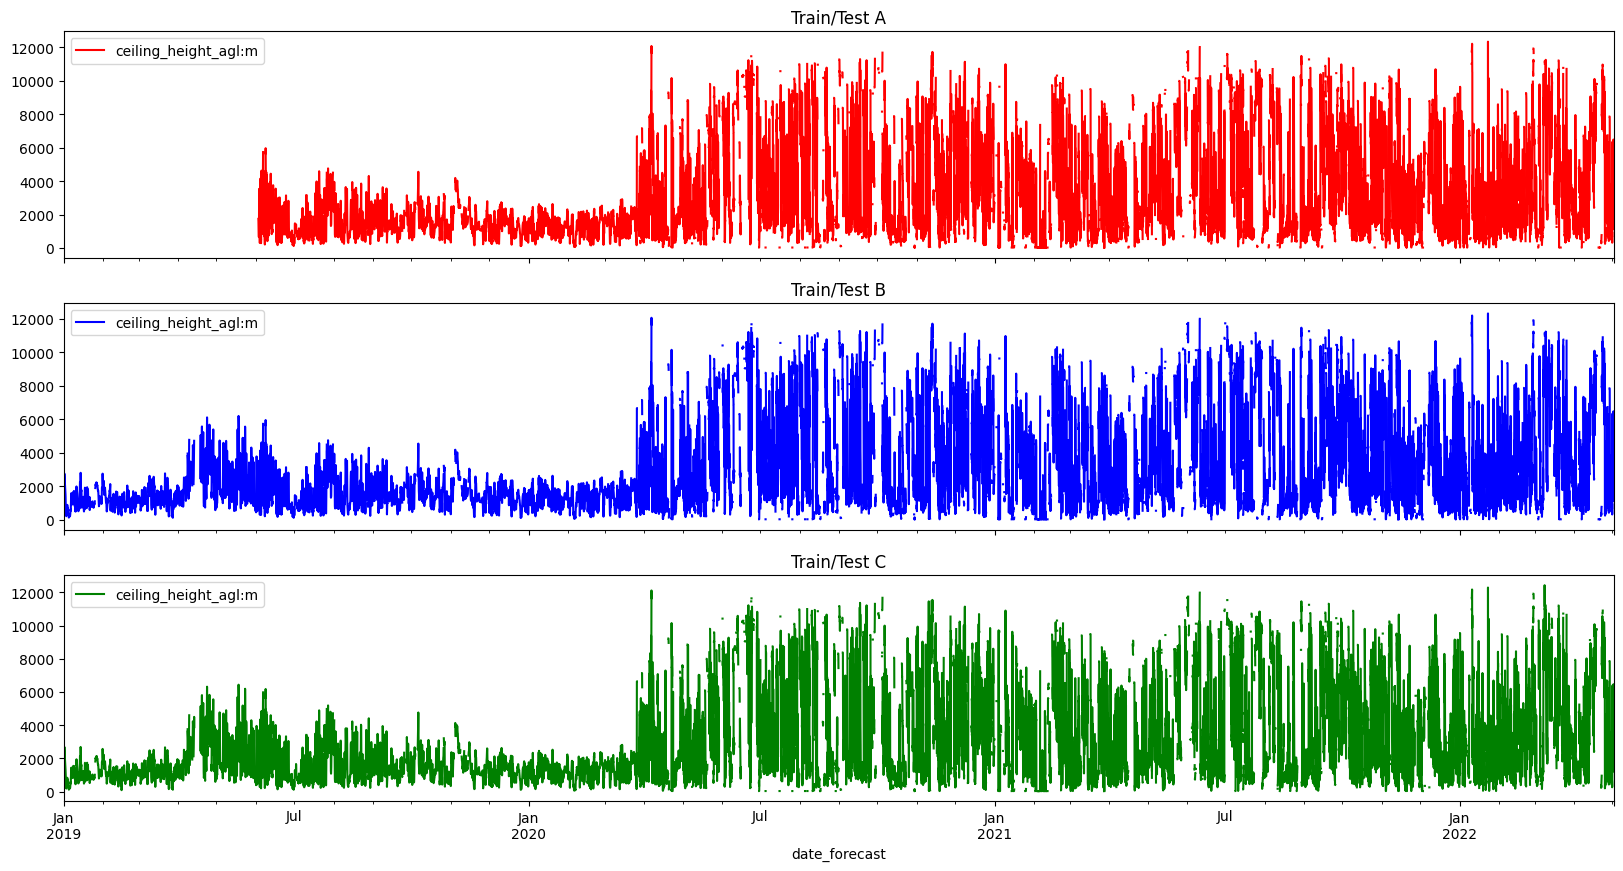

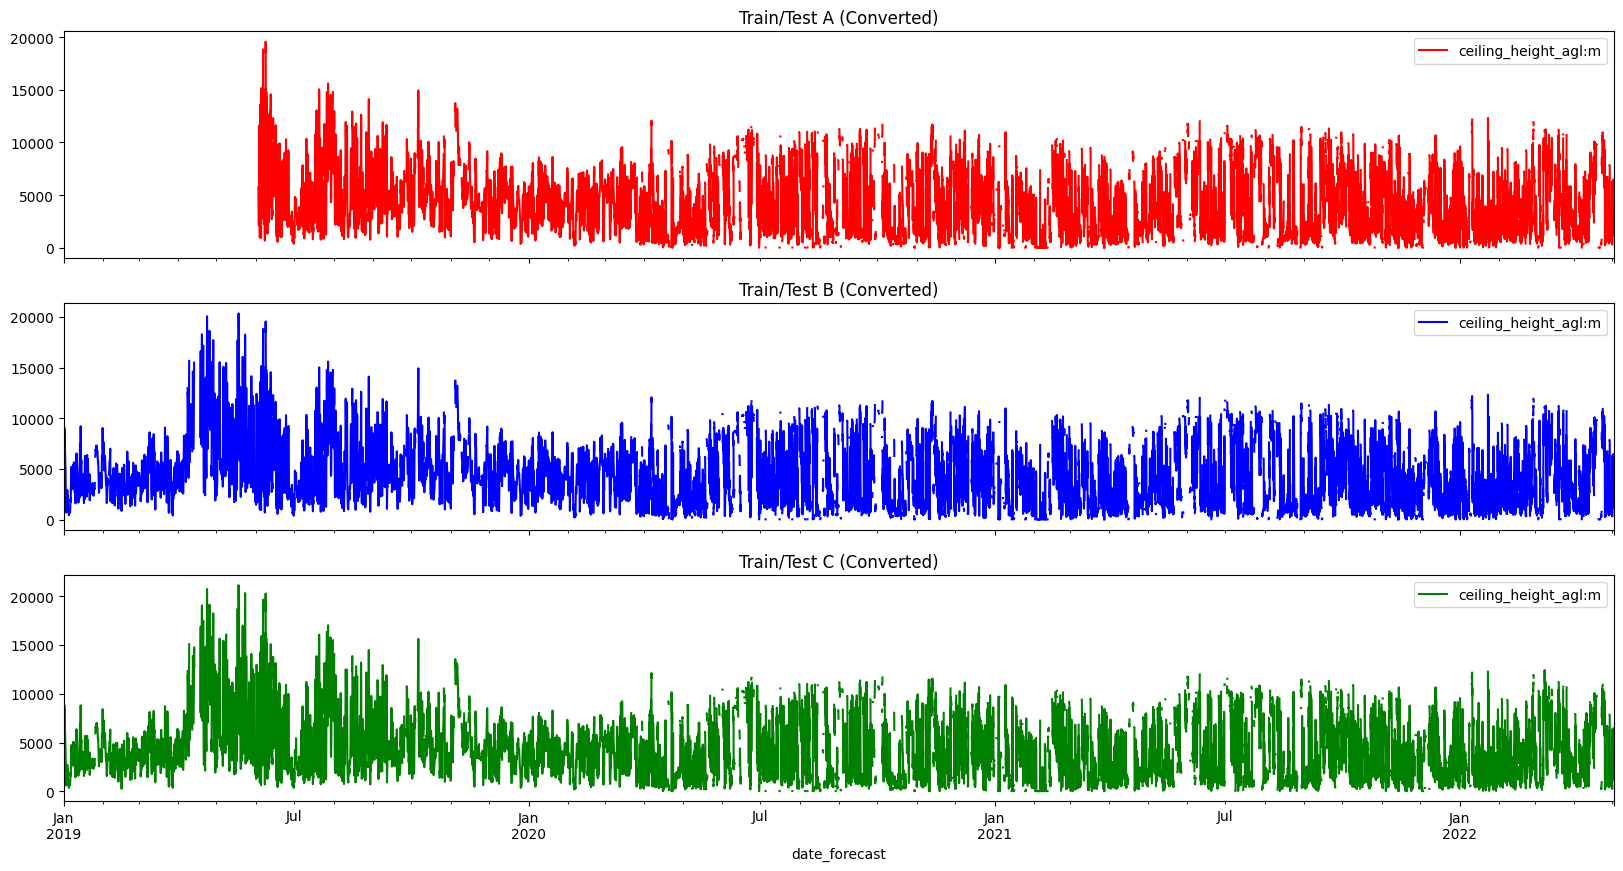

In [5]:
fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
feature_name = 'ceiling_height_agl:m'

X_train_observed_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test A', color='red')
X_train_observed_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test B', color='blue')
X_train_observed_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test C', color='green')

mask_a = X_train_observed_a['date_forecast'] < '2020-03-26'
mask_b = X_train_observed_b['date_forecast'] < '2020-03-26'
mask_c = X_train_observed_c['date_forecast'] < '2020-03-26'

# Apply the conversion from meters to feet (1 meter = 3.28084 feet)
conversion_factor = 3.28084

X_train_observed_a.loc[mask_a, 'ceiling_height_agl:m'] *= conversion_factor
X_train_observed_b.loc[mask_b, 'ceiling_height_agl:m'] *= conversion_factor
X_train_observed_c.loc[mask_c, 'ceiling_height_agl:m'] *= conversion_factor

fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
feature_name = 'ceiling_height_agl:m'

X_train_observed_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test A (Converted)', color='red')
X_train_observed_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test B (Converted)', color='blue')
X_train_observed_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test C (Converted)', color='green')

### Elevation
"elevation:m" indicates the height of where the measurement was taken. Looking at the graph below, it is clear that this value is constant, which makes sense as the measurement was taken at the same place.

Given the low variation in elevation between the three datasets, the feature doesn't contribute much to the model. However, removing it from the final model did not improve the performance, so we decided to keep it.

<Axes: title={'center': 'Train/Test C '}, xlabel='date_forecast'>

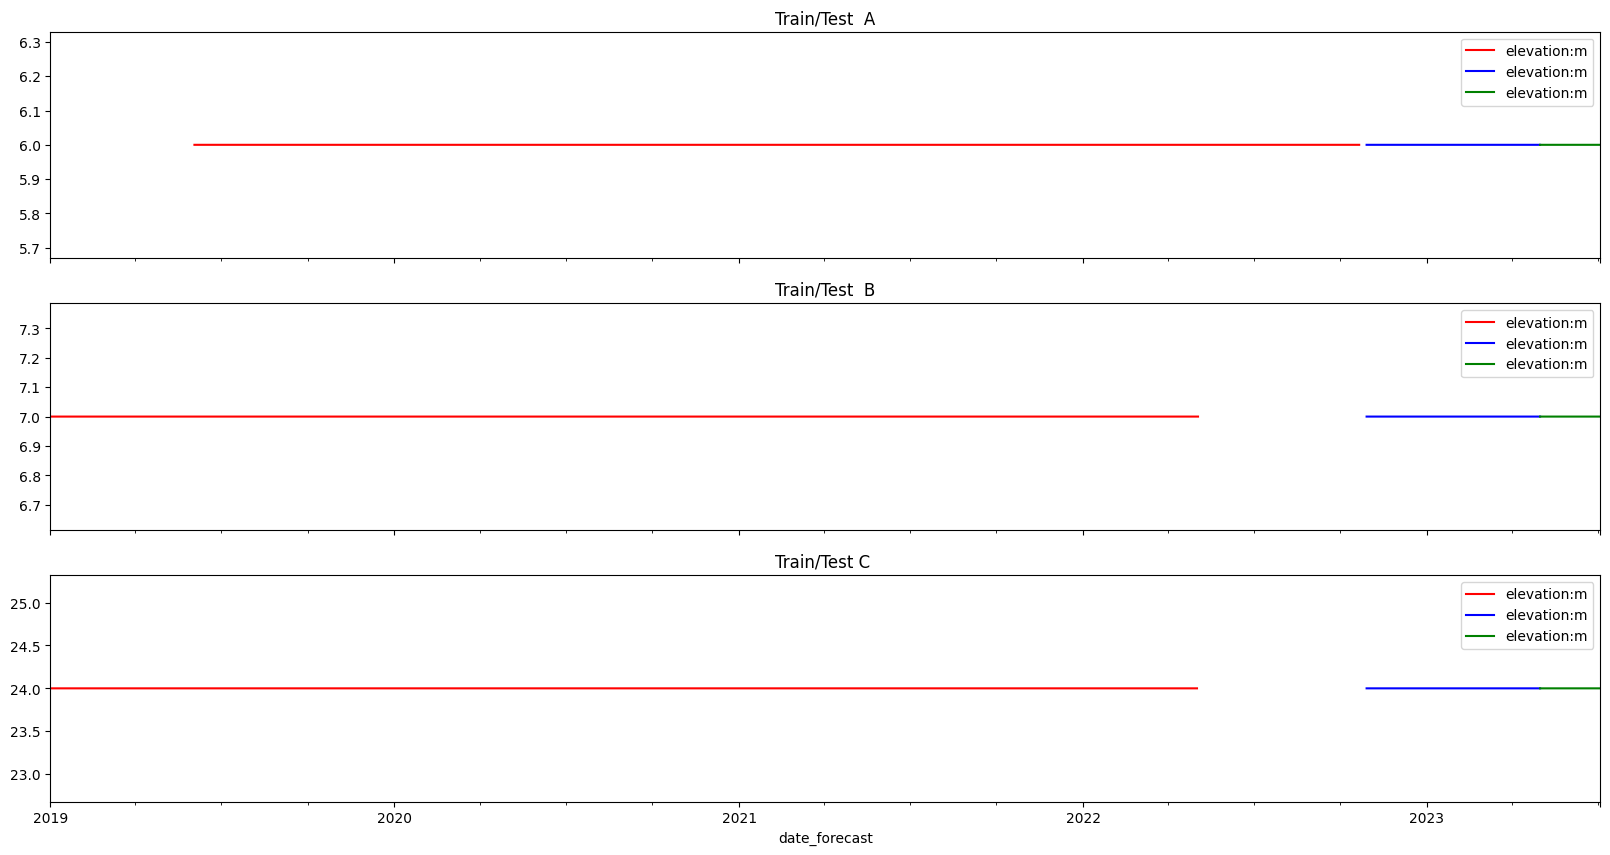

In [6]:
fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
feature_name = 'elevation:m'
X_train_observed_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test A', color='red')
X_train_estimated_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test A', color='blue')
X_test_estimated_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test  A', color='green')

X_train_observed_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='red')
X_train_estimated_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='blue')
X_test_estimated_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='green')

X_train_observed_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='red')
X_train_estimated_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='blue')
X_test_estimated_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test C ', color = 'green')

### Snow density
**snow_density:kgm3** has a lot of NaN values and we have to fix this

Note: The code doesn't work in the code snippet below, but is used in the second correlation matrix.

In [7]:
# X["snow_density:kgm3"] = X["snow_density:kgm3"].apply(
#     lambda a : np.isnan(a)
#     ).map({True: 0, False: 1})

### Outliers
In one of our sessions we went deep into the data to discover outliers or any other interesting patterns.

In [8]:
y_a = pd.read_parquet('A/train_targets.parquet')
y_b = pd.read_parquet('B/train_targets.parquet')
y_c = pd.read_parquet('C/train_targets.parquet')

X_est_a = pd.read_parquet('A/X_train_estimated.parquet')
X_est_b = pd.read_parquet('B/X_train_estimated.parquet')
X_est_c = pd.read_parquet('C/X_train_estimated.parquet')

X_obs_a = pd.read_parquet('A/X_train_observed.parquet')
X_obs_b = pd.read_parquet('B/X_train_observed.parquet')
X_obs_c = pd.read_parquet('C/X_train_observed.parquet')

X_obs_a.head()

date_forecast  absolute_humidity_2m:gm3  air_density_2m:kgm3  \
0 2019-06-02 22:00:00                       7.7                1.230   
1 2019-06-02 22:15:00                       7.7                1.229   
2 2019-06-02 22:30:00                       7.7                1.228   
3 2019-06-02 22:45:00                       7.7                1.226   
4 2019-06-02 23:00:00                       7.7                1.225   

   ceiling_height_agl:m  clear_sky_energy_1h:J  clear_sky_rad:W  \
0           1744.900024                    0.0              0.0   
1           1734.000000                    0.0              0.0   
2           1723.500000                    0.0              0.0   
3           1713.400024                    0.0              0.0   
4           1703.599976                    0.0              0.0   

   cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  diffuse_rad:W  \
0       1744.900024              0.0      280.299988            0.0   
1       1734.000000              0.0      280.299988            0.0   
2       1723.500000              0.0      280.299988            0.0   
3       1713.400024              0.0      280.299988            0.0   
4       1703.599976              0.0      280.299988            0.0   

   diffuse_rad_1h:J  direct_rad:W  direct_rad_1h:J  effective_cloud_cover:p  \
0               0.0           0.0              0.0                98.699997   
1               0.0           0.0              0.0                99.000000   
2               0.0           0.0              0.0                99.199997   
3               0.0           0.0              0.0                99.400002   
4               0.0           0.0              0.0                99.599998   

   elevation:m  fresh_snow_12h:cm  fresh_snow_1h:cm  fresh_snow_24h:cm  \
0          6.0                0.0               0.0                0.0   
1          6.0                0.0               0.0                0.0   
2          6.0                0.0               0.0                0.0   
3          6.0                0.0               0.0                0.0   
4          6.0                0.0               0.0                0.0   

   fresh_snow_3h:cm  fresh_snow_6h:cm  is_day:idx  is_in_shadow:idx  \
0               0.0               0.0         0.0               1.0   
1               0.0               0.0         0.0               1.0   
2               0.0               0.0         0.0               1.0   
3               0.0               0.0         0.0               1.0   
4               0.0               0.0         0.0               1.0   

   msl_pressure:hPa  precip_5min:mm  precip_type_5min:idx  pressure_100m:hPa  \
0       1006.799988             0.0                   0.0         994.200012   
1       1006.500000             0.0                   0.0         993.900024   
2       1006.099976             0.0                   0.0         993.599976   
3       1005.799988             0.0                   0.0         993.299988   
4       1005.500000             0.0                   0.0         993.000000   

   pressure_50m:hPa  prob_rime:p  rain_water:kgm2  \
0       1000.299988          0.0              0.0   
1        999.900024          0.0              0.0   
2        999.599976          0.0              0.0   
3        999.299988          0.0              0.0   
4        999.000000          0.0              0.0   

   relative_humidity_1000hPa:p  sfc_pressure:hPa  snow_density:kgm3  \
0                    73.099998       1006.299988                NaN   
1                    72.199997       1006.000000                NaN   
2                    71.199997       1005.599976                NaN   
3                    70.199997       1005.299988                NaN   
4                    69.199997       1005.000000                NaN   

   snow_depth:cm  snow_drift:idx  snow_melt_10min:mm  snow_water:kgm2  \
0            0.0             0.0                -0.0              0.1   
1            0.0         

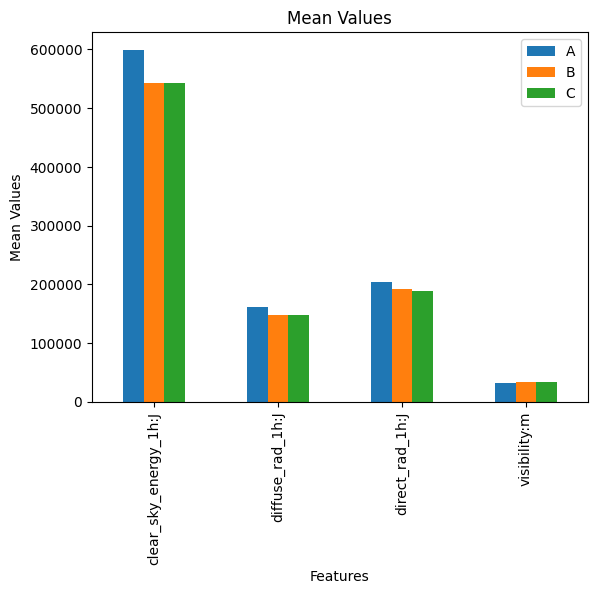

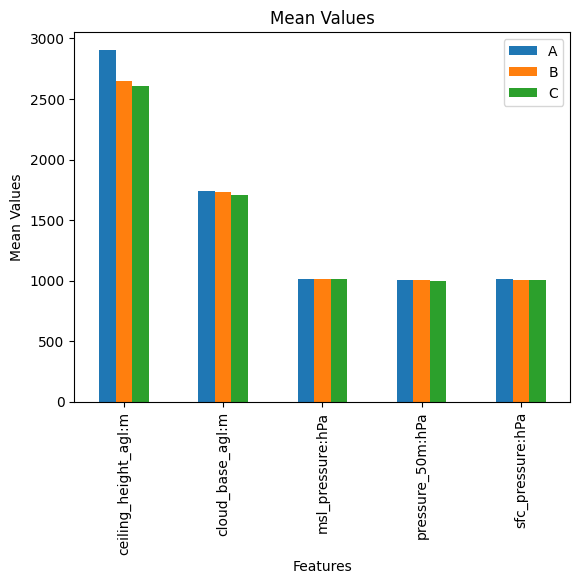

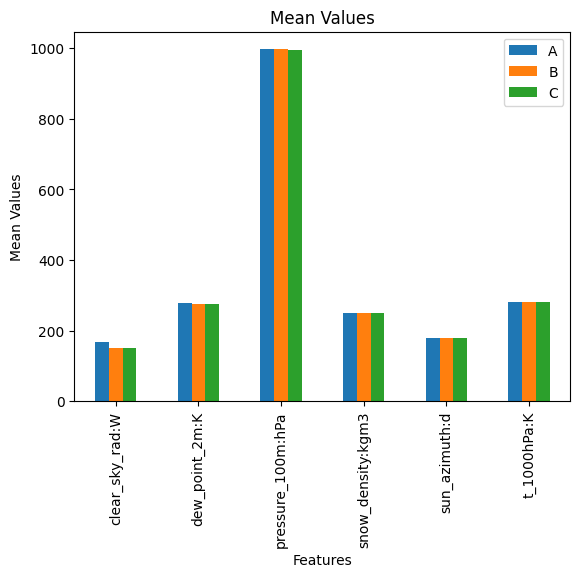

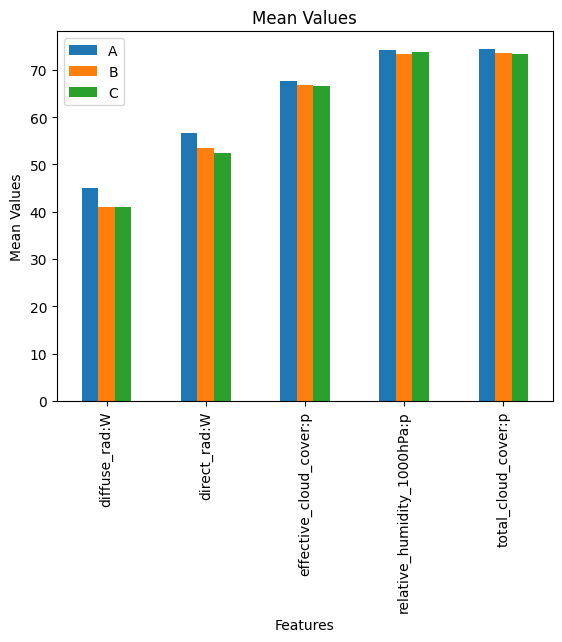

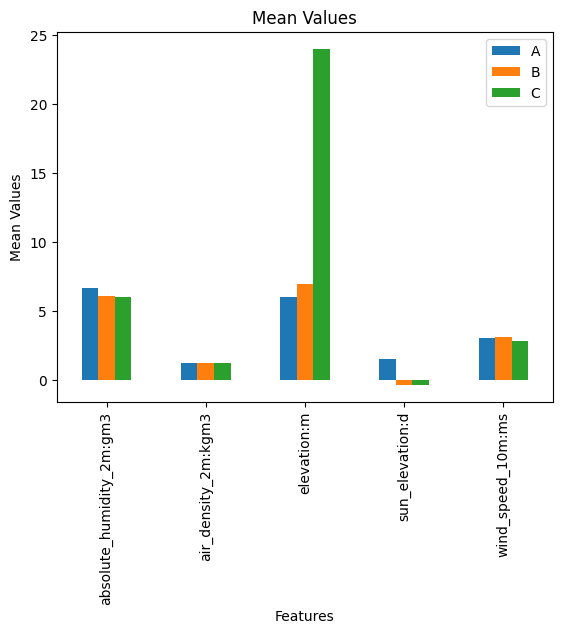

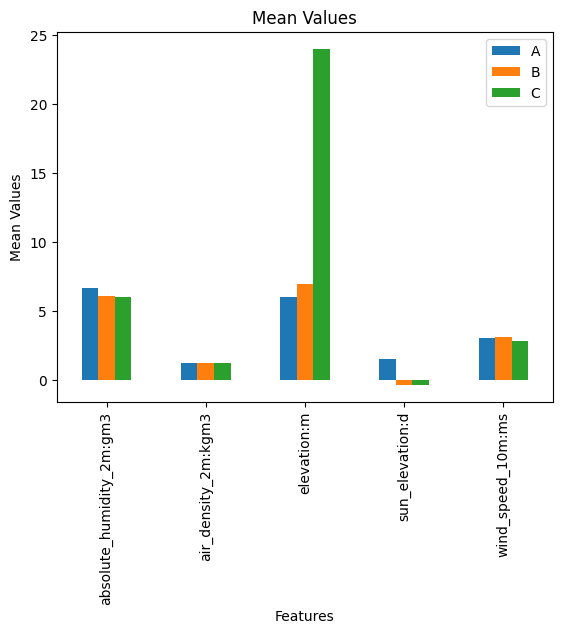

In [9]:
mean_a = X_obs_a.drop('date_forecast', axis=1).mean()
mean_b = X_obs_b.drop('date_forecast', axis=1).mean()
mean_c = X_obs_c.drop('date_forecast', axis=1).mean()

huge_indices = mean_a[mean_a > 10000].index
large_indices = mean_a[(mean_a > 1000) & (mean_a <= 10000)].index
medium_indices = mean_a[(mean_a > 100) & (mean_a <= 1000)].index
small_indices = mean_a[(mean_a > 10) & (mean_a <= 100)].index
tiny_indices = mean_a[(mean_a > 1) & (mean_a <= 10)].index
tiniest_indices = mean_a[(mean_a <= 1)].index

def display_mean_values(indices, mean_a, mean_b, mean_c):
    mean_data = {
        'A': mean_a[indices],
        'B': mean_b[indices],
        'C': mean_c[indices]
    }

    # Create a dataframe from the mean data
    mean_df = pd.DataFrame(mean_data)

    # Plot the mean values
    mean_df.plot(kind='bar')
    plt.xlabel('Features')
    plt.ylabel('Mean Values')
    plt.title('Mean Values')
    plt.show()

display_mean_values(huge_indices, mean_a, mean_b, mean_c)

display_mean_values(large_indices, mean_a, mean_b, mean_c)

display_mean_values(medium_indices, mean_a, mean_b, mean_c)

display_mean_values(small_indices, mean_a, mean_b, mean_c)

display_mean_values(tiny_indices, mean_a, mean_b, mean_c)

display_mean_values(tiny_indices, mean_a, mean_b, mean_c)

#### Observations

We can see that there are not that much of a difference i the first 5 of the plots. However, lets get a closer look at the last one:

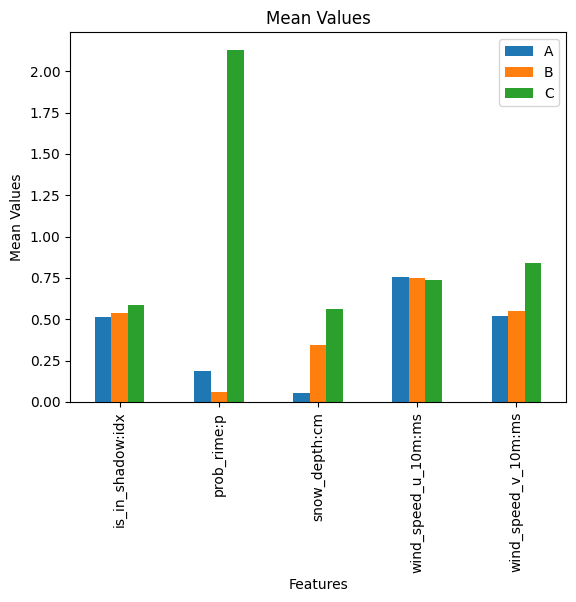

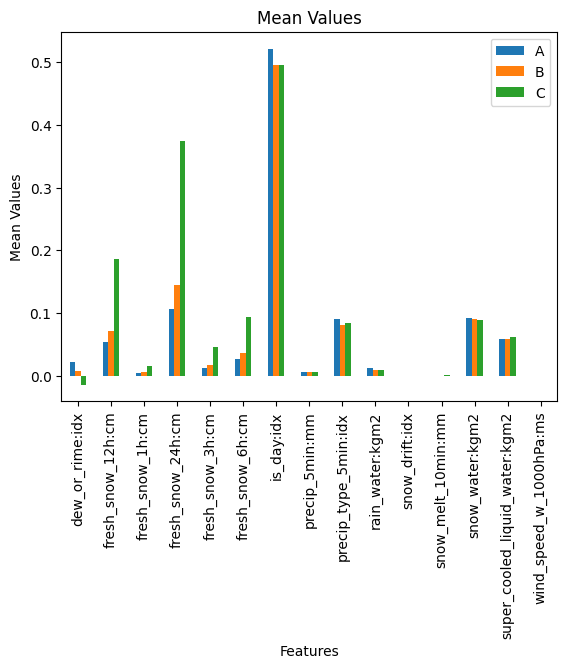

In [10]:
big_c_indices = mean_c[tiniest_indices][mean_c > 0.5].index
small_c_indices = mean_c[tiniest_indices][mean_c <= 0.5].index

display_mean_values(big_c_indices, mean_a, mean_b, mean_c)

display_mean_values(small_c_indices, mean_a, mean_b, mean_c)

From the graphs we can see that C differentiates itself hugely in elevation and probability of rime. Additiionally it snows a lot in C, less in B and least in A. Let's look at what the **elevation** and **prob_rime** features imply:

**elevation:m** = elevation of ground above sea level [m]

**prob_rime** = rime probability [%]

Let's also look closer at the **sun_elevation** feature:

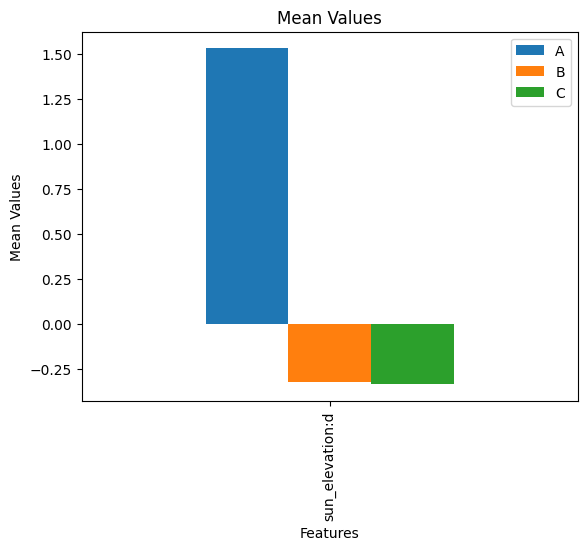

In [11]:
display_mean_values(['sun_elevation:d',], mean_a, mean_b, mean_c)

**sun_elevation:d** = The solar elevation angle (angle between the sun and the horizon) gives the position of the sun above the horizon.

This suggests that location B and C are close, and location A is in another location completely.

#### Check target data on different locations
As we can see below, the mean, max and std are huge on A compared to B and C. Also, notice that the data from location B and C are very similar compared to A

In [12]:
y_a.describe()

time  pv_measurement
count                       34085    34085.000000
mean   2021-05-14 00:29:51.497726      630.594707
min           2019-06-02 22:00:00        0.000000
25%           2020-05-22 23:00:00        0.000000
50%           2021-05-13 00:00:00        5.940000
75%           2022-05-03 01:00:00      678.040000
max           2023-04-30 23:00:00     5733.420000
std                           NaN     1165.902422

In [13]:
y_b.describe()

time  pv_measurement
count                       32848    32844.000000
mean   2020-12-07 17:46:02.031173       96.824778
min           2018-12-31 23:00:00       -0.000000
25%           2019-12-09 05:45:00       -0.000000
50%           2020-11-15 12:30:00        0.000000
75%           2021-10-23 17:15:00       96.600000
max           2023-04-30 23:00:00     1152.300000
std                           NaN      193.946487

In [14]:
y_c.describe()

time  pv_measurement
count                       32155    26095.000000
mean   2020-11-20 18:02:22.186285       77.631060
min           2018-12-31 23:00:00       -0.000000
25%           2019-12-01 23:30:00        0.000000
50%           2020-11-01 00:00:00        0.000000
75%           2021-10-01 22:30:00       58.800000
max           2023-04-30 23:00:00      999.600000
std                           NaN      165.816877

#### Identify outliers

In [15]:
z_scores = np.abs(stats.zscore(X_obs_a.drop('date_forecast', axis=1)))
outliers = (z_scores > 3).all(axis=1)
X_obs_a[outliers].head()

Empty DataFrame
Columns: [date_forecast, absolute_humidity_2m:gm3, air_density_2m:kgm3, ceiling_height_agl:m, clear_sky_energy_1h:J, clear_sky_rad:W, cloud_base_agl:m, dew_or_rime:idx, dew_point_2m:K, diffuse_rad:W, diffuse_rad_1h:J, direct_rad:W, direct_rad_1h:J, effective_cloud_cover:p, elevation:m, fresh_snow_12h:cm, fresh_snow_1h:cm, fresh_snow_24h:cm, fresh_snow_3h:cm, fresh_snow_6h:cm, is_day:idx, is_in_shadow:idx, msl_pressure:hPa, precip_5min:mm, precip_type_5min:idx, pressure_100m:hPa, pressure_50m:hPa, prob_rime:p, rain_water:kgm2, relative_humidity_1000hPa:p, sfc_pressure:hPa, snow_density:kgm3, snow_depth:cm, snow_drift:idx, snow_melt_10min:mm, snow_water:kgm2, sun_azimuth:d, sun_elevation:d, super_cooled_liquid_water:kgm2, t_1000hPa:K, total_cloud_cover:p, visibility:m, wind_speed_10m:ms, wind_speed_u_10m:ms, wind_speed_v_10m:ms, wind_speed_w_1000hPa:ms]
Index: []

#### Visualize outliers

<Axes: >

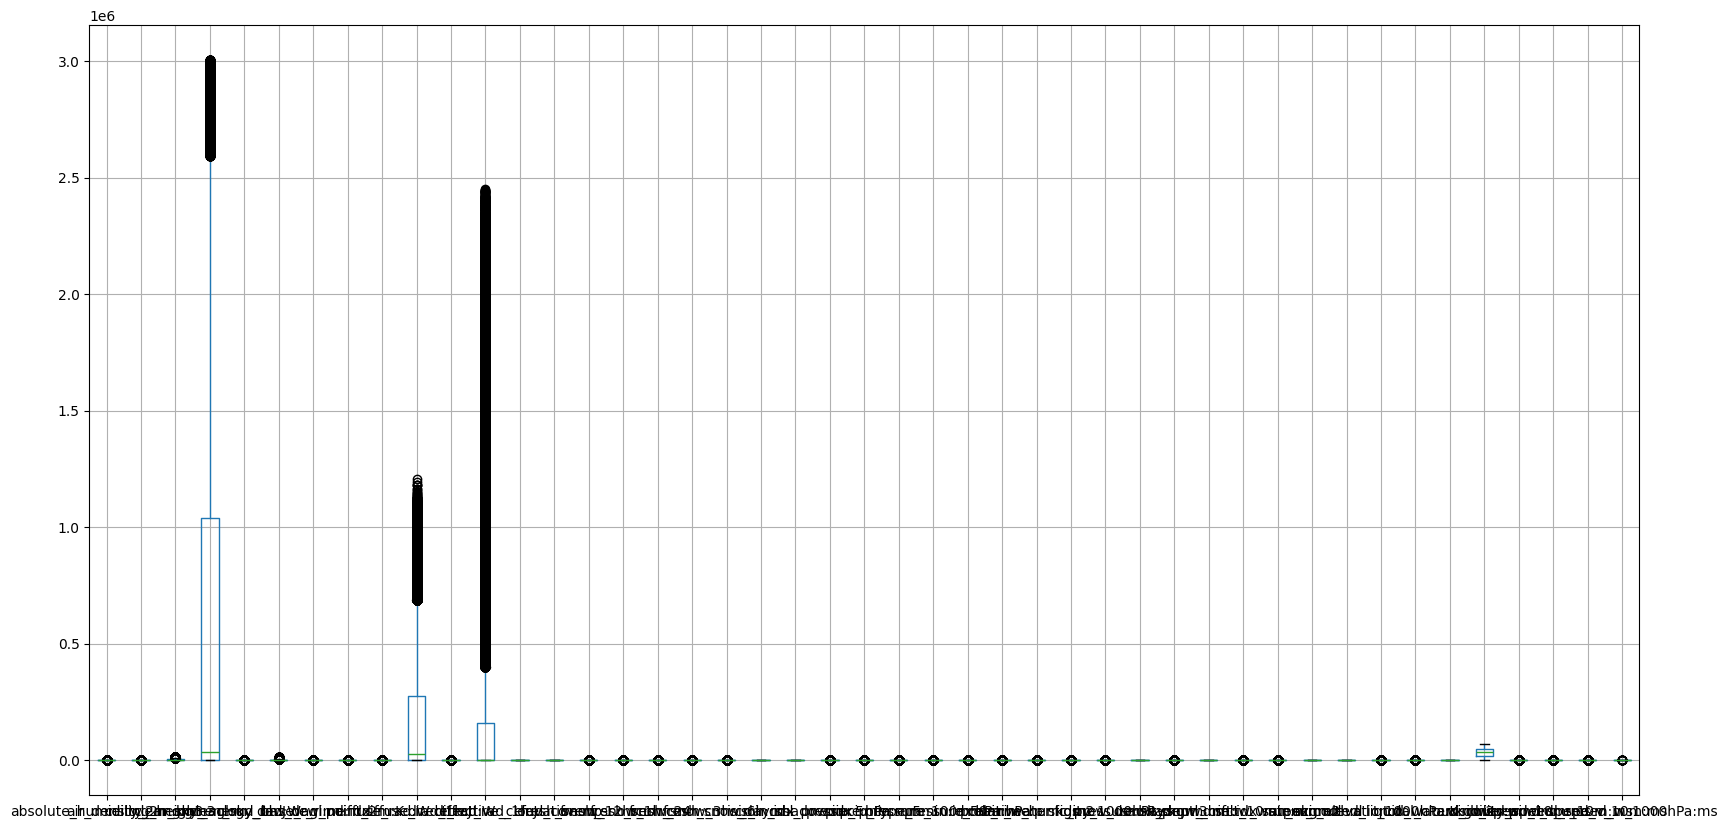

In [16]:
X_obs_a.boxplot(figsize=(20, 10))

<Axes: >

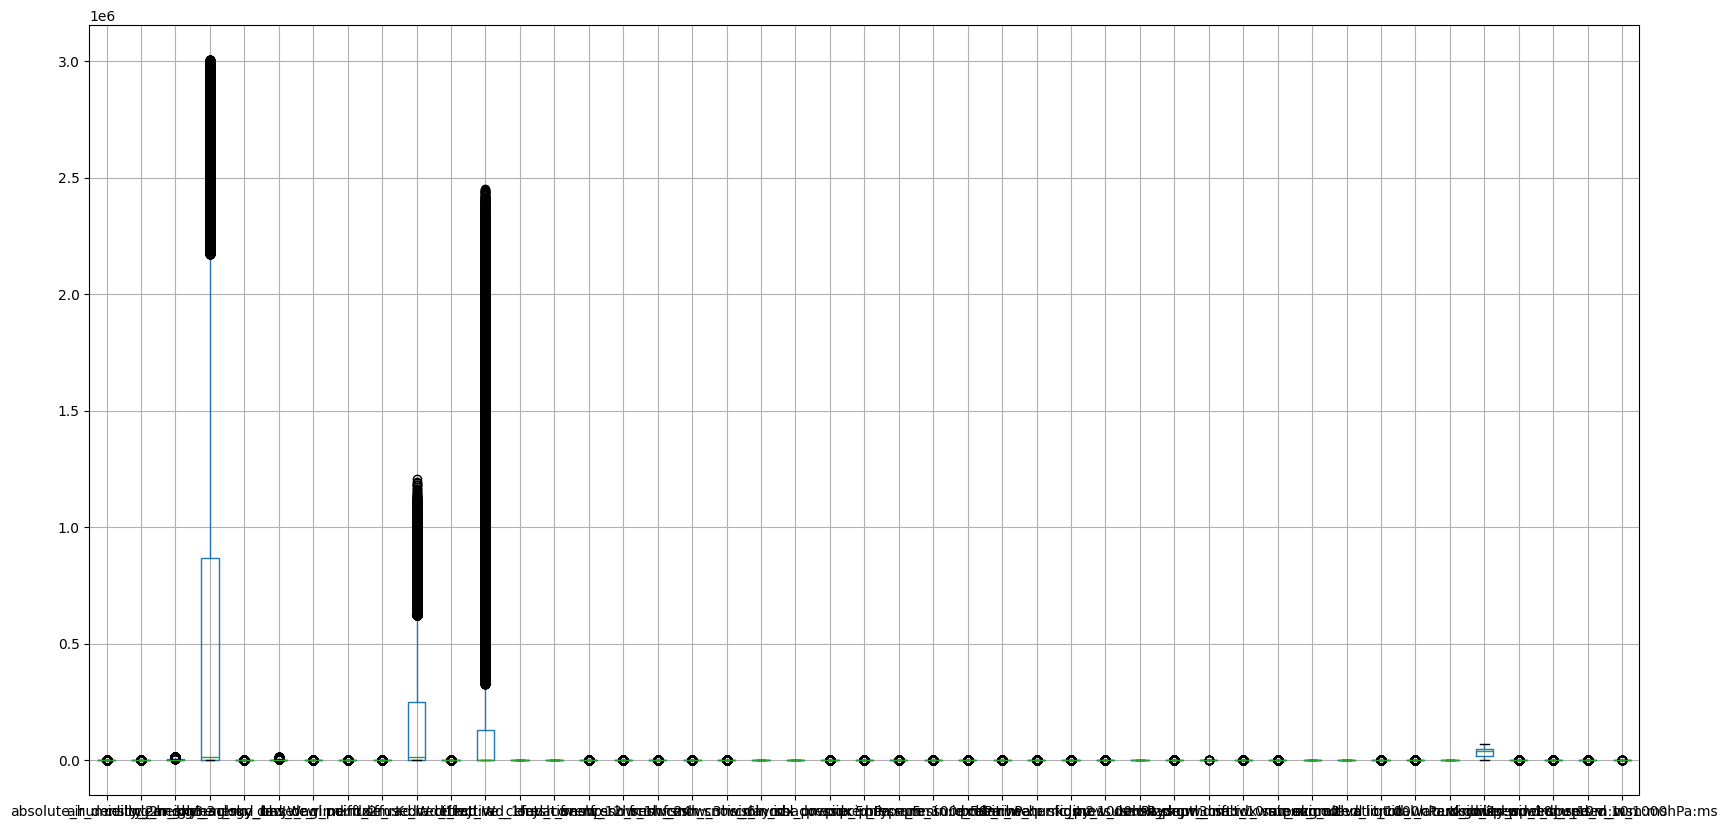

In [17]:
X_obs_b.boxplot(figsize=(20, 10))


<Axes: >

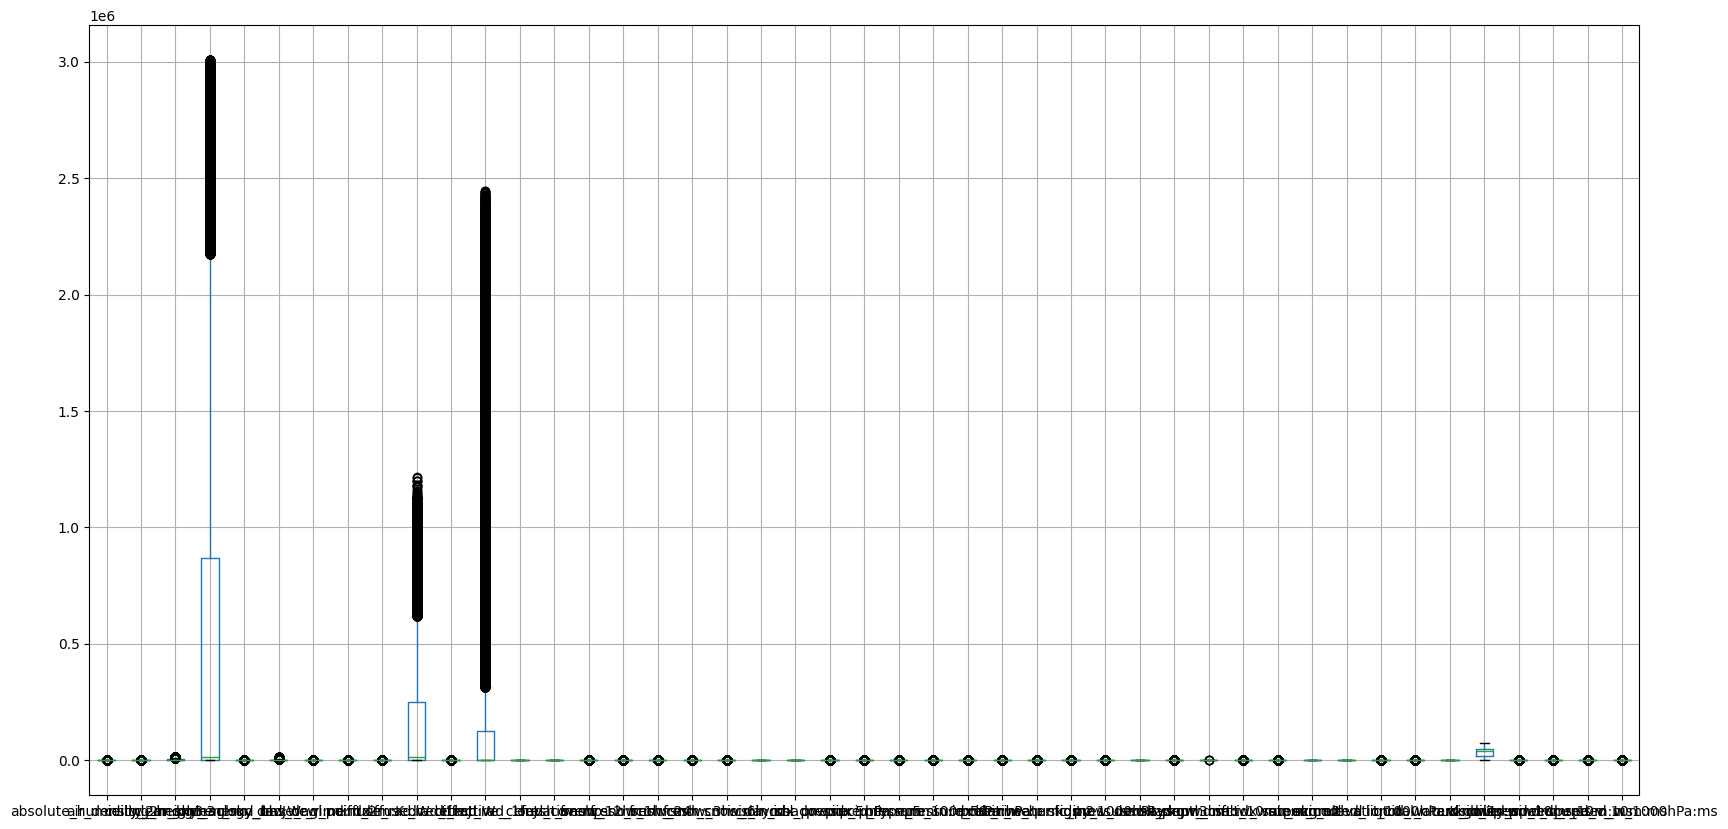

In [18]:
X_obs_c.boxplot(figsize=(20, 10))


#### Findings

We can see that 3 of the features have a lot of outliers on all of the locations. Let's investigate closer:


In [19]:
all_features = X_obs_a.columns.tolist()
# Find outliers by index according to the boxplot
outlier_features = [all_features[i] for i in (4, 10, 12)]
print(outlier_features)

['clear_sky_energy_1h:J', 'diffuse_rad_1h:J', 'direct_rad_1h:J']


Looked up the features and found this

**clear_sky_energy_1h:J** = clear sky energy of previous time period, available up to 24h [J/m2]

**diffuse_rad_1h:J** = accumulated diffuse radiation of previous time period, available up to 24h [J/m2]

**direct_rad_1h:J** = accumulated direct radiation of previous time period, available up to 24h [J/m2]

All of these are for the last hour, so I decided to investigate the datasets further

In [20]:
X_obs_a.head(100)

date_forecast  absolute_humidity_2m:gm3  air_density_2m:kgm3  \
0  2019-06-02 22:00:00                       7.7                1.230   
1  2019-06-02 22:15:00                       7.7                1.229   
2  2019-06-02 22:30:00                       7.7                1.228   
3  2019-06-02 22:45:00                       7.7                1.226   
4  2019-06-02 23:00:00                       7.7                1.225   
5  2019-06-02 23:15:00                       7.7                1.224   
6  2019-06-02 23:30:00                       7.7                1.223   
7  2019-06-02 23:45:00                       7.7                1.222   
8  2019-06-03 00:00:00                       7.7                1.221   
9  2019-06-03 00:15:00                       7.8                1.220   
10 2019-06-03 00:30:00                       7.9                1.219   
11 2019-06-03 00:45:00                       8.1                1.219   
12 2019-06-03 01:00:00                       8.2                1.218   
13 2019-06-03 01:15:00                       8.4                1.218   
14 2019-06-03 01:30:00                       8.5                1.218   
15 2019-06-03 01:45:00                       8.6                1.218   
16 2019-06-03 02:00:00                       8.8                1.219   
17 2019-06-03 02:15:00                       8.9                1.218   
18 2019-06-03 02:30:00                       9.0                1.218   
19 2019-06-03 02:45:00                       9.1                1.217   
20 2019-06-03 03:00:00                       9.1                1.217   
21 2019-06-03 03:15:00                       9.2                1.217   
22 2019-06-03 03:30:00                       9.3                1.216   
23 2019-06-03 03:45:00                       9.4                1.216   
24 2019-06-03 04:00:00                       9.4                1.215   
25 2019-06-03 04:15:00                       9.5                1.214   
26 2019-06-03 04:30:00                       9.6                1.212   
27 2019-06-03 04:45:00                       9.6                1.211   
28 2019-06-03 05:00:00                       9.7                1.209   
29 2019-06-03 05:15:00                       9.7                1.208   
30 2019-06-03 05:30:00                       9.7                1.207   
31 2019-06-03 05:45:00                       9.7                1.206   
32 2019-06-03 06:00:00                       9.7                1.204   
33 2019-06-03 06:15:00                       9.6                1.205   
34 2019-06-03 06:30:00                       9.5                1.205   
35 2019-06-03 06:45:00                       9.4                1.206   
36 2019-06-03 07:00:00                       9.3                1.206   
37 2019-06-03 07:15:00                       9.4                1.205   
38 2019-06-03 07:30:00                       9.5                1.205   
39 2019-06-03 07:45:00                       9.6                1.204   
40 2019-06-03 08:00:00                       9.7                1.203   
41 2019-06-03 08:15:00                       9.8                1.203   
42 2019-06-03 08:30:00                       9.9                1.202   
43 2019-06-03 08:45:00                      10.0                1.202   
44 2019-06-03 09:00:00                      10.1                1.201   
45 2019-06-03 09:15:00                      10.1                1.199   
46 2019-06-03 09:30:00                      10.1                1.198   
47 2019-06-03 09:45:00                      10.0                1.196   
48 2019-06-03 10:00:00                      10.0                1.194   
49 2019-06-03 10:15:00                      10.0                1.191   
50 2019-06-03 10:30:00                      10.0                1.188   
51 2019-06-03 10:45:00                       9.9                1.185   
52 2019-06-03 11:00:00                       9.9                1.182   
53 2019-06-03 11:15:00                       9.9                1.1

<Axes: >

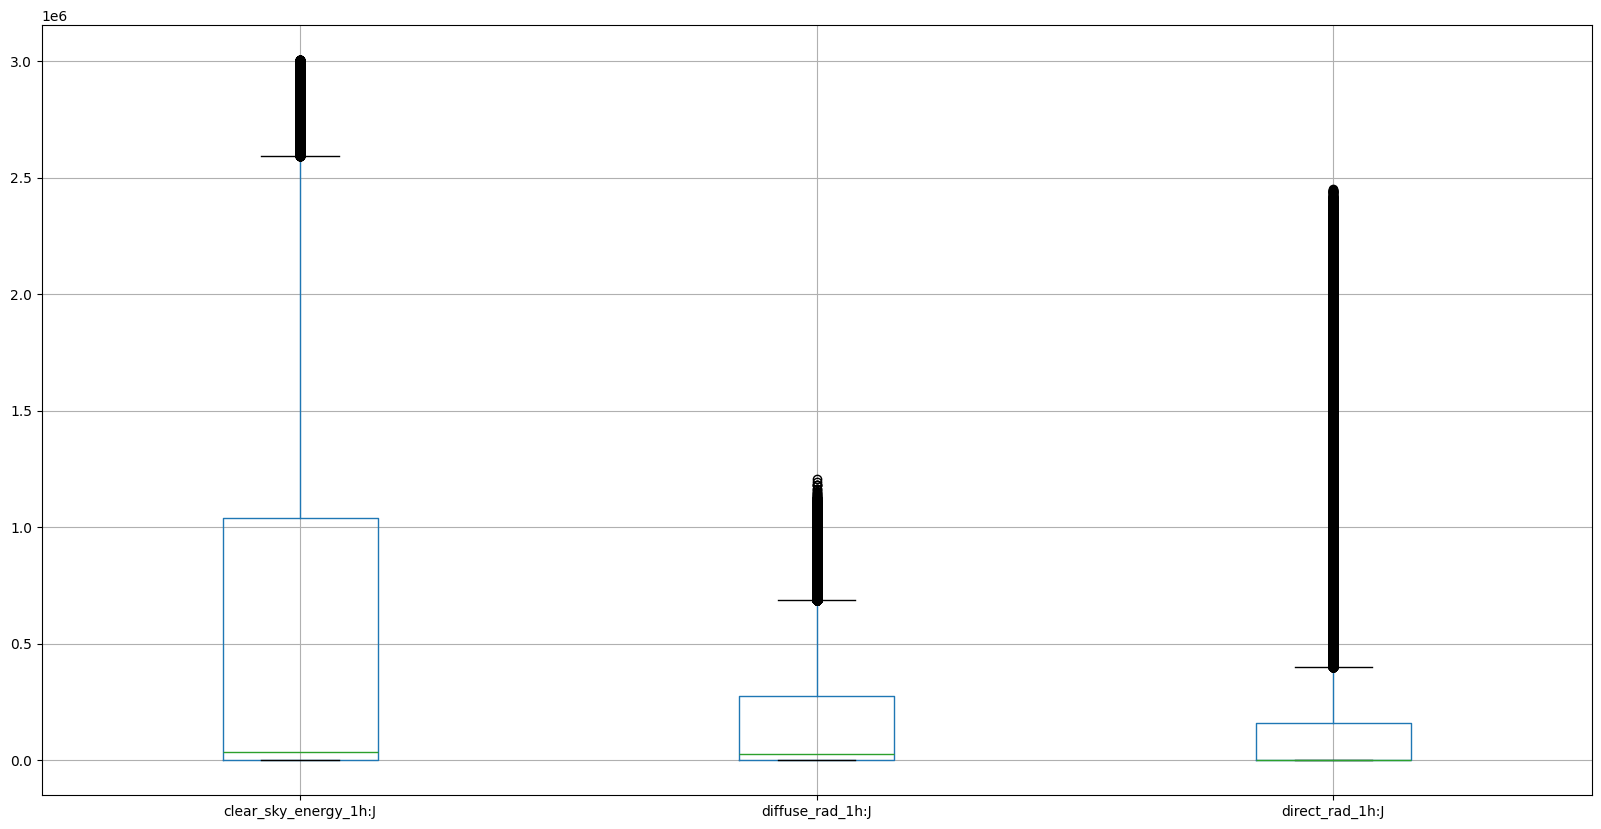

In [21]:
X_obs_a.boxplot(outlier_features, figsize=(20, 10))

## 1.4 Explore pairs and groups of freatures

In the early stages we plotted everything to get a an overview of the data.

### Initial Correlation Matrix

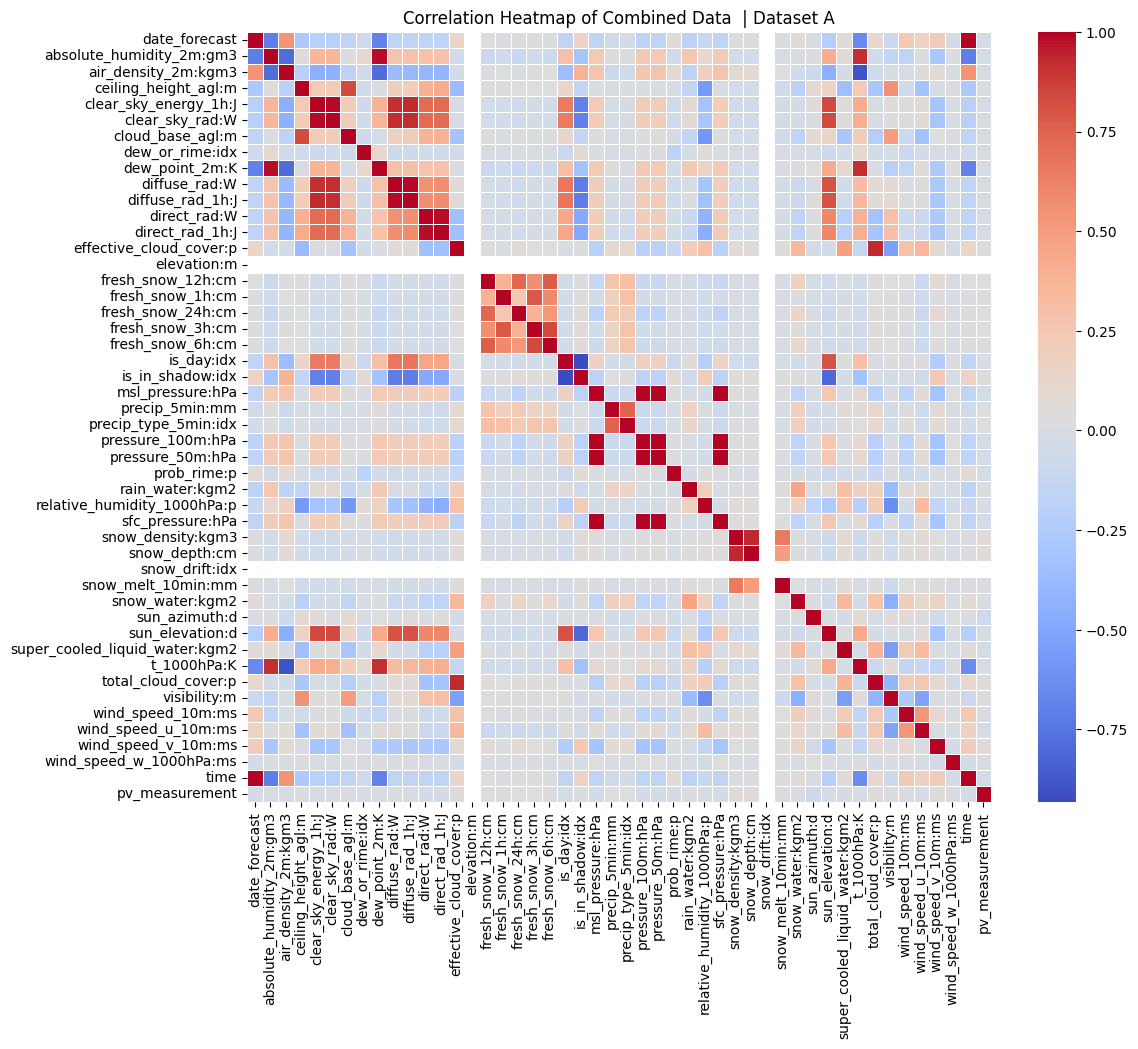

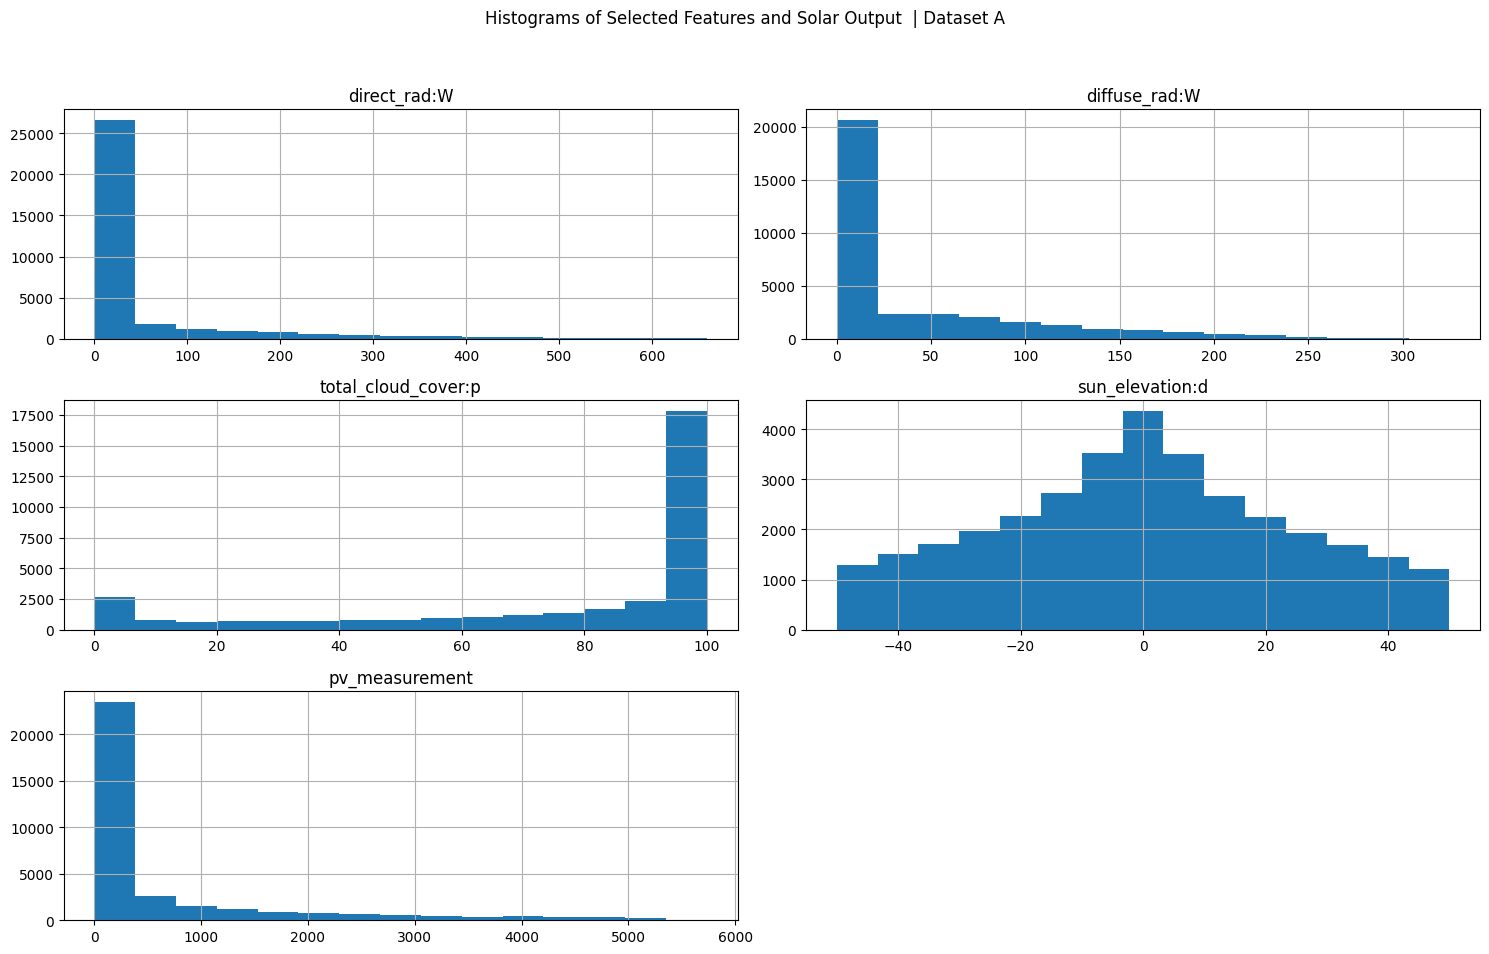

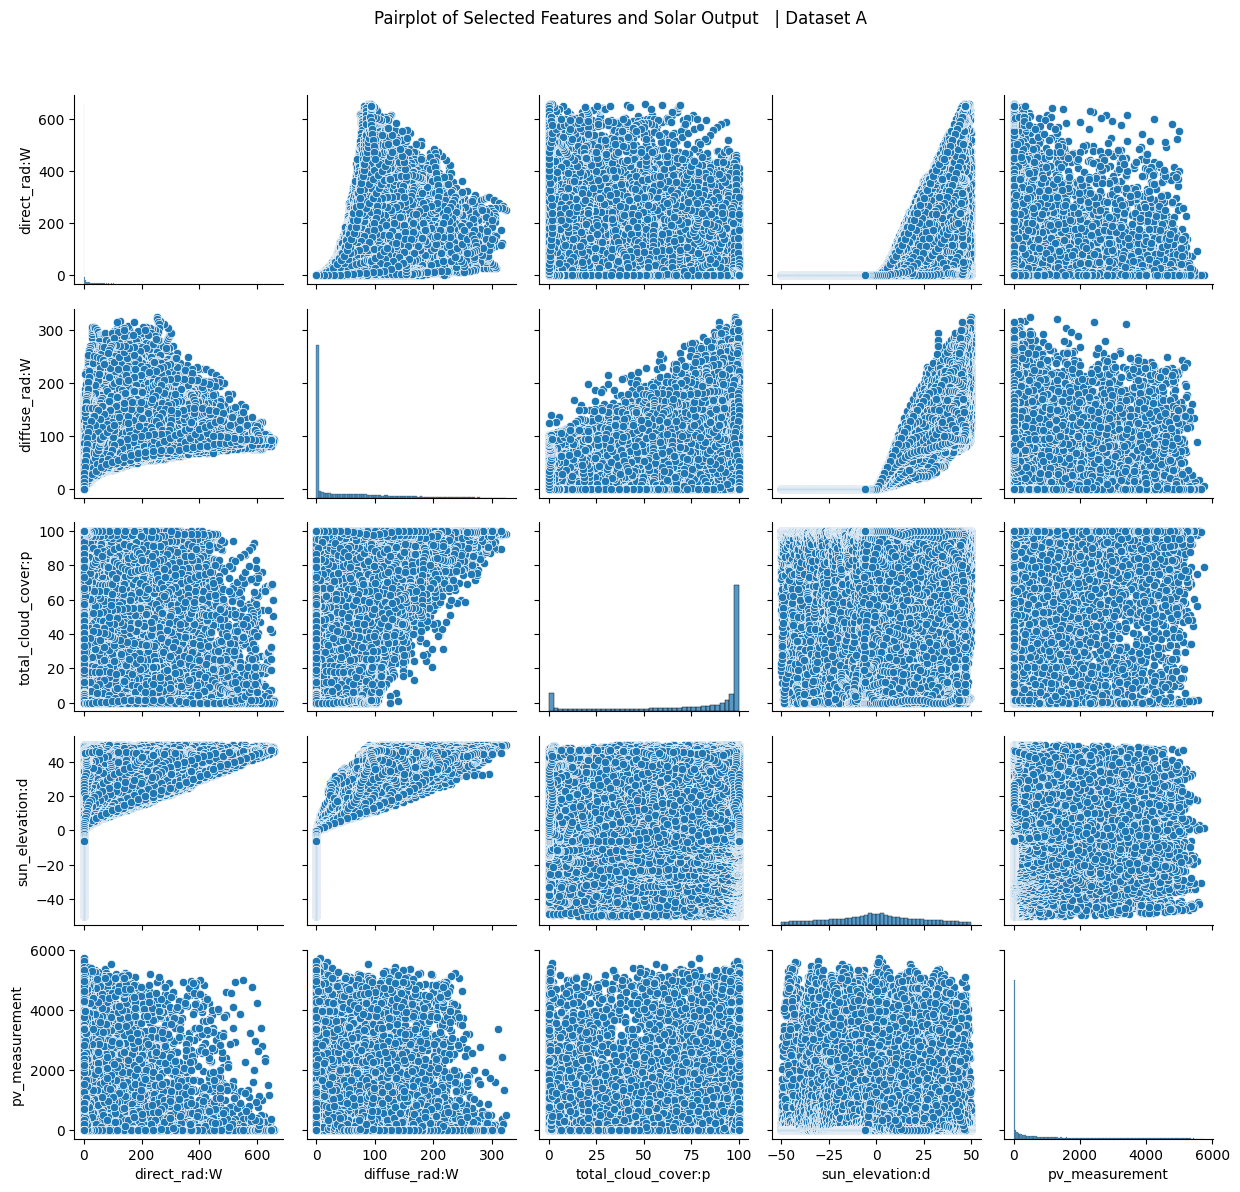

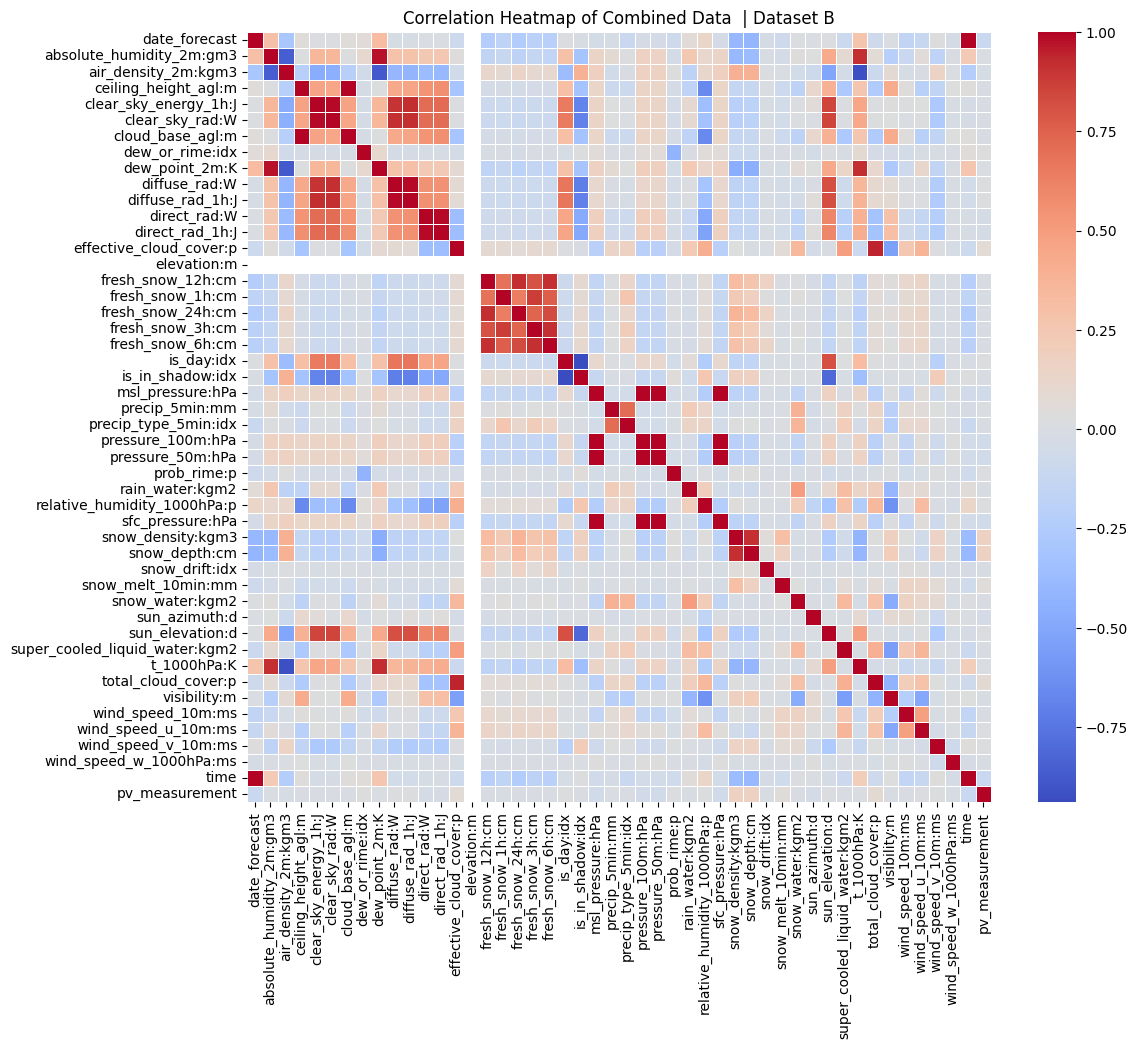

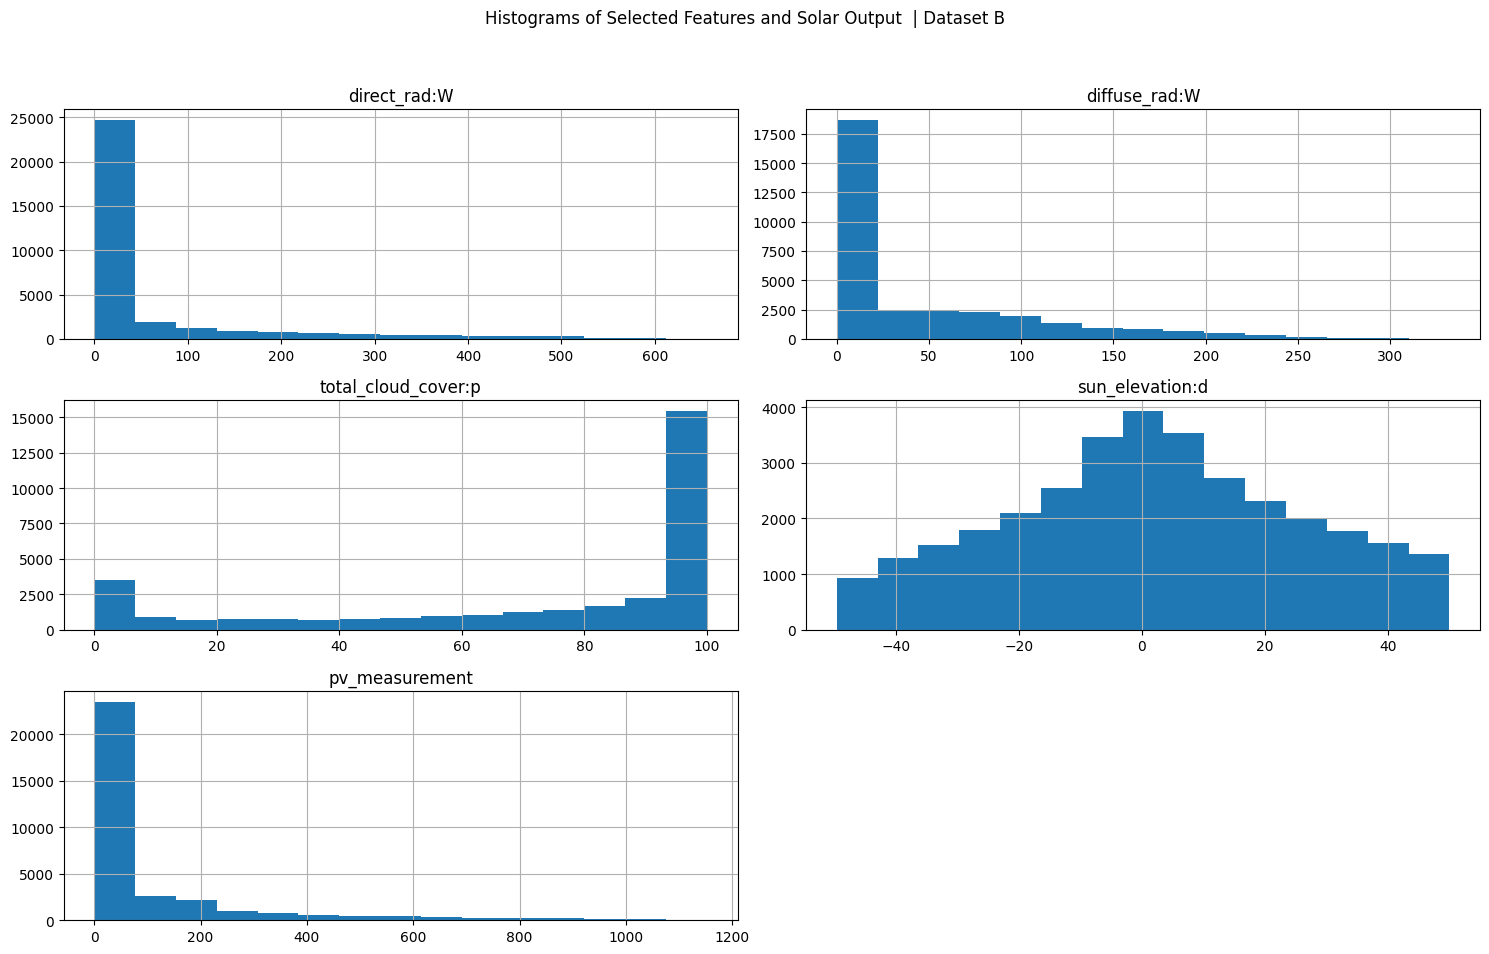

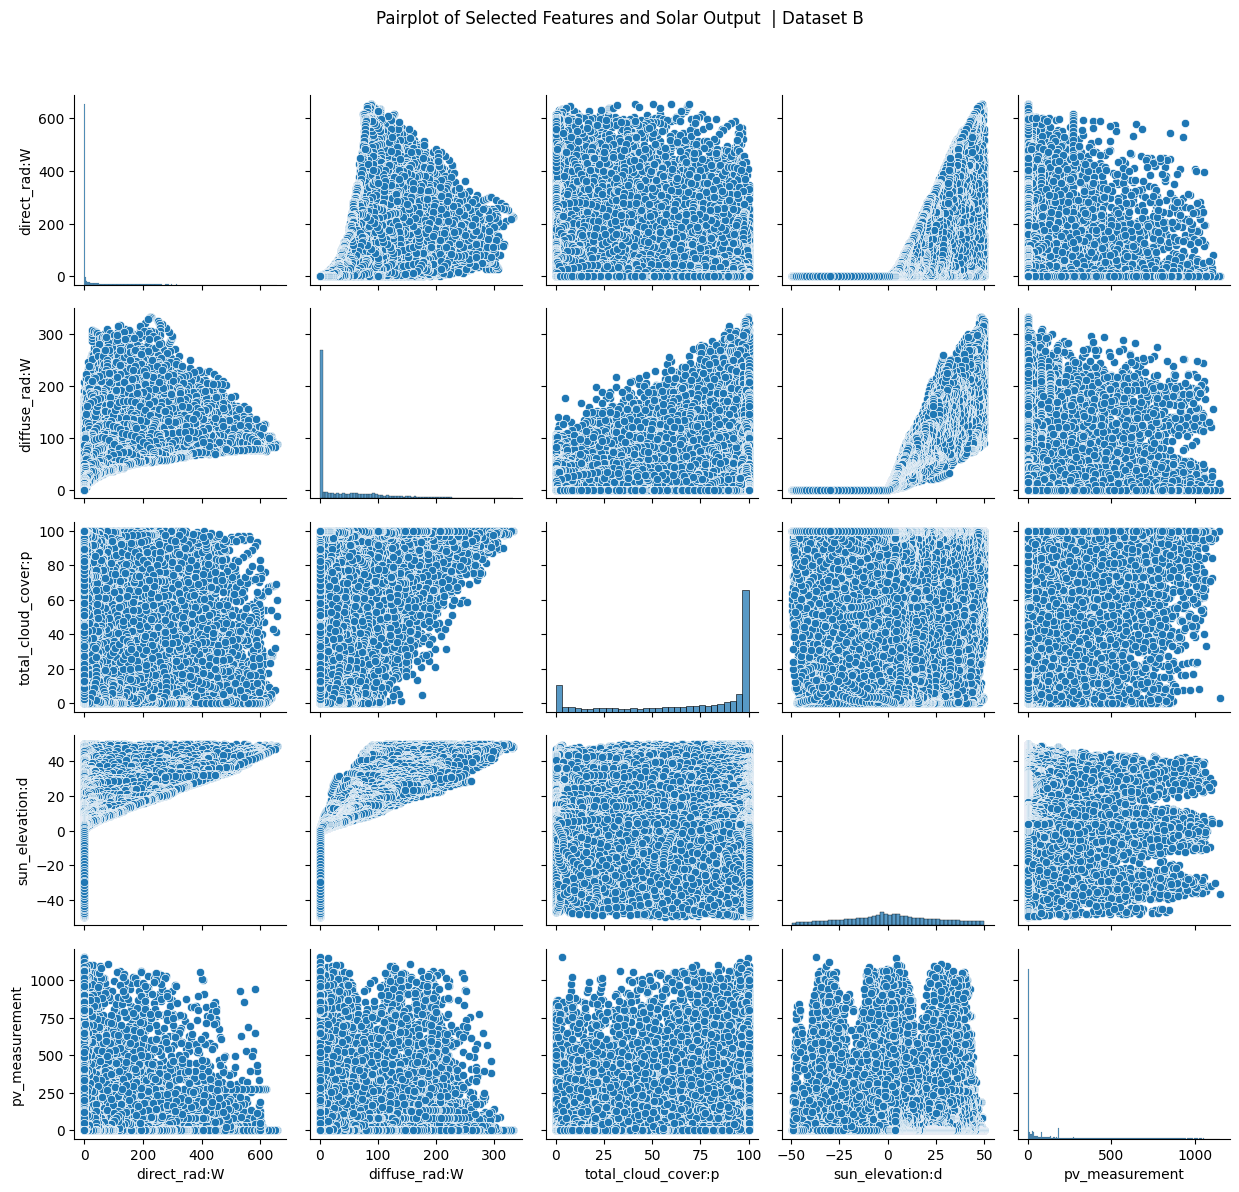

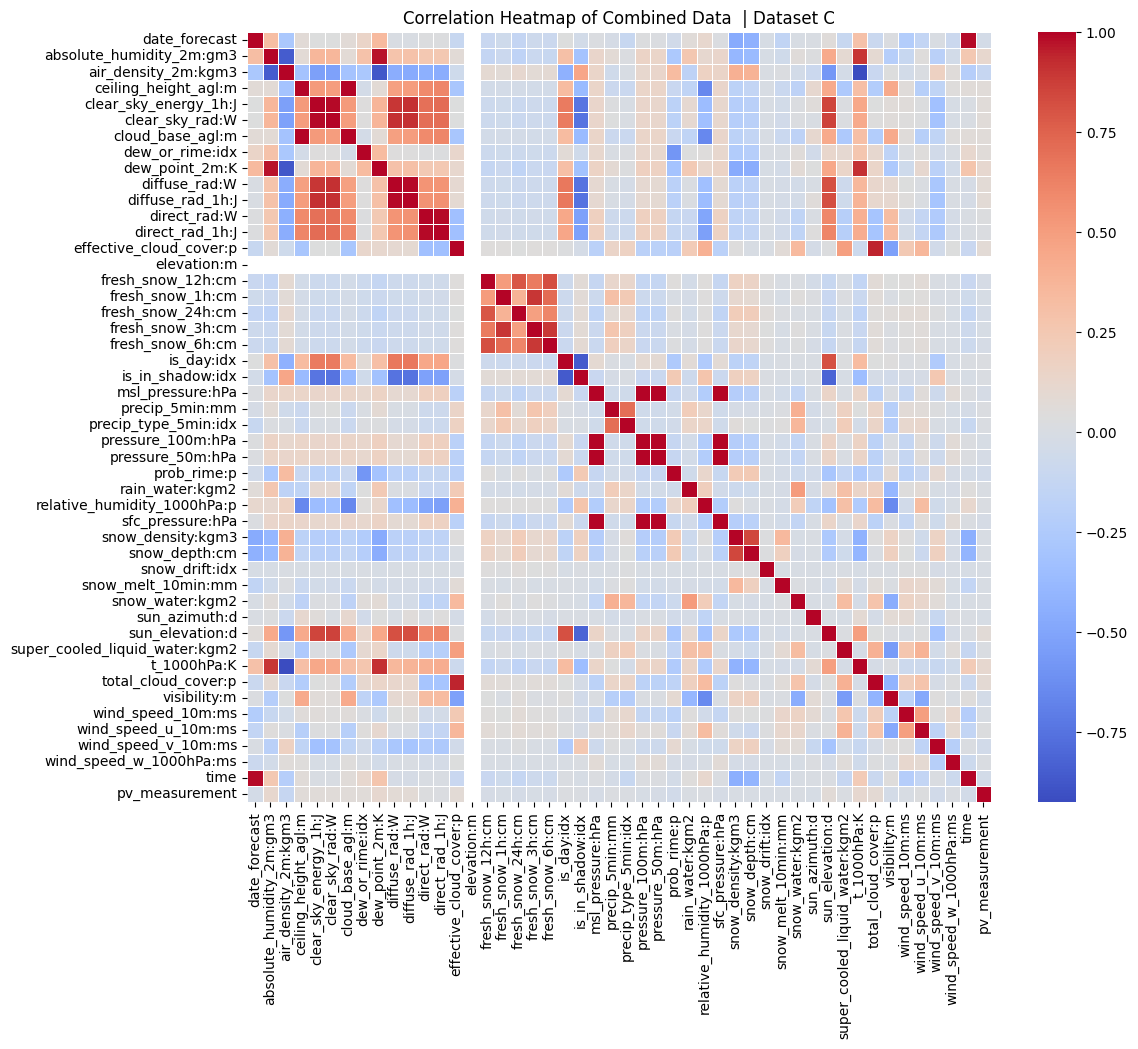

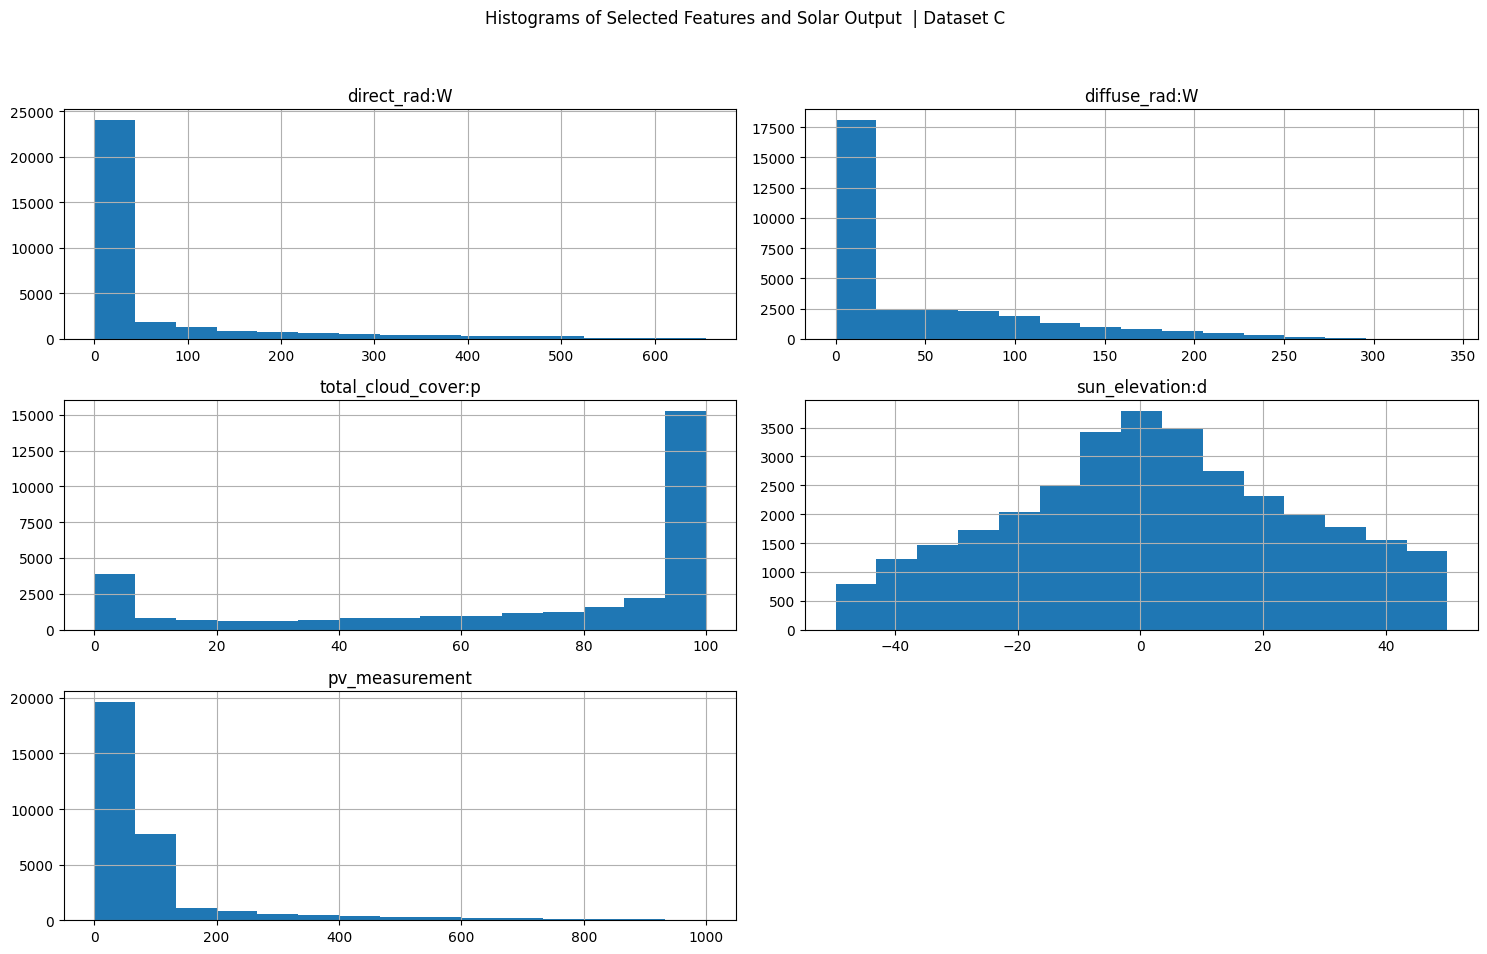

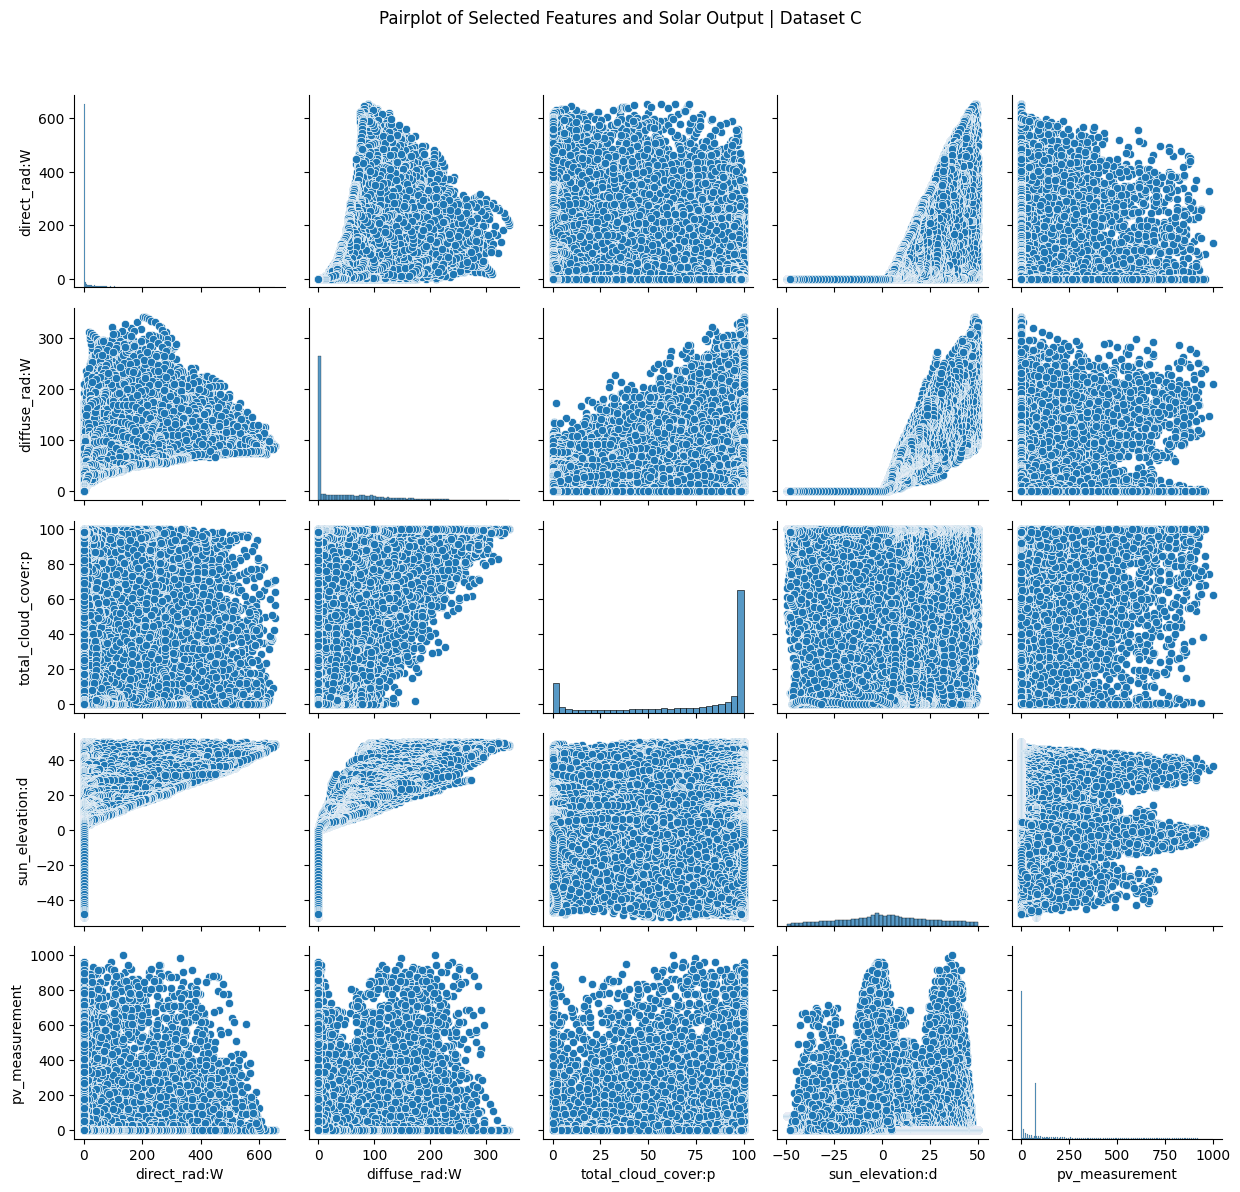

In [22]:
# Align the target data to the resampled observed data
combined_A_df = X_train_observed_a.join(train_a, how='inner')
combined_B_df = X_train_observed_b.join(train_b, how='inner')
combined_C_df = X_train_observed_c.join(train_c, how='inner')

# Handle missing values for location A
combined_A_df['snow_density:kgm3'].fillna(0, inplace=True)
combined_A_df.fillna(combined_A_df.mean(), inplace=True)

# Handle missing values for location B
combined_B_df['snow_density:kgm3'].fillna(0, inplace=True)
combined_B_df.fillna(combined_B_df.mean(), inplace=True)

# Handle missing values for location C
combined_C_df['snow_density:kgm3'].fillna(0, inplace=True)
combined_C_df.fillna(combined_C_df.mean(), inplace=True)


# Calculate the correlations for the combined dataset
correlation_matrix = combined_A_df.corr()

# Plot the correlation heatmap for the new combined dataset
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap of Combined Data  | Dataset A')
plt.show()

# Create histograms for some selected features and the target variable
selected_features = ['direct_rad:W', 'diffuse_rad:W', 'total_cloud_cover:p', 'sun_elevation:d', 'pv_measurement']
combined_A_df[selected_features].hist(bins=15, figsize=(15, 10), layout=(3, 2))
plt.suptitle('Histograms of Selected Features and Solar Output  | Dataset A')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for the suptitle
plt.show()

# Let's also look at a pair plot for the selected features and the target variable to visualize pairwise relationships
sns.pairplot(combined_A_df[selected_features])
plt.suptitle('Pairplot of Selected Features and Solar Output   | Dataset A')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for the suptitle
plt.show()


# Calculate the correlations for the combined dataset
correlation_matrix = combined_B_df.corr()

# Plot the correlation heatmap for the new combined dataset
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap of Combined Data  | Dataset B')
plt.show()

# Create histograms for some selected features and the target variable
selected_features = ['direct_rad:W', 'diffuse_rad:W', 'total_cloud_cover:p', 'sun_elevation:d', 'pv_measurement']
combined_B_df[selected_features].hist(bins=15, figsize=(15, 10), layout=(3, 2))
plt.suptitle('Histograms of Selected Features and Solar Output  | Dataset B')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for the suptitle
plt.show()

# Let's also look at a pair plot for the selected features and the target variable to visualize pairwise relationships
sns.pairplot(combined_B_df[selected_features])
plt.suptitle('Pairplot of Selected Features and Solar Output  | Dataset B')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for the suptitle
plt.show()


# Calculate the correlations for the combined dataset
correlation_matrix = combined_C_df.corr()

# Plot the correlation heatmap for the new combined dataset
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap of Combined Data  | Dataset C')
plt.show()

# Create histograms for some selected features and the target variable
selected_features = ['direct_rad:W', 'diffuse_rad:W', 'total_cloud_cover:p', 'sun_elevation:d', 'pv_measurement']
combined_C_df[selected_features].hist(bins=15, figsize=(15, 10), layout=(3, 2))
plt.suptitle('Histograms of Selected Features and Solar Output  | Dataset C')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for the suptitle
plt.show()

# Let's also look at a pair plot for the selected features and the target variable to visualize pairwise relationships
sns.pairplot(combined_C_df[selected_features])
plt.suptitle('Pairplot of Selected Features and Solar Output | Dataset C')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for the suptitle
plt.show()

### Correlation Matrix after cleaning

The next we made had merged all the cleaned data, and was more organized.

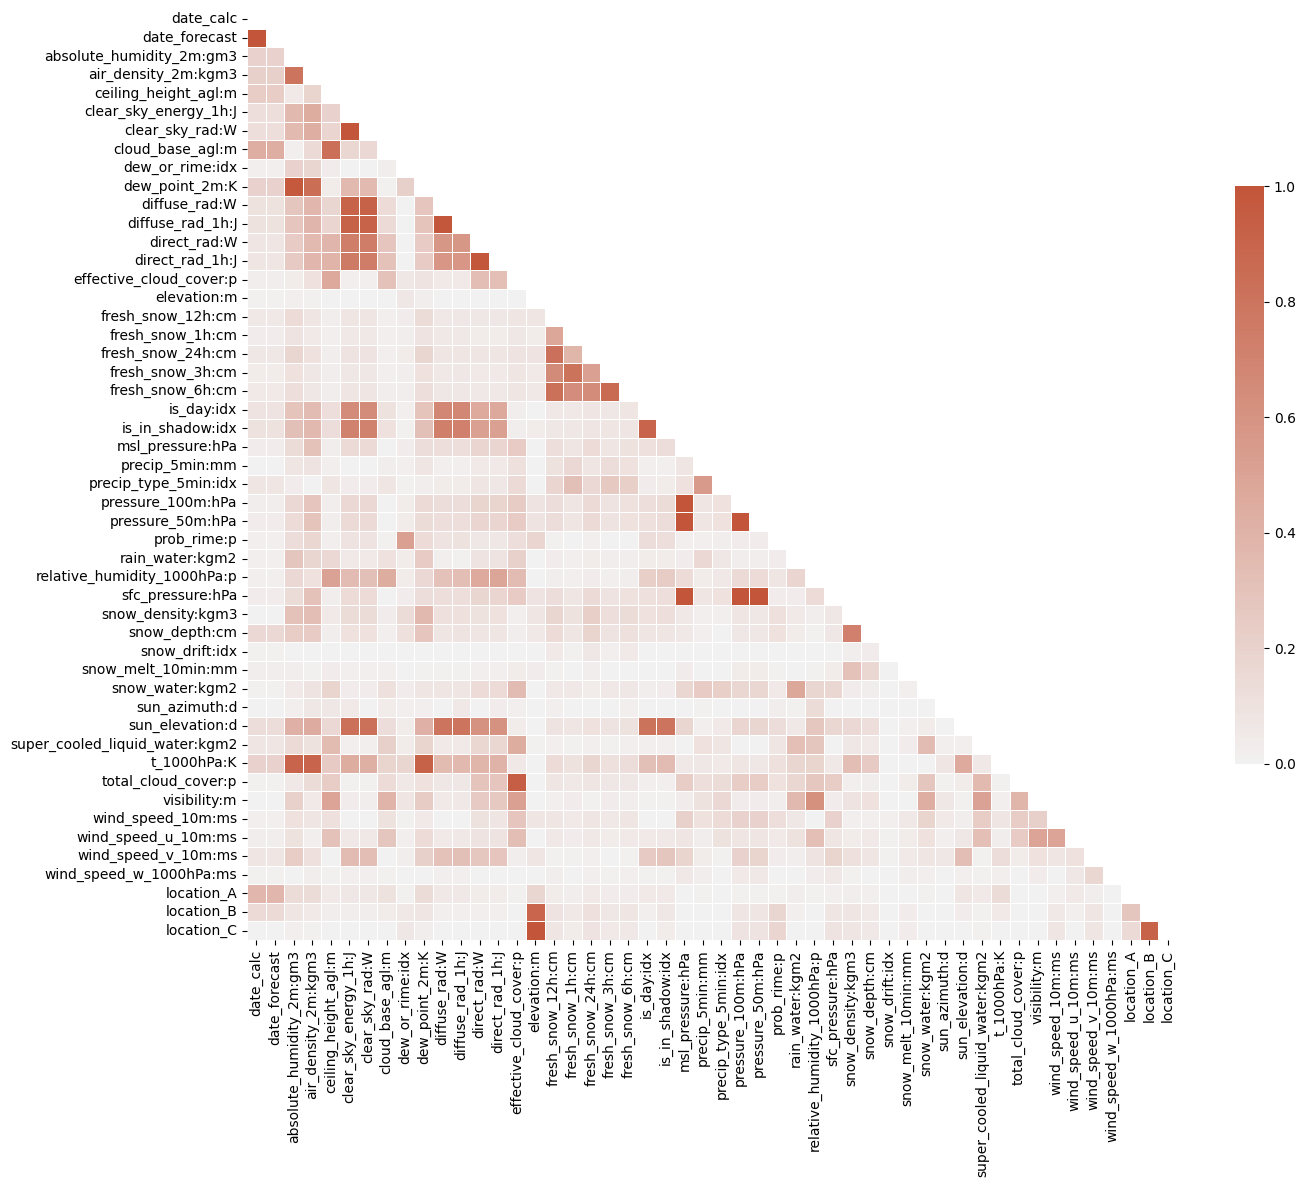

In [23]:
y_a = pd.read_parquet('A/train_targets.parquet')
y_b = pd.read_parquet('B/train_targets.parquet')
y_c = pd.read_parquet('C/train_targets.parquet')

X_a = pd.read_parquet('A/X_train_observed.parquet')
X_b = pd.read_parquet('B/X_train_observed.parquet')
X_c = pd.read_parquet('C/X_train_observed.parquet')

X_a_estimated = pd.read_parquet('A/X_train_estimated.parquet')
X_b_estimated = pd.read_parquet('B/X_train_estimated.parquet')
X_c_estimated = pd.read_parquet('C/X_train_estimated.parquet')

X_a_test = pd.read_parquet('A/X_test_estimated.parquet')
X_b_test = pd.read_parquet('B/X_test_estimated.parquet')
X_c_test = pd.read_parquet('C/X_test_estimated.parquet')



mask_a = X_a['date_forecast'] < '2020-03-26'
mask_b = X_b['date_forecast'] < '2020-03-26'
mask_c = X_c['date_forecast'] < '2020-03-26'

# Apply the conversion from meters to feet (1 meter = 3.28084 feet)
conversion_factor = 3.28084

X_a.loc[mask_a, 'ceiling_height_agl:m'] *= conversion_factor
X_b.loc[mask_b, 'ceiling_height_agl:m'] *= conversion_factor
X_c.loc[mask_c, 'ceiling_height_agl:m'] *= conversion_factor

X_a.loc[mask_a, 'cloud_base_agl:m'] *= conversion_factor
X_b.loc[mask_b, 'cloud_base_agl:m'] *= conversion_factor
X_c.loc[mask_c, 'cloud_base_agl:m'] *= conversion_factor




#add location to each sample
X_a["location"] = "A"
X_b["location"] = "B"
X_c["location"] = "C"
X_a_estimated["location"] = "A"
X_b_estimated["location"] = "B"
X_c_estimated["location"] = "C"

#remove extra minute 00 sample
X_a = X_a.iloc[:-1,:]
X_a = X_b.iloc[:-1,:]
X_c = X_c.iloc[:-1,:]

#add date_calc column same as date_forecast column to observed data
X_a.insert(0, "date_calc", X_a["date_forecast"])
X_b.insert(0, "date_calc", X_b["date_forecast"])
X_c.insert(0, "date_calc", X_c["date_forecast"])

X = pd.concat([X_a, X_b, X_c, X_a_estimated, X_b_estimated, X_c_estimated])

#OHE av location
X["location_A"] = X["location"].apply(lambda loc: loc == "A").map({True: 1, False: 0})
X["location_B"] = X["location"].apply(lambda loc: loc == "B").map({True: 1, False: 0})
X["location_C"] = X["location"].apply(lambda loc: loc == "C").map({True: 1, False: 0})

X.drop("location", axis=1, inplace=True)


X["snow_density:kgm3"] = X["snow_density:kgm3"].apply(
    lambda a : np.isnan(a)
    ).map({True: 0, False: 1})


def drop_cols(to_drop):
    X_a.drop(to_drop, axis=1, inplace=True)
    X_b.drop(to_drop, axis=1, inplace=True)
    X_c.drop(to_drop, axis=1, inplace=True)
    X_a_estimated.drop(to_drop, axis=1, inplace=True)
    X_b_estimated.drop(to_drop, axis=1, inplace=True)
    X_c_estimated.drop(to_drop, axis=1, inplace=True)

def show_corr_matrix(df):
    corr = df.corr().abs()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(15, 15))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=0, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
def show_corr_matrix_with_values(df):
    corr = df.corr().abs()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(15, 15))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=0, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

show_corr_matrix(X)

#### Snow
We took a deeper look into the snow-features. However, after trial and error, it didn't contribute much to our predictions. It makes sense based on that the test set is in the summer, and the snow features are not relevant.

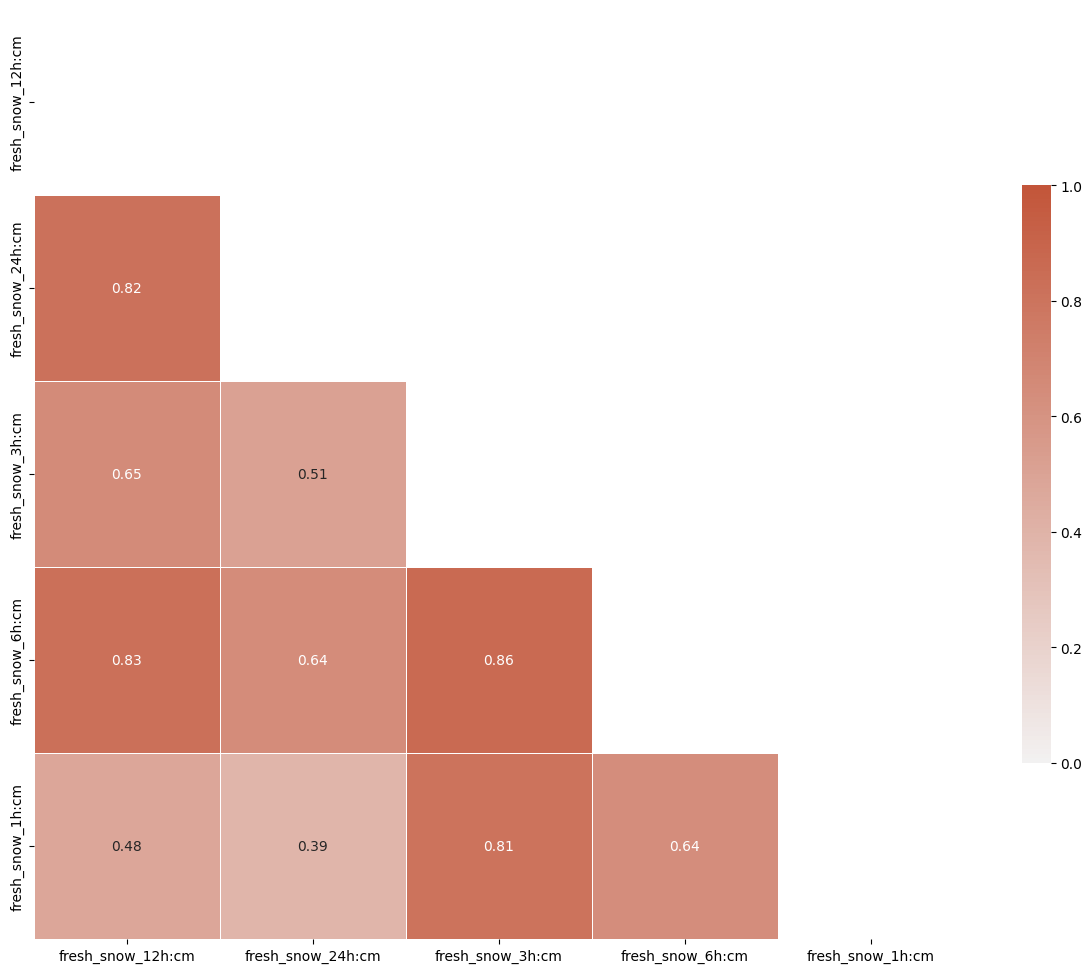

In [24]:
show_corr_matrix_with_values(X[['fresh_snow_12h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'fresh_snow_1h:cm']])

#### Pressure

We had a look at the pressure features

It's apparent that 'pressure_100m:hPa', 'pressure_50m:hPa' and 'sfc_pressure:hPa' have a very high correlation. Let's look closer into what kind of information they give us:

**pressure_000m:hPa**: atmospheric pressure, available up to 20 km altitude [hPa]

**sfc_pressure:hPa**: surface pressure [hPa]

**msl_pressure:hPa**: mean sea level pressure [hPa]

**t_1000hPa:K**: instantaneous temperature at the indicated level above ground in the corresponding unit [K]

So the last one is a temperature reading at a level above ground corresponding to 1000hPa of pressure. According to results on google it is the usual pressure at **sea level**.

After trial and error we concluded that the best was to keep the mean sea level-pressure if we were to filter any of the features.

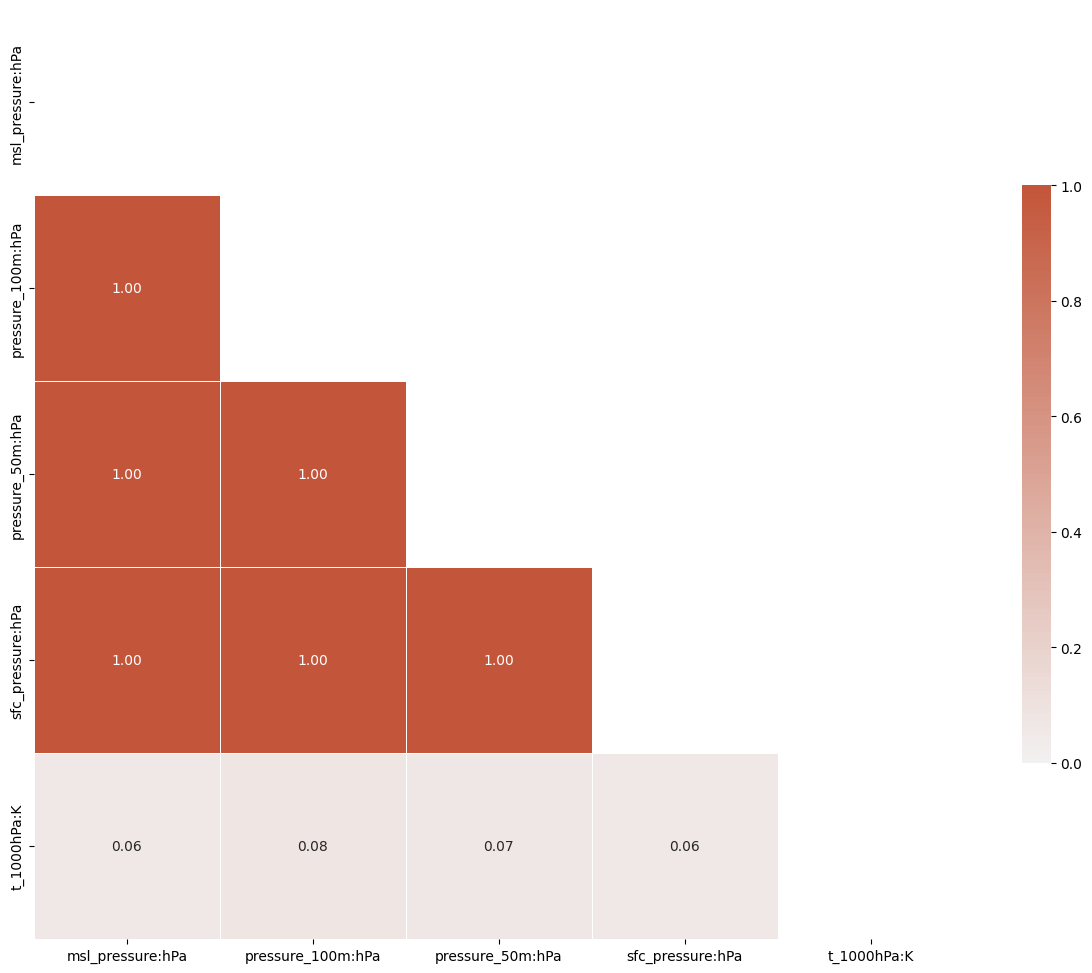

In [25]:
pressure_features = ['msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa', 't_1000hPa:K']

show_corr_matrix_with_values(X[pressure_features])

#### Air features

**t_1000hPa:K**: Instantaneous temperature at the indicated level above ground in the corresponding unit [K]

**absolute_humidity_2m:gm3**: Absolute humidity at 2m in . Note: the absolute humidity is only available at 2m.

**air_density_2m:kgm3**: Density of air at any height level above ground up to 10 km.

**dew_point_2m:K**: Instantaneous value of the dew point temperature at the indicated level.

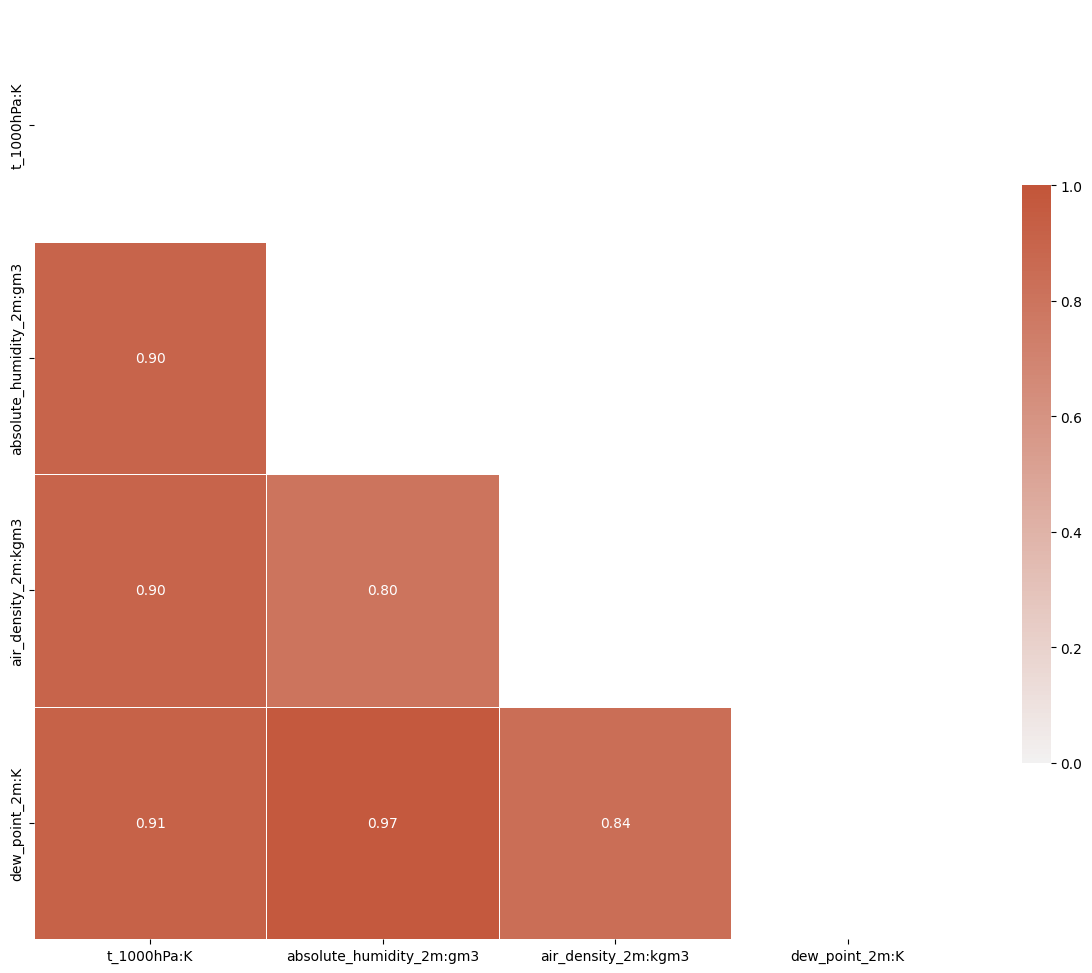

In [26]:
air_attributes = ['t_1000hPa:K', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'dew_point_2m:K']

show_corr_matrix_with_values(X[air_attributes])

#### Clear sky energy and clear sky rad

**clear_sky_rad:W**: Instantaneous flux of clear sky radiation in Watts per square meter

**clear_sky_energy_1h:J**: clear sky energy of previous time period, available up to 24h [J/m2]

This is what chatGPT says about clear sky energy:

*"Clear sky energy" refers to the amount of solar energy that reaches the Earth's surface from the sun when the sky is clear of clouds and other atmospheric obstructions. It represents the maximum potential solar energy available at a specific location under ideal conditions, assuming there are no atmospheric factors, such as clouds or pollution, that would attenuate or scatter the sunlight.*

*Clear sky energy is often used in solar energy and photovoltaic (PV) system analysis and design. Solar energy professionals use clear sky models to estimate the amount of energy that can be harvested from solar panels under optimal conditions, taking into account factors like the position of the sun, the latitude of the location, and the time of day.*

*It's important to note that in real-world applications, the actual solar energy output from a solar panel or system can be significantly lower than the clear sky energy due to various factors, including cloud cover, air pollution, shading, and the efficiency of the solar panels. Clear sky energy serves as a reference point and helps in understanding the maximum solar energy potential at a given location.*

The same goes for the radiation:

*"Clear sky radiation" refers to the amount of solar radiation that reaches the Earth's surface from the sun when there are no clouds or other atmospheric obstructions present. It represents the maximum potential solar radiation that can be received at a specific location under ideal conditions, assuming a perfectly clear and cloudless sky.*

*Clear sky radiation is an important concept in the field of meteorology, solar energy, and climate science. It is often used to estimate the amount of solar energy available at a particular location and time. Clear sky radiation models take into account factors like the solar zenith angle, the latitude of the location, and the time of day to calculate the expected solar radiation under clear sky conditions.*

*Just like clear sky energy, clear sky radiation provides a baseline reference for the maximum solar radiation that can be received at a given location. In practical applications, the actual solar radiation received may be lower than the clear sky radiation due to the presence of clouds, atmospheric particles, and other weather-related factors. Clear sky radiation is a useful concept for understanding the solar energy potential in a specific area and can be valuable for solar energy system design and forecasting.*

In [27]:
correlation = X["clear_sky_rad:W"].corr(X["clear_sky_energy_1h:J"])

print(correlation)

0.9923519781285167


#### Sun related features

As **sun_elevation:d** has a lot of correlations over the normal treshold 0.75 I'll remove it.

**diffuse_rad_1h:J** has a strong correlation to **clear_sky_energy_1h:J**.

**diffuse_rad_1h:J**: accumulated diffuse radiation of previous time period, available up to 24h [J/m2]

*Diffuse radiation, in the context of solar energy and meteorology, refers to the solar radiation that arrives at the Earth's surface after being scattered in various directions by the Earth's atmosphere. Unlike direct solar radiation, which comes in a straight line from the sun to a specific point on the Earth's surface, diffuse radiation is scattered in multiple directions due to interactions with atmospheric particles, gases, and molecules.*

As this seems like a better measurement than clear sky energy that is only theortical, I'm going to remove the energy one.

Lastly we have a strong correlation between **is_in_shadow:idx** and **is_day:idx**.

**is_in_shadow:idx**: returns 1 or 0 depending on whether the coordinate is in shadow of the topography at the specified time or not.

As this says something about the shadow with regard to the topography and not clouds I think is_day is more relevant to us, so I'll choose that one.

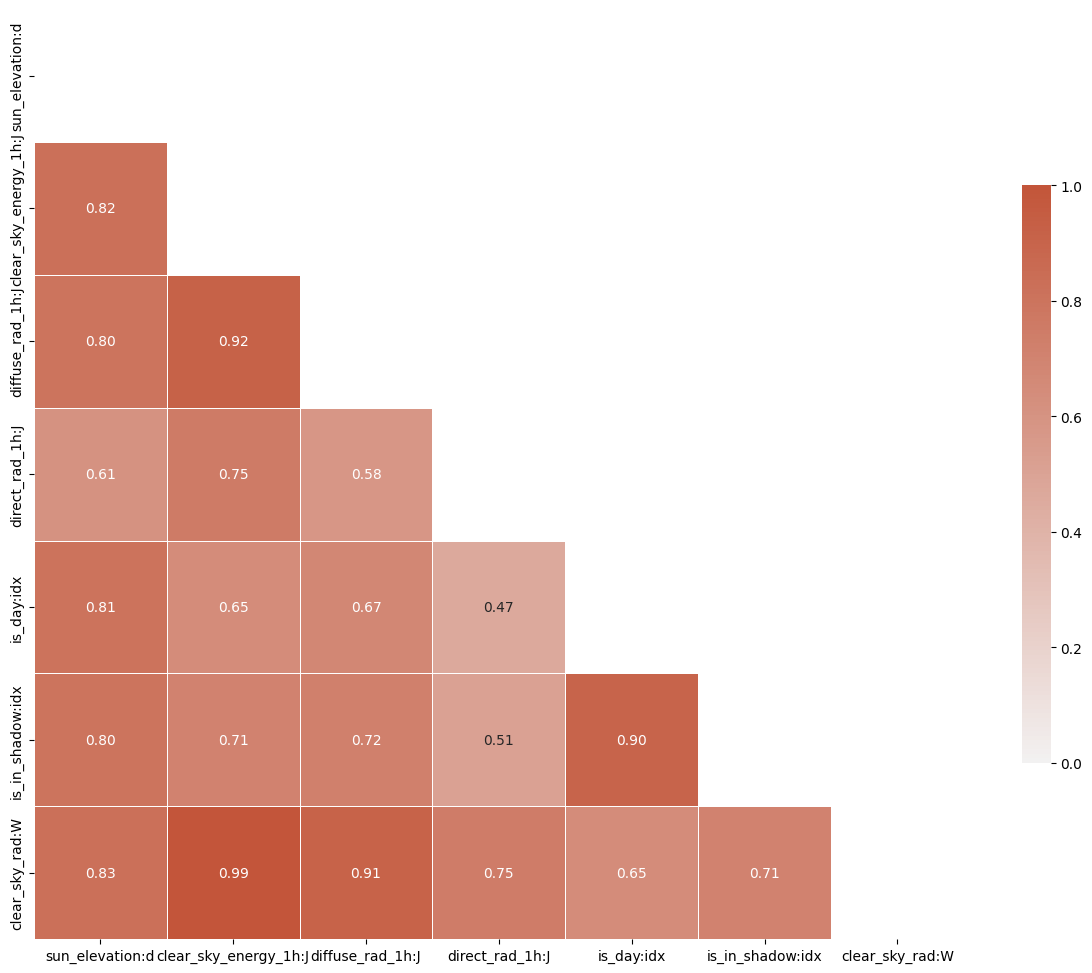

In [28]:
sun_elevation_correlations = ['sun_elevation:d', 'clear_sky_energy_1h:J', 'diffuse_rad_1h:J', 'direct_rad_1h:J', 'is_day:idx', 'is_in_shadow:idx', 'clear_sky_rad:W']

show_corr_matrix_with_values(X[sun_elevation_correlations])

#### Cloud Cover

**total_cloud_cover:p**: cloud cover is the fraction of the sky covered by cloud at any height. Due to overlapping clouds at different heights, it may not correspond to the sum of the low, medium and high cloud covers.

**effective_cloud_cover:p**: cloud cover is a weighted sum of the low, medium and high level cloud covers relevant for solar energy forecasts. The low and medium level clouds have a higher weight than the high level clouds as the low and medium level clouds block more radiation.


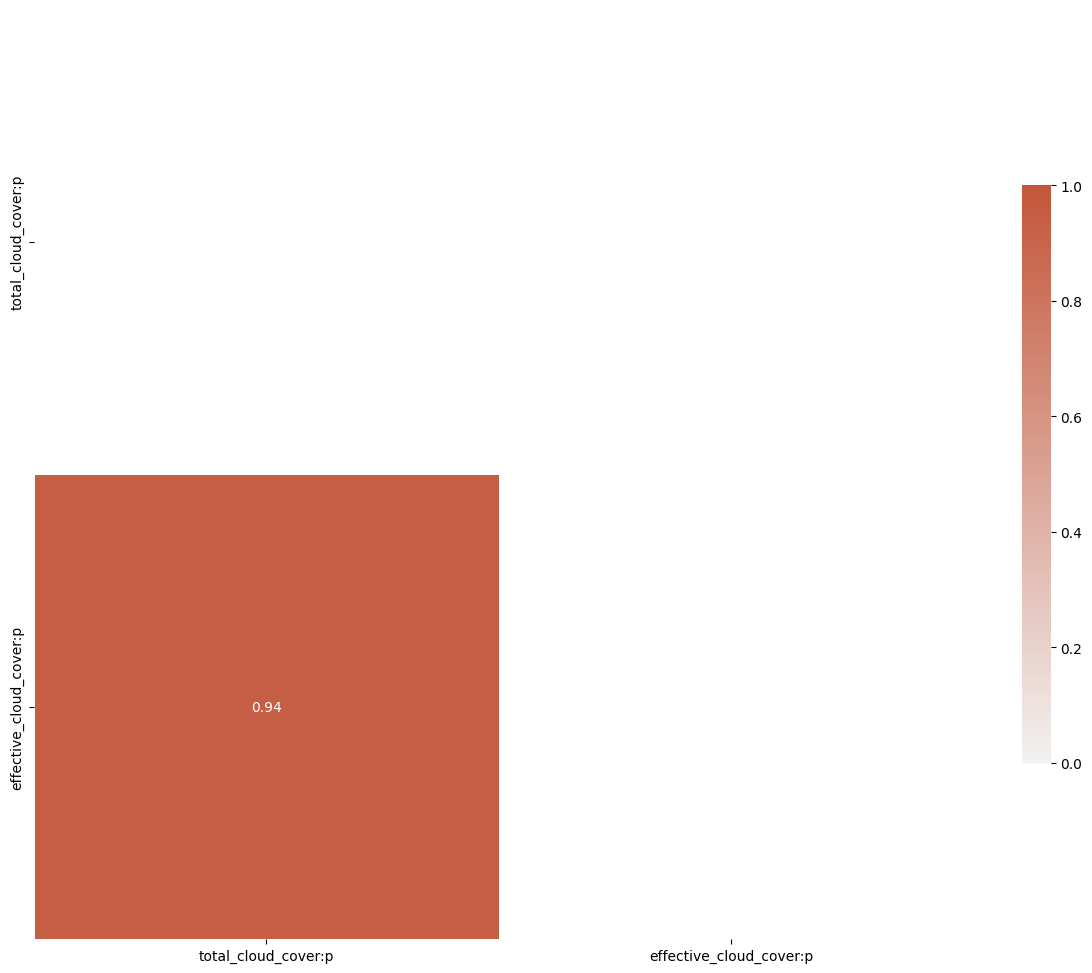

In [29]:
show_corr_matrix_with_values(X[['total_cloud_cover:p', 'effective_cloud_cover:p']])

# 2. Feature Engineering

We had a lot of different trials for feature engineering. On total we have mostly tried removing features, "One hot encoding", gathering features to hourly format. We have tried to create some new features, however this only gave us worse results.

# 3. Predictors

## 3.1 Ensamble of Ensambles (Short_Notebook_1.ipynb)
Removed broken data from B

Upwards weighted on estimated data

## 3.2 Ensamble 2 (Short_Notebook_2.ipynb)

## 3.3 Model 2

In [31]:
#Read dataset
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')
X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')
X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

#add location to each sample
train_a["location"] = "A"
train_b["location"] = "B"
train_c["location"] = "C"
X_train_estimated_a["location"] = "A"
X_train_estimated_b["location"] = "B"
X_train_estimated_c["location"] = "C"
X_train_observed_a["location"] = "A"
X_train_observed_b["location"] = "B"
X_train_observed_c["location"] = "C"

#remove extra minute 00 sample
X_train_observed_a = X_train_observed_a.iloc[:-1,:]
X_train_observed_b = X_train_observed_b.iloc[:-1,:]
X_train_observed_c = X_train_observed_c.iloc[:-1,:]

#add date_calc column same as date_forecast column to observed data
X_train_observed_a.insert(0, "date_calc", X_train_observed_a["date_forecast"])
X_train_observed_b.insert(0, "date_calc", X_train_observed_b["date_forecast"])
X_train_observed_c.insert(0, "date_calc", X_train_observed_c["date_forecast"])

#concat all the samples and remove date_calc column
X_train_raw = pd.concat([X_train_observed_a,
                     X_train_observed_b,
                     X_train_observed_c,
                     X_train_estimated_a,
                     X_train_estimated_b,
                     X_train_estimated_c])

#remove some weird artifacts from train_b target values
train_b = pd.concat([train_b[:18690], train_b[20142:]])
train_b["rolling"] = train_b["pv_measurement"].rolling(4).mean()
train_b["keep"] = train_b["pv_measurement"] - train_b["rolling"] != 0 + train_b["pv_measurement"].apply(lambda a: a==0)
train_b = train_b[train_b["keep"]]
train_b = train_b.iloc[:,:3]

targets = pd.concat([train_a,
                     train_b,
                     train_c]).dropna()

#X_train_raw["date_forecast"] = X_train_raw["date_forecast"] + pd.Timedelta(minutes=-60)

features00 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 0)].copy()
features00["merge_time"] = features00["date_forecast"]


features15 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 15)].copy()
features15["merge_time"] = features15["date_forecast"] + pd.Timedelta(minutes=-15)


features30 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 30)].copy()
features30["merge_time"] = features30["date_forecast"] + pd.Timedelta(minutes=-30)


features45 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 45)].copy()
features45["merge_time"] = features45["date_forecast"] + pd.Timedelta(minutes=-45)


X_train_raw["date_forecast"] = X_train_raw["date_forecast"] + pd.Timedelta(minutes = -60)
features60 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 00)].copy()
features60["merge_time"] = features60["date_forecast"]

dataset = targets
dataset = dataset.rename(columns={"time": "merge_time"})

#averages the features meassured at target time +00, +15, +30, +45 and +60
def add_feature_average_00_60(dataset, f00, f15, f30, f45, f60, column_name):
    dataset = pd.merge(
        left=dataset,
        right = f00[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner")
    dataset = pd.merge(
        left=dataset,
        right = f15[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_15"])
    dataset = pd.merge(
        left=dataset,
        right = f30[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_30"])
    dataset = pd.merge(
        left=dataset,
        right = f45[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_45"])
    dataset = pd.merge(
        left=dataset,
        right = f60[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_60"])


    dataset[column_name] = (dataset[column_name] +
                            dataset[column_name + "_15"] +
                            dataset[column_name + "_30"] +
                            dataset[column_name + "_45"] +
                            dataset[column_name + "_60"])/5
    dataset = dataset.drop([column_name + "_15",
                            column_name + "_30",
                            column_name + "_45",
                            column_name + "_60"],
                           axis=1)

    return dataset

#adds a single feature from one observation
def add_feature(dataset, f, column_name):
  return pd.merge(
        left=dataset,
        right=f[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner"
  )

#adds an One Hot Encoding of the column to the dataset
def OHE(dataset, f, column_name, suffix=""):

    dataset = pd.merge(
        left=dataset,
        right = f[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner")

    values = dataset[column_name].unique()

    for value in values:
        dataset[column_name + "_" + suffix + str(value)] = dataset[column_name].apply(lambda a : a == value).map({True: 1, False: 0})

    dataset = dataset.drop([column_name], axis=1)
    return dataset

def OHE_all(dataset, f00, f15, f30, f45, f60, column_name):
    dataset = OHE(dataset, f00, column_name, suffix="00_")
    dataset = OHE(dataset, f15, column_name, suffix="15_")
    dataset = OHE(dataset, f30, column_name, suffix="30_")
    dataset = OHE(dataset, f45, column_name, suffix="45_")
    dataset = OHE(dataset, f60, column_name, suffix="60_")

    return dataset

#adds all observations
def add_all(dataset, f00, f15, f30, f45, f60, column_name):
    dataset[column_name + "_00"] = add_feature(dataset, f00, column_name)[column_name]
    dataset[column_name + "_15"] = add_feature(dataset, f15, column_name)[column_name]
    dataset[column_name + "_30"] = add_feature(dataset, f30, column_name)[column_name]
    dataset[column_name + "_45"] = add_feature(dataset, f45, column_name)[column_name]
    dataset[column_name + "_60"] = add_feature(dataset, f60, column_name)[column_name]

    return dataset

#gjennomsnitt fordi verdien er trolig momentan og varierer lite
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "absolute_humidity_2m:gm3")

#gjennomsnitt fordi verdien er trolig momentan og varierer lite
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "air_density_2m:kgm3")

#tar verdien fra +60 siden den viser måling mellom 00 og 60
dataset = add_feature(dataset, features60, "clear_sky_energy_1h:J")

#gjennomsnitt fordi verdien er momentan og varierer lite
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "clear_sky_rad:W")

#OHE av kategorisk variabel #!Opp til diskusjon om man skal ta gjennomsnitt eller flere av målingene
dataset = OHE(dataset, features60, "dew_or_rime:idx")

#gjennomsnitt fordi verdien er trolig momentan
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "dew_point_2m:K")

#gjennomsnitt fordi verdien er momentan
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "diffuse_rad:W")

#tar verdi fra +60 siden den viser måling mellom 00 og 60
dataset = add_feature(dataset, features60, "diffuse_rad_1h:J")

#gjennomsnitt fordi verdien er momentan
dataset = add_feature(dataset, features60, "direct_rad:W")#!Try without

#tar verdi fra +60 siden den viser måling mellom 00 og 60
dataset = add_feature(dataset, features60, "direct_rad_1h:J")#!Try without

#gjennomsnitt fordi verdien er trolig momentan
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "effective_cloud_cover:p")

#tar verdi fra +60 siden den viser måling mellom 00 og 60, #!kan det være gunstig å ha med 3h, 6h, 12h, 24h????
dataset = add_feature(dataset, features60, "fresh_snow_1h:cm")

#tar alle verdiene siden disse nok er ekstremt viktige for modellen
dataset = add_all(dataset, features00, features15, features30, features45, features60, "is_day:idx")

#tar alle verdiene siden disse nok er ekstremt viktige for modellen
dataset = add_all(dataset, features00, features15, features30, features45, features60, "is_in_shadow:idx")

#tar gjennomsnittet siden jeg vet ikke +++ #!jeg tar kun med en type måling for trykk, raw data inneholder 4 forskjellige mulig at flere er relevante
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "msl_pressure:hPa")

#tar alle verdier siden måleintervallet er så kort
dataset = add_all(dataset, features00, features15, features30, features45, features60, "precip_5min:mm")
dataset = OHE(dataset, features00, "precip_type_5min:idx")

#tar gjennomsnitt fordi jeg vet ikke #!diskuter
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "prob_rime:p")

#tar gjennomsnitt fordi jeg vet ikke #!diskuter
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "relative_humidity_1000hPa:p")

#OHE because value is binary
dataset = OHE(dataset, features60, "snow_density:kgm3")

#disse tar jeg bare gjennomsnittet av
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_depth:cm")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_drift:idx")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_melt_10min:mm")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_water:kgm2")

#legger til alle siden har testing har vist at disse er svært viktige
dataset = add_all(dataset, features00, features15, features30, features45, features60, "sun_azimuth:d")
dataset = add_all(dataset, features00, features15, features30, features45, features60, "sun_elevation:d")

#gjennomsnitt siden variasjonen hvert kvarter sannsynligvis
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "t_1000hPa:K")

#gjennomsnitt fordi jeg vet ikke
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "total_cloud_cover:p")

#gjennomsnitt fordi jeg vet ikke
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "visibility:m")

#Gjennomsnitt fordi lite variabel
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "wind_speed_u_10m:ms")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "wind_speed_v_10m:ms")

#OHE av location
dataset["location_A"] = dataset["location"].apply(lambda loc: loc == "A").map({True: 1, False: 0})
dataset["location_B"] = dataset["location"].apply(lambda loc: loc == "B").map({True: 1, False: 0})
dataset["location_C"] = dataset["location"].apply(lambda loc: loc == "C").map({True: 1, False: 0})

#dataset["day"] = dataset["merge_time"].apply(lambda a : a.day_of_year)
#dataset["hour"] = dataset["merge_time"].apply(lambda a : a.hour)

dataset["absolute_humidity_2m:gm3"] = dataset["absolute_humidity_2m:gm3"]/dataset["absolute_humidity_2m:gm3"].std()
dataset["clear_sky_energy_1h:J"] = dataset["clear_sky_energy_1h:J"]/dataset["clear_sky_energy_1h:J"].std()
dataset["clear_sky_rad:W"] = dataset["clear_sky_rad:W"]/dataset["clear_sky_rad:W"].std()
dataset["dew_point_2m:K"] = (dataset["dew_point_2m:K"]-dataset["dew_point_2m:K"].min())/dataset["dew_point_2m:K"].std()
dataset["diffuse_rad:W"] = dataset["diffuse_rad:W"]/dataset["diffuse_rad:W"].std()
dataset["diffuse_rad_1h:J"] = dataset["diffuse_rad_1h:J"]/dataset["diffuse_rad_1h:J"].std()
dataset["direct_rad:W"] = dataset["direct_rad:W"]/dataset["direct_rad:W"].std()
dataset["direct_rad_1h:J"] = dataset["direct_rad_1h:J"]/dataset["direct_rad_1h:J"].std()
dataset["effective_cloud_cover:p"] = dataset["effective_cloud_cover:p"]/dataset["effective_cloud_cover:p"].std()
dataset["msl_pressure:hPa"] = (dataset["msl_pressure:hPa"]-dataset["msl_pressure:hPa"].min())/dataset["msl_pressure:hPa"].std()
dataset["prob_rime:p"] = dataset["prob_rime:p"]/dataset["prob_rime:p"].std()
dataset["relative_humidity_1000hPa:p"] = (dataset["relative_humidity_1000hPa:p"])/dataset["relative_humidity_1000hPa:p"].std()



#The sun angle features are transformed to represent how much sunlight will hit a flat surface
#This seems like a more relevant number to pass into the model
#K-fold cross validation also seems to agree with this hypothesis
dataset["sun_azimuth:d_00"] = dataset["sun_azimuth:d_00"].apply(lambda d : np.cos((d*np.pi)/180))
dataset["sun_azimuth:d_00"] = dataset["sun_azimuth:d_00"]/dataset["sun_azimuth:d_00"].std()
dataset["sun_azimuth:d_15"] = dataset["sun_azimuth:d_15"].apply(lambda d : np.cos((d*np.pi)/180))
dataset["sun_azimuth:d_15"] = dataset["sun_azimuth:d_15"]/dataset["sun_azimuth:d_15"].std()
dataset["sun_azimuth:d_30"] = dataset["sun_azimuth:d_30"].apply(lambda d : np.cos((d*np.pi)/180))
dataset["sun_azimuth:d_30"] = dataset["sun_azimuth:d_30"]/dataset["sun_azimuth:d_30"].std()
dataset["sun_azimuth:d_45"] = dataset["sun_azimuth:d_45"].apply(lambda d : np.cos((d*np.pi)/180))
dataset["sun_azimuth:d_45"] = dataset["sun_azimuth:d_45"]/dataset["sun_azimuth:d_45"].std()
dataset["sun_azimuth:d_60"] = dataset["sun_azimuth:d_60"].apply(lambda d : np.cos((d*np.pi)/180))
dataset["sun_azimuth:d_60"] = dataset["sun_azimuth:d_60"]/dataset["sun_azimuth:d_60"].std()

dataset["sun_elevation:d_00"] = dataset["sun_elevation:d_00"].apply(lambda d : np.sin((d*np.pi)/180))
dataset["sun_elevation:d_00"] = dataset["sun_elevation:d_00"]/dataset["sun_elevation:d_00"].std()
dataset["sun_elevation:d_15"] = dataset["sun_elevation:d_15"].apply(lambda d : np.sin((d*np.pi)/180))
dataset["sun_elevation:d_15"] = dataset["sun_elevation:d_15"]/dataset["sun_elevation:d_15"].std()
dataset["sun_elevation:d_30"] = dataset["sun_elevation:d_30"].apply(lambda d : np.sin((d*np.pi)/180))
dataset["sun_elevation:d_30"] = dataset["sun_elevation:d_30"]/dataset["sun_elevation:d_30"].std()
dataset["sun_elevation:d_45"] = dataset["sun_elevation:d_45"].apply(lambda d : np.sin((d*np.pi)/180))
dataset["sun_elevation:d_45"] = dataset["sun_elevation:d_45"]/dataset["sun_elevation:d_45"].std()
dataset["sun_elevation:d_60"] = dataset["sun_elevation:d_60"].apply(lambda d : np.sin((d*np.pi)/180))
dataset["sun_elevation:d_60"] = dataset["sun_elevation:d_60"]/dataset["sun_elevation:d_60"].std()

dataset["t_1000hPa:K"] = (dataset["t_1000hPa:K"]-dataset["t_1000hPa:K"].min())/dataset["t_1000hPa:K"].std()
dataset["total_cloud_cover:p"] = dataset["total_cloud_cover:p"]/dataset["total_cloud_cover:p"].std()
dataset["visibility:m"] = dataset["visibility:m"]/dataset["visibility:m"].std()
dataset["wind_speed_u_10m:ms"] = dataset["wind_speed_u_10m:ms"]/dataset["wind_speed_u_10m:ms"].std()
dataset["wind_speed_v_10m:ms"] = dataset["wind_speed_v_10m:ms"]/dataset["wind_speed_v_10m:ms"].std()
#dataset["day"] = 10*dataset["day"]/dataset["day"].std()
#dataset["hour"] = dataset["hour"]/dataset["hour"].std()
dataset = dataset.sort_values(by="merge_time")

datasetX = dataset.iloc[:, 3:]
datasetY = dataset.iloc[:, 1]

display(datasetX)
display(datasetY)

def evaluate_models(models, X, Y):
    preds = X.iloc[:,1:2]

    for i in range(len(models)):
        preds[str(i)] = models[i].predict(X)


    preds = preds.iloc[:,1:]


    preds["final"] = preds.mean(axis=1)
    preds["losses"] = (preds["final"] - Y).apply(lambda a : np.abs(a))
    return preds["losses"].mean()


num_folds = 9

losses = []
models = []

for f in range(0, num_folds):
  evalIndex=f*10000
  evalSize=10000

  #partition into training and evalset
  trainsetX = pd.concat([datasetX.iloc[:evalIndex,:],datasetX.iloc[evalIndex+evalSize:,:]])
  trainsetY = pd.concat([datasetY.iloc[:evalIndex],datasetY.iloc[evalIndex+evalSize:]])
  evalsetX = datasetX.iloc[evalIndex:evalIndex+evalSize,:]
  evalsetY = datasetY.iloc[evalIndex:evalIndex+evalSize]

  numModels = 16

  models = []



  i = 0
  while(i < numModels):
    if(i < 8):
      models.append(tf.keras.models.Sequential([
            #tf.keras.layers.GaussianNoise(stddev=0.1, seed=42),
            tf.keras.layers.Dense(50, activation="tanh",
              kernel_initializer=tf.keras.initializers.RandomUniform(-1, 1),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(50, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal()),
            tf.keras.layers.Dense(1, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal()),
        ]))
    else:
      models.append(tf.keras.models.Sequential([
            #tf.keras.layers.GaussianNoise(stddev=0.1, seed=42),
            tf.keras.layers.Dense(60, activation="tanh",
              kernel_initializer=tf.keras.initializers.RandomUniform(-1, 1),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(50, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(40, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(30, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(10, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(1, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
        ]))
    models[i].compile(
        optimizer=tf.keras.optimizers.experimental.Adadelta(learning_rate=1,
                                                            #weight_decay=0.0001
                                                            ),
        loss="mean_absolute_error"
    )

    history = models[i].fit(
                        x = trainsetX.sample(frac=0.8 if i < 8 else 0.8, random_state=i),
                        y = trainsetY.sample(frac=0.8 if i < 8 else 0.8, random_state=i),
                        batch_size = 1000,
                        epochs = 1,
                        verbose = 0,
                        #validation_data = [evalsetX, evalsetY]
                    )

    #retry if model is nonsensical
    loss = models[i].evaluate(evalsetX, evalsetY, verbose=0)
    if(loss < evalsetY.mean() + 4 and loss > evalsetY.mean() - 4):
      print("discarding")
      del models[i]
      continue

    history = models[i].fit(
                        x = trainsetX.sample(frac=0.65 if i < 8 else 0.65, random_state=i),
                        y = trainsetY.sample(frac=0.65 if i < 8 else 0.65, random_state=i),
                        batch_size = 1000,
                        epochs = 40,
                        verbose = 0,
                        validation_data = [evalsetX, evalsetY]
                    )
    loss = models[i].evaluate(evalsetX, evalsetY)
    print(i, " complete")
    i+=1

  loss = evaluate_models(models, evalsetX, evalsetY)
  print(loss)
  losses.append(loss)

print(losses)



absolute_humidity_2m:gm3  air_density_2m:kgm3  clear_sky_energy_1h:J  \
34058                  2.040314               1.2400                    0.0   
34059                  2.018056               1.2394                    0.0   
34060                  1.995798               1.2388                    0.0   
34061                  1.995798               1.2396                    0.0   
34062                  2.129346               1.2370                    0.0   
...                         ...                  ...                    ...   
34056                  1.669348               1.2810                    0.0   
88797                  1.632252               1.2790                    0.0   
34057                  1.669348               1.2810                    0.0   
62729                  1.669348               1.2800                    0.0   
88798                  1.632252               1.2798                    0.0   

       clear_sky_rad:W  dew_or_rime:idx_0.0  dew_or_rime:idx_1.0  \
34058              0.0                    1                    0   
34059              0.0                    1                    0   
34060              0.0                    1                    0   
34061              0.0                    1                    0   
34062              0.0                    1                    0   
...                ...                  ...                  ...   
34056              0.0                    1                    0   
88797              0.0                    1                    0   
34057              0.0                    1                    0   
62729              0.0                    1                    0   
88798              0.0                    1                    0   

       dew_or_rime:idx_-1.0  dew_point_2m:K  diffuse_rad:W  diffuse_rad_1h:J  \
34058                     0        4.047516            0.0               0.0   
34059                     0        4.018253            0.0               0.0   
34060                     0        4.000694            0.0               0.0   
34061                     0        4.000690            0.0               0.0   
34062                     0        4.135316            0.0               0.0   
...                     ...             ...            ...               ...   
34056                     0        3.643641            0.0               0.0   
88797                     0        3.585110            0.0               0.0   
34057                     0        3.640712            0.0               0.0   
62729                     0        3.637791            0.0               0.0   
88798                     0        3.593894            0.0               0.0   

       direct_rad:W  direct_rad_1h:J  effective_cloud_cover:p  \
34058           0.0              0.0                 2.482328   
34059           0.0              0.0                 2.837112   
34060           0.0              0.0                 2.817856   
34061           0.0              0.0                 2.827776   
34062           0.0              0.0                 2.813771   
...             ...              ...                      ...   
34056           0.0              0.0                 2.758336   
88797           0.0              0.0                 2.755419   
34057           0.0              0.0                 2.865705   
62729           0.0              0.0                 2.865122   
88798           0.0              0.0                 2.879710   

       fresh_snow_1h:cm  is_day:idx_00  is_day:idx_15  is_day:idx_30  \
34058               0.0            0.0            0.0            0.0   
34059               0.0            0.0            0.0            0.0   
34060               0.0            0.0            0.0            0.0   
34061               0.0            0.0            0.0            0.0   
34062               0.0            0.0            0.0            0.0   
...                 ...            ...            ...            ..

34058    0.0
34059    0.0
34060    0.0
34061    0.0
34062    0.0
        ... 
34056    0.0
88797    0.0
34057    0.0
62729   -0.0
88798   -0.0
Name: pv_measurement, Length: 88799, dtype: float64

313/313 [==============================] - 0s 279us/step - loss: 118.7089


0  complete
313/313 [==============================] - 0s 271us/step - loss: 118.1027


1  complete
313/313 [==============================] - 0s 268us/step - loss: 119.1662


2  complete
313/313 [==============================] - 0s 267us/step - loss: 118.5144


3  complete
313/313 [==============================] - 0s 270us/step - loss: 121.0761


4  complete
313/313 [==============================] - 0s 264us/step - loss: 122.3480


5  complete
313/313 [==============================] - 0s 269us/step - loss: 120.3377


6  complete
313/313 [==============================] - 0s 332us/step - loss: 121.3169


7  complete


discarding


discarding
313/313 [==============================] - 0s 336us/step - loss: 117.9030


8  complete


discarding
313/313 [==============================] - 0s 339us/step - loss: 118.1434


9  complete


discarding
313/313 [==============================] - 0s 283us/step - loss: 116.2414


10  complete
313/313 [==============================] - 0s 349us/step - loss: 117.1460


11  complete
313/313 [==============================] - 0s 343us/step - loss: 122.9591


12  complete


discarding
313/313 [==============================] - 0s 294us/step - loss: 118.2719


13  complete
313/313 [==============================] - 0s 349us/step - loss: 121.8958


14  complete


discarding


discarding
313/313 [==============================] - 0s 344us/step - loss: 125.2877
15  complete
  1/313 [..............................] - ETA: 5s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 251us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 6s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 6s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 288us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 290us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 287us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 7s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 296us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


115.5204987154359
313/313 [==============================] - 0s 266us/step - loss: 29.6186


0  complete


discarding
313/313 [==============================] - 0s 326us/step - loss: 29.6474


1  complete
313/313 [==============================] - 0s 322us/step - loss: 30.2349


2  complete
313/313 [==============================] - 0s 313us/step - loss: 31.0207


3  complete
313/313 [==============================] - 0s 327us/step - loss: 31.1984


4  complete
313/313 [==============================] - 0s 324us/step - loss: 30.3453


5  complete
313/313 [==============================] - 0s 333us/step - loss: 31.6854


6  complete
313/313 [==============================] - 0s 329us/step - loss: 30.1843


7  complete
313/313 [==============================] - 0s 341us/step - loss: 31.3289


8  complete
313/313 [==============================] - 0s 447us/step - loss: 27.9494


9  complete


discarding


discarding
313/313 [==============================] - 0s 352us/step - loss: 29.7656


10  complete
313/313 [==============================] - 0s 288us/step - loss: 29.8429


11  complete
313/313 [==============================] - 0s 291us/step - loss: 29.0698


12  complete
313/313 [==============================] - 0s 288us/step - loss: 30.9148


13  complete
313/313 [==============================] - 0s 284us/step - loss: 30.0850


14  complete
313/313 [==============================] - 0s 287us/step - loss: 29.9029
15  complete
  1/313 [..............................] - ETA: 5s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 5s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 5s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 7s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 7s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 7s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 283us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 280us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


29.249541061848856
313/313 [==============================] - 0s 317us/step - loss: 130.6646


0  complete
313/313 [==============================] - 0s 328us/step - loss: 133.0890


1  complete
313/313 [==============================] - 0s 324us/step - loss: 129.3177


2  complete
313/313 [==============================] - 0s 265us/step - loss: 130.5142


3  complete
313/313 [==============================] - 0s 261us/step - loss: 132.4591


4  complete
313/313 [==============================] - 0s 263us/step - loss: 131.1998


5  complete
313/313 [==============================] - 0s 260us/step - loss: 130.6584


6  complete
313/313 [==============================] - 0s 262us/step - loss: 132.4797


7  complete
313/313 [==============================] - 0s 303us/step - loss: 126.9060


8  complete


discarding
313/313 [==============================] - 0s 348us/step - loss: 128.4317


9  complete


discarding
313/313 [==============================] - 0s 342us/step - loss: 128.1973


10  complete
313/313 [==============================] - 0s 295us/step - loss: 129.5686


11  complete


discarding
313/313 [==============================] - 0s 339us/step - loss: 128.0114


12  complete
313/313 [==============================] - 0s 291us/step - loss: 134.8441


13  complete


discarding
313/313 [==============================] - 0s 346us/step - loss: 128.4188


14  complete


discarding
313/313 [==============================] - 0s 345us/step - loss: 132.3154
15  complete
  1/313 [..............................] - ETA: 5s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 5s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 5s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 7s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 7s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 7s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 347us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 285us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


124.99881918395525
313/313 [==============================] - 0s 321us/step - loss: 83.8376


0  complete
313/313 [==============================] - 0s 268us/step - loss: 83.1416


1  complete
313/313 [==============================] - 0s 264us/step - loss: 83.1542


2  complete
313/313 [==============================] - 0s 277us/step - loss: 83.3013


3  complete
313/313 [==============================] - 0s 322us/step - loss: 82.4864


4  complete
313/313 [==============================] - 0s 272us/step - loss: 82.9670


5  complete
313/313 [==============================] - 0s 264us/step - loss: 83.3860


6  complete
313/313 [==============================] - 0s 267us/step - loss: 83.1823


7  complete
313/313 [==============================] - 0s 292us/step - loss: 84.7874


8  complete
313/313 [==============================] - 0s 292us/step - loss: 82.4150


9  complete
313/313 [==============================] - 0s 290us/step - loss: 81.8494


10  complete


discarding
313/313 [==============================] - 0s 349us/step - loss: 84.5321


11  complete


discarding
313/313 [==============================] - 0s 350us/step - loss: 81.4709


12  complete
313/313 [==============================] - 0s 305us/step - loss: 81.6192


13  complete


discarding
313/313 [==============================] - 0s 367us/step - loss: 84.2287


14  complete
313/313 [==============================] - 0s 305us/step - loss: 81.1708
15  complete
  1/313 [..............................] - ETA: 6s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 6s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 6s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 8s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 292us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 290us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 290us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 293us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


80.37194119297307
313/313 [==============================] - 0s 334us/step - loss: 75.9825


0  complete
313/313 [==============================] - 0s 270us/step - loss: 76.2777


1  complete
313/313 [==============================] - 0s 271us/step - loss: 75.4784


2  complete
313/313 [==============================] - 0s 268us/step - loss: 75.9906


3  complete
313/313 [==============================] - 0s 269us/step - loss: 76.4882


4  complete
313/313 [==============================] - 0s 263us/step - loss: 75.9699


5  complete


discarding
313/313 [==============================] - 0s 328us/step - loss: 76.6431


6  complete
313/313 [==============================] - 0s 263us/step - loss: 75.9589


7  complete
313/313 [==============================] - 0s 292us/step - loss: 76.2493


8  complete
313/313 [==============================] - 0s 293us/step - loss: 77.8387


9  complete
313/313 [==============================] - 0s 293us/step - loss: 78.0189


10  complete
313/313 [==============================] - 0s 293us/step - loss: 78.1565


11  complete
313/313 [==============================] - 0s 293us/step - loss: 76.6470


12  complete
313/313 [==============================] - 0s 289us/step - loss: 76.9898


13  complete
313/313 [==============================] - 0s 288us/step - loss: 77.7848


14  complete
313/313 [==============================] - 0s 290us/step - loss: 77.1217
15  complete
  1/313 [..............................] - ETA: 5s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 5s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 6s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 7s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 7s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 7s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 292us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 283us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


73.97895645715087
313/313 [==============================] - 0s 264us/step - loss: 123.1439


0  complete


discarding
313/313 [==============================] - 0s 269us/step - loss: 125.3444


1  complete
313/313 [==============================] - 0s 266us/step - loss: 124.7023


2  complete
313/313 [==============================] - 0s 264us/step - loss: 125.4036


3  complete
313/313 [==============================] - 0s 270us/step - loss: 122.4685


4  complete
313/313 [==============================] - 0s 265us/step - loss: 125.0475


5  complete
313/313 [==============================] - 0s 262us/step - loss: 122.7013


6  complete


discarding
313/313 [==============================] - 0s 267us/step - loss: 125.7932


7  complete
313/313 [==============================] - 0s 354us/step - loss: 122.2070


8  complete
313/313 [==============================] - 0s 362us/step - loss: 126.0414


9  complete
313/313 [==============================] - 0s 358us/step - loss: 126.1386


10  complete
313/313 [==============================] - 0s 287us/step - loss: 126.5405


11  complete
313/313 [==============================] - 0s 291us/step - loss: 125.6247


12  complete
313/313 [==============================] - 0s 289us/step - loss: 123.3197


13  complete
313/313 [==============================] - 0s 291us/step - loss: 122.6315


14  complete
313/313 [==============================] - 0s 291us/step - loss: 125.8012
15  complete
  1/313 [..............................] - ETA: 5s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 5s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 5s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 7s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 7s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 294us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 7s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 281us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


119.81129685821274


discarding


discarding


discarding


discarding
313/313 [==============================] - 0s 269us/step - loss: 19.4569


0  complete
313/313 [==============================] - 0s 321us/step - loss: 18.9169


1  complete


discarding
313/313 [==============================] - 0s 330us/step - loss: 20.0901


2  complete


discarding
313/313 [==============================] - 0s 333us/step - loss: 19.6881


3  complete


discarding


discarding
313/313 [==============================] - 0s 276us/step - loss: 19.6331


4  complete


discarding
313/313 [==============================] - 0s 272us/step - loss: 19.6759


5  complete


discarding
313/313 [==============================] - 0s 269us/step - loss: 19.4218


6  complete


discarding
313/313 [==============================] - 0s 327us/step - loss: 19.8433


7  complete


discarding


discarding


discarding
313/313 [==============================] - 0s 356us/step - loss: 20.6656


8  complete


discarding


discarding


discarding
313/313 [==============================] - 0s 299us/step - loss: 20.8691


9  complete


discarding


discarding
313/313 [==============================] - 0s 371us/step - loss: 19.7280


10  complete


discarding
313/313 [==============================] - 0s 371us/step - loss: 19.7919


11  complete


discarding
313/313 [==============================] - 0s 381us/step - loss: 20.1258


12  complete


discarding


discarding


discarding
313/313 [==============================] - 0s 295us/step - loss: 20.3641


13  complete


discarding


discarding


discarding
313/313 [==============================] - 0s 295us/step - loss: 19.3906


14  complete


discarding


discarding


discarding


discarding
313/313 [==============================] - 0s 366us/step - loss: 18.7957
15  complete
  1/313 [..............................] - ETA: 6s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 5s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 5s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 8s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 7s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 7s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 8s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 282us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


18.98169911217941


discarding
313/313 [==============================] - 0s 341us/step - loss: 163.8073


0  complete
313/313 [==============================] - 0s 267us/step - loss: 162.9624


1  complete
313/313 [==============================] - 0s 336us/step - loss: 166.0370


2  complete
313/313 [==============================] - 0s 337us/step - loss: 162.6149


3  complete
313/313 [==============================] - 0s 341us/step - loss: 164.8679


4  complete
313/313 [==============================] - 0s 350us/step - loss: 164.5346


5  complete


discarding
313/313 [==============================] - 0s 342us/step - loss: 164.4650


6  complete
313/313 [==============================] - 0s 348us/step - loss: 162.9407


7  complete
313/313 [==============================] - 0s 366us/step - loss: 164.3478


8  complete
313/313 [==============================] - 0s 359us/step - loss: 162.1727


9  complete


discarding


discarding
313/313 [==============================] - 0s 377us/step - loss: 163.8034


10  complete
313/313 [==============================] - 0s 379us/step - loss: 171.5497


11  complete
313/313 [==============================] - 0s 397us/step - loss: 166.6361


12  complete
313/313 [==============================] - 0s 430us/step - loss: 165.9206


13  complete
313/313 [==============================] - 0s 406us/step - loss: 163.0765


14  complete


discarding
313/313 [==============================] - 0s 302us/step - loss: 165.0608
15  complete
  1/313 [..............................] - ETA: 6s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 6s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 6s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 8s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 284us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/313 [..............................] - ETA: 8s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 283us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 276us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


159.52863273182953
275/275 [==============================] - 0s 384us/step - loss: 62.2473


0  complete
275/275 [==============================] - 0s 373us/step - loss: 62.8776


1  complete
275/275 [==============================] - 0s 396us/step - loss: 62.9503


2  complete
275/275 [==============================] - 0s 386us/step - loss: 61.4378


3  complete
275/275 [==============================] - 0s 387us/step - loss: 63.0288


4  complete
275/275 [==============================] - 0s 396us/step - loss: 60.7695


5  complete
275/275 [==============================] - 0s 414us/step - loss: 61.8556


6  complete
275/275 [==============================] - 0s 358us/step - loss: 61.3313


7  complete
275/275 [==============================] - 0s 313us/step - loss: 59.2431


8  complete
275/275 [==============================] - 0s 400us/step - loss: 60.8875


9  complete
275/275 [==============================] - 0s 384us/step - loss: 62.9880


10  complete
275/275 [==============================] - 0s 315us/step - loss: 60.5386


11  complete
275/275 [==============================] - 0s 393us/step - loss: 62.4638


12  complete
275/275 [==============================] - 0s 394us/step - loss: 61.4082


13  complete
275/275 [==============================] - 0s 399us/step - loss: 62.6090


14  complete
275/275 [==============================] - 0s 393us/step - loss: 61.4354
15  complete
  1/275 [..............................] - ETA: 5s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/275 [..............................] - ETA: 5s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/275 [..............................] - ETA: 5s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/275 [..............................] - ETA: 7s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/275 [..............................] - ETA: 7s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/275 [..............................] - ETA: 7s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/275 [..............................] - ETA: 7s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


275/275 [==============================] - 0s 272us/step
58.87853057894358
[115.5204987154359, 29.249541061848856, 124.99881918395525, 80.37194119297307, 73.97895645715087, 119.81129685821274, 18.98169911217941, 159.52863273182953, 58.87853057894358]


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/2172246176.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


### 3.4 AutoGloun

Note: Due to incompatible Python version Autogluon isn't run in this notebook.

In [44]:
import autogluon
from sklearn.preprocessing import StandardScaler


#Read datasets
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')
X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')
X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')
#Read test datasets
X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')


# Calculate the difference between consecutive measurements
train_b['diff'] = train_b['pv_measurement'].diff()

# Identify intervals where the difference is zero and the measurement is not 0.0
constant_intervals_B = train_b[(train_b['diff'] == 0) & (train_b['pv_measurement'] != 0) & (train_b['pv_measurement'].notna())]

# Group these intervals and count their lengths
grouped_intervals_B = (constant_intervals_B
                       .assign(group=(constant_intervals_B['time'].diff() != pd.Timedelta(hours=1)).cumsum())
                       .groupby('group')
                       .agg(start_time=('time', 'first'), end_time=('time', 'last'), count=('time', 'count'), constant_value=('pv_measurement', 'first'))
                       .reset_index(drop=True))

# Filter out short intervals (e.g., less than 3 hours) as they might not be considered "broken"
long_constant_intervals_B = grouped_intervals_B[grouped_intervals_B['count'] >= 3]

#long_constant_intervals_B.head(200)  # Display the first few rows of long constant intervals in B



def replace_with_values_from_C(train_b, train_c, constant_intervals):
    train_b_copy = train_b.copy()
    """
    Replace values in dataset B's constant intervals with corresponding values from dataset C.

    :param train_b: DataFrame for dataset B.
    :param train_c: DataFrame for dataset C.
    :param constant_intervals: DataFrame with constant intervals in B to be replaced.
    :return: Modified dataset B with values replaced from C.
    """
    for index, row in constant_intervals.iterrows():
        start_time, end_time = row['start_time'], row['end_time']

        # Iterate through each timestamp within the interval
        for time in pd.date_range(start=start_time, end=end_time, freq='H'):
            # Check if there's a corresponding timestamp in C
            if time in train_c['time'].values:
                # Replace the value in B with the value from C
                value_C = train_c.loc[train_c['time'] == time, 'pv_measurement'].values[0]
                train_b_copy.loc[train_b_copy['time'] == time, 'pv_measurement'] = value_C


    # Replace the constant 0.0 values from line 19140 to 20143 in dataset B with the values from the same timestamp in dataset C.

    # Iterate through each timestamp within the interval
    for time in pd.date_range(start='2021-03-08 15:00:00', end='2021-04-19 11:00:00', freq='H'):
        # Check if there's a corresponding timestamp in C
        if time in train_c['time'].values:
            # Replace the value in B with the value from C
            value_C = train_c.loc[train_c['time'] == time, 'pv_measurement'].values[0]
            train_b_copy.loc[train_b_copy['time'] == time, 'pv_measurement'] = value_C

    return train_b_copy

# Replace values in dataset B using dataset C for the identified constant intervals
train_b_modified = replace_with_values_from_C(train_b, train_c, long_constant_intervals_B)

display(train_b)
display(train_b_modified)

train_b = train_b_modified.drop(columns=['diff'])

# fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
# axs[0].plot(train_b_modified['time'], train_b_modified['pv_measurement'])
# axs[0].set_title('Dataset B (Modified)')
# axs[1].plot(train_c['time'], train_c['pv_measurement'])
# axs[1].set_title('Dataset C')
# axs[2].plot(train_b['time'], train_b['pv_measurement'])
# axs[2].set_title('Dataset B')
# plt.show()


train_b.head()


mask_a = X_train_observed_a['date_forecast'] < '2020-03-26'
mask_b = X_train_observed_b['date_forecast'] < '2020-03-26'
mask_c = X_train_observed_c['date_forecast'] < '2020-03-26'

# Apply the conversion from meters to feet (1 meter = 3.28084 feet)
conversion_factor = 3.28084

X_train_observed_a.loc[mask_a, 'ceiling_height_agl:m'] *= conversion_factor
X_train_observed_b.loc[mask_b, 'ceiling_height_agl:m'] *= conversion_factor
X_train_observed_c.loc[mask_c, 'ceiling_height_agl:m'] *= conversion_factor

X_train_observed_a.loc[mask_a, 'cloud_base_agl:m'] *= conversion_factor
X_train_observed_b.loc[mask_b, 'cloud_base_agl:m'] *= conversion_factor
X_train_observed_c.loc[mask_c, 'cloud_base_agl:m'] *= conversion_factor



#add location to each sample
train_a["location"] = "A"
train_b["location"] = "B"
train_c["location"] = "C"
X_train_estimated_a["location"] = "A"
X_train_estimated_b["location"] = "B"
X_train_estimated_c["location"] = "C"
X_train_observed_a["location"] = "A"
X_train_observed_b["location"] = "B"
X_train_observed_c["location"] = "C"
X_test_estimated_a["location"] = "A"
X_test_estimated_b["location"] = "B"
X_test_estimated_c["location"] = "C"

#copy 23:45 value to 00:00 as it isn't there
def fill_last(frame):
    copy = frame.copy()

    copy['date_forecast'] = pd.to_datetime(copy['date_forecast'])
    
    copy["date_forecast"] = copy["date_forecast"] + pd.Timedelta(minutes=15)
    
    copy = copy[copy["date_forecast"].apply(lambda time : time.hour == 00 and time.minute == 00)]

    copy = copy[frame.columns]
    
    frame = pd.concat([
        frame,
        copy.astype(frame.dtypes)
    ],)

    frame = frame.drop_duplicates(subset="date_forecast", keep="first")

    return frame

#fill last
X_test_estimated_a = fill_last(X_test_estimated_a.copy())
X_test_estimated_b = fill_last(X_test_estimated_b.copy())
X_test_estimated_c = fill_last(X_test_estimated_c.copy())

#remove extra minute 00 sample
X_train_observed_a = X_train_observed_a.iloc[:-1,:]
X_train_observed_b = X_train_observed_b.iloc[:-1,:]
X_train_observed_c = X_train_observed_c.iloc[:-1,:]

#add date_calc column same as date_forecast column to observed data
X_train_observed_a.insert(0, "date_calc", X_train_observed_a["date_forecast"])
X_train_observed_b.insert(0, "date_calc", X_train_observed_b["date_forecast"])
X_train_observed_c.insert(0, "date_calc", X_train_observed_c["date_forecast"])

#concat all the samples and remove date_calc column
X_train_raw = pd.concat([X_train_observed_a,
                     X_train_observed_b,
                     X_train_observed_c,
                     X_train_estimated_a,
                     X_train_estimated_b,
                     X_train_estimated_c,
                     X_test_estimated_a,
                     X_test_estimated_b,
                     X_test_estimated_c])




# ************* CLEAN AND PREPROCESS DATA *************


#map snow density to one and zero
X_train_raw["snow_density:kgm3"] = X_train_raw["snow_density:kgm3"].apply(lambda a : np.isnan(a)).map({True: 0, False: 1})

#fix ceiling_height NaN values to -666 because the docs hints to it
#also rename the features with their proper metric and remove the old ones
X_train_raw["ceiling_height_agl:ft"] = X_train_raw["ceiling_height_agl:m"].fillna(-666)
X_train_raw["cloud_base_agl:ft"] = X_train_raw["cloud_base_agl:m"].fillna(-666)
X_train_raw.drop(columns=["ceiling_height_agl:m", "cloud_base_agl:m"], inplace=True)

#categorizing ceiling_height_agl:ft
#found categories on google
X_train_raw['ceiling_height_agl:ft'] = pd.cut(X_train_raw['ceiling_height_agl:ft'], bins=[float('-inf'), 0, 500, 1000, 3000, 5000, 12000, float('inf')], labels=[-666, 1, 2, 3, 4, 5, 6])

#decided to drop cloud_base_agl:ft because of high correlation to ceiling_height_agl:ft
X_train_raw.drop(columns=["cloud_base_agl:ft"], inplace=True)

#categorizing dew_or_rime:idx
dew_or_rime_categories = {
    -1.0: "Rime",
    0.0: "None",
    1.0: "Dew"
}
X_train_raw['dew_or_rime:idx'] = X_train_raw['dew_or_rime:idx'].map(dew_or_rime_categories)

#casting floats to int for categorical features
X_train_raw['is_day:idx'] = X_train_raw['is_day:idx'].astype(int)

#remove some weird artifacts from train_b target values
train_b = pd.concat([train_b[:18690], train_b[20142:]])
train_b["rolling"] = train_b["pv_measurement"].rolling(4).mean()
train_b["keep"] = train_b["pv_measurement"] - train_b["rolling"] != 0 + train_b["pv_measurement"].apply(lambda a: a==0)
train_b = train_b[train_b["keep"]]
train_b = train_b.iloc[:,:3]

parse_dates = ['time']
X_test_targets = pd.read_csv("test.csv", parse_dates=parse_dates)

train_a["id"] = -10
train_b["id"] = -10
train_c["id"] = -10

X_test_targets = X_test_targets.rename(columns = {"prediction" : "pv_measurement"})

targets = pd.concat([train_a,
                     train_b.astype(train_a.dtypes),
                     train_c.astype(train_a.dtypes),
                     X_test_targets.astype(train_a.dtypes)]).dropna()






features00 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 0)].copy()
features00["merge_time"] = features00["date_forecast"]


features15 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 15)].copy()
features15["merge_time"] = features15["date_forecast"] + pd.Timedelta(minutes=-15)


features30 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 30)].copy()
features30["merge_time"] = features30["date_forecast"] + pd.Timedelta(minutes=-30)


features45 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 45)].copy()
features45["merge_time"] = features45["date_forecast"] + pd.Timedelta(minutes=-45)


X_train_raw["date_forecast"] = X_train_raw["date_forecast"] + pd.Timedelta(minutes = -60)
features60 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 00)].copy()
features60["merge_time"] = features60["date_forecast"]

dataset = targets
dataset = dataset.rename(columns={"time": "merge_time"})

display(X_train_raw)



# ************* DEFINE HELPER FUNCTIONS *************



#averages the features meassured at target time +00, +15, +30, +45 and +60
def add_feature_average_00_60(dataset, f00, f15, f30, f45, f60, column_name, categorical=False):
    dataset = pd.merge(
        left=dataset,
        right = f00[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner")
    dataset = pd.merge(
        left=dataset,
        right = f15[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_15"])
    dataset = pd.merge(
        left=dataset,
        right = f30[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_30"])
    dataset = pd.merge(
        left=dataset,
        right = f45[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_45"])
    dataset = pd.merge(
        left=dataset,
        right = f60[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_60"])


    dataset[column_name] = (dataset[column_name] +
                            dataset[column_name + "_15"] +
                            dataset[column_name + "_30"] +
                            dataset[column_name + "_45"] +
                            dataset[column_name + "_60"])/5
    dataset = dataset.drop([column_name + "_15",
                            column_name + "_30",
                            column_name + "_45",
                            column_name + "_60"],
                           axis=1)
    if categorical:
        add_to_categorical_features(column_name)
    else:
        add_to_numerical_features(column_name)

    return dataset

#adds a single feature from one observation
def add_feature(dataset, f, column_name, count=True, categorical=False):
    if count:
        if categorical:
            add_to_categorical_features(column_name)
        else:
            add_to_numerical_features(column_name)
    return pd.merge(
            left=dataset,
            right=f[["location", "merge_time", column_name]],
            on=["location", "merge_time"],
            how="inner"
  )

#adds an One Hot Encoding of the column to the dataset
def OHE(dataset, f, column_name, suffix=""):

    dataset = pd.merge(
        left=dataset,
        right = f[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner")

    values = dataset[column_name].unique()

    for value in values:
        dataset[column_name + "_" + suffix + str(value)] = dataset[column_name].apply(lambda a : a == value).map({True: 1, False: 0})

    dataset = dataset.drop([column_name], axis=1)
    return dataset

def OHE_all(dataset, f00, f15, f30, f45, f60, column_name):
    dataset = OHE(dataset, f00, column_name, suffix="00_")
    dataset = OHE(dataset, f15, column_name, suffix="15_")
    dataset = OHE(dataset, f30, column_name, suffix="30_")
    dataset = OHE(dataset, f45, column_name, suffix="45_")
    dataset = OHE(dataset, f60, column_name, suffix="60_")

    return dataset

#adds all observations
def add_all(dataset, f00, f15, f30, f45, f60, column_name, categorical=False):
    dataset[column_name + "_00"] = add_feature(dataset, f00, column_name, count=False,categorical=categorical)[column_name]
    dataset[column_name + "_15"] = add_feature(dataset, f15, column_name, count=False, categorical=categorical)[column_name]
    dataset[column_name + "_30"] = add_feature(dataset, f30, column_name, count=False, categorical=categorical)[column_name]
    dataset[column_name + "_45"] = add_feature(dataset, f45, column_name, count=False, categorical=categorical)[column_name]
    dataset[column_name + "_60"] = add_feature(dataset, f60, column_name, count=False, categorical=categorical)[column_name]

    feature_names = [column_name + "_00", column_name + "_15", column_name + "_30", column_name + "_45", column_name + "_60"]
    for feat in feature_names:
        if categorical:
            add_to_categorical_features(feat)
        else:
            add_to_numerical_features(feat)

    return dataset

#finds mode (typetall) for a row
def find_mode_with_priority(row, priority_list, max=False):
    # Check for prioritized values in the row and set it as the mode if it is
    for value in priority_list:
        if value in row.values:
            return value

    # Calculate the mode for the row
    if max:
        mode_value = row.mode().max()
    else:
        mode_value = row.mode().min()

    return mode_value

def add_most_frequent_feature(dataset, f15, f30, f45, f60, column_name, priority_list, max=False, categorical=True):
    dataset[column_name + "_15"] = add_feature(dataset, f15, column_name, count=False)[column_name]
    dataset[column_name + "_30"] = add_feature(dataset, f30, column_name, count=False)[column_name]
    dataset[column_name + "_45"] = add_feature(dataset, f45, column_name, count=False)[column_name]
    dataset[column_name + "_60"] = add_feature(dataset, f60, column_name, count=False)[column_name]

    feature_names = [column_name + "_15", column_name + "_30", column_name + "_45", column_name + "_60"]

    dataset[column_name] = dataset[feature_names].apply(find_mode_with_priority, args=(priority_list, max), axis=1)

    dataset = dataset.drop([column_name + "_15",
                            column_name + "_30",
                            column_name + "_45",
                            column_name + "_60"],
                           axis=1)

    if categorical:
        add_to_categorical_features(column_name)
    else:
        add_to_numerical_features(column_name)

    return dataset

def add_accumulated(dataset, f15, f30, f45, f60, column_name, time_interval, categorical=False):
    dataset[column_name + "_15"] = add_feature(dataset, f15, column_name, count=False)[column_name]
    dataset[column_name + "_30"] = add_feature(dataset, f30, column_name, count=False)[column_name]
    dataset[column_name + "_45"] = add_feature(dataset, f45, column_name, count=False)[column_name]
    dataset[column_name + "_60"] = add_feature(dataset, f60, column_name, count=False)[column_name]

    time_multiplier = 15/time_interval

    feature_names = [column_name + "_15", column_name + "_30", column_name + "_45", column_name + "_60"]

    dataset[column_name] = dataset[feature_names].sum(axis=1)*time_multiplier

    dataset = dataset.drop([column_name + "_15",
                            column_name + "_30",
                            column_name + "_45",
                            column_name + "_60"],
                           axis=1)
    if categorical:
        add_to_categorical_features(column_name)
    else:
        add_to_numerical_features(column_name)

    return dataset

def add_accumulated_all(dataset, f15, f30, f45, f60, column_name, time_interval, categorical=False):
    dataset[column_name + "_15"] = add_feature(dataset, f15, column_name)[column_name]
    dataset[column_name + "_30"] = add_feature(dataset, f30, column_name)[column_name]
    dataset[column_name + "_45"] = add_feature(dataset, f45, column_name)[column_name]
    dataset[column_name + "_60"] = add_feature(dataset, f60, column_name)[column_name]

    time_multiplier = 15/time_interval

    feature_names = [column_name + "_15", column_name + "_30", column_name + "_45", column_name + "_60"]

    for feat in feature_names:
        dataset[feat] = dataset[feat]*time_multiplier
    if categorical:
        add_to_categorical_features(column_name)    
    else:
        add_to_numerical_features(column_name)

    return dataset

numerical_feature_names = []
categorical_feature_names = []

def add_to_numerical_features(feature_name):
    numerical_feature_names.append(feature_name)

def add_to_categorical_features(feature_name):
    categorical_feature_names.append(feature_name)


# ************* ADD NUMERICAL FEATURES *************


# SNOW AND PRECIPITATION

# tar verdi fra +60 siden den viser måling mellom 00 og 60, #!kan det være gunstig å ha med 3h, 6h, 12h????
# dataset = add_feature(dataset, features60, "fresh_snow_1h:cm")
# dataset = add_feature(dataset, features60, "fresh_snow_24h:cm")

# bruker bare 24h fordi den har høyest korrelasjon med pv_measurement
dataset = add_feature(dataset, features60, "fresh_snow_24h:cm")

# tar alle akkumulerte verdier og ganger med 3 for å få en bedre verdi (ikke helt etter boka menmen...)
dataset = add_all(dataset, features00, features15, features30, features45, features60, "precip_5min:mm")
# disse tar jeg bare gjennomsnittet av
#dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_depth:cm")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_water:kgm2")
# tar akkumulert verdi og ganger med 3/2 for å få en bedre verdi (ikke helt etter boka menmen...)
#dataset = add_accumulated(dataset, features15, features30, features45, features60, "snow_melt_10min:mm", 10)


# ACCUMULATIVE FEATURES

# tar verdi fra +60 siden den viser måling mellom 00 og 60
dataset = add_feature(dataset, features60, "diffuse_rad_1h:J")
# tar verdi fra +60 siden den viser måling mellom 00 og 60
dataset = add_feature(dataset, features60, "direct_rad_1h:J")#!Try without

# PRESSURE

# tar gjennomsnittet da dette er punktmålinger ##kan hende denne burde kjøres per kvarter
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "msl_pressure:hPa")


# TEMPERATURE

# gjennomsnitt siden variasjonen hvert kvarter sannsynligvis er lav? ##kan hende denne burde kjøres per kvarter
# update: kjører hvert kvarter
dataset = add_all(dataset, features00, features15, features30, features45, features60, "t_1000hPa:K")


# SUN

#legger til alle siden har testing har vist at disse er svært viktige
dataset = add_all(dataset, features00, features15, features30, features45, features60, "sun_azimuth:d")
dataset = add_all(dataset, features00, features15, features30, features45, features60, "sun_elevation:d")

#tar verdien fra +60 siden den viser måling mellom 00 og 60
dataset = add_feature(dataset, features60, "clear_sky_energy_1h:J")


# DAY AND SHADOW

#gjennomsnitt fordi jeg vet ikke
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "visibility:m")


# CLOUDS

#gjennomsnitt fordi verdien er trolig momentan
#SANNSYNLIGVIS VELDIG VIKTIG
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "effective_cloud_cover:p")


# HUMIDITY AND RIME

#tar gjennomsnitt fordi jeg vet ikke #!diskuter
#dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "prob_rime:p")
#tar gjennomsnitt fordi jeg vet ikke #!diskuter
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "relative_humidity_1000hPa:p")


# WIND

# Gjennomsnitt fordi lite variabel #! try without
# dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "wind_speed_u_10m:ms")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "wind_speed_v_10m:ms")
# dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "wind_speed_10m:ms")


# OTHERS (Up for discussion)
# Gjennomsnitt fordi?
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "super_cooled_liquid_water:kgm2")





# ************* STANDARDIZE DATA *************



# make trig transform on solar angles
def apply_trig(dataset, feature_name, suffixes):
    for suffix in suffixes:
        column_name = f"{feature_name}_{suffix}"
        if column_name in dataset:
            dataset[column_name] = dataset[column_name].apply(lambda d: np.cos((d * np.pi) / 180))

# apply trig transform on solar angles
suffixes = ['00', '15', '30', '45', '60']
apply_trig(dataset, 'sun_azimuth:d', suffixes)
apply_trig(dataset, 'sun_elevation:d', suffixes)

# # all features except pv_measurement, merge_time, location and id
# columns_to_exclude = ['merge_time', 'pv_measurement', 'location', 'id']
# # standardize the features
# scaler = StandardScaler()
# scaled_columns = scaler.fit_transform(dataset.drop(columns=columns_to_exclude))
# scaled_dataset = pd.DataFrame(scaled_columns, columns=dataset.drop(columns=columns_to_exclude).columns)

# # add the excluded columns back to the dataset
# dataset = pd.concat([dataset[columns_to_exclude], scaled_dataset], axis=1)


## Trying first without standardization


# def standardize(dataset, feature_name, minus_min=False):
#     if minus_min:
#         dataset[feature_name] = (dataset[feature_name] - dataset[feature_name].min())/dataset[feature_name].std()
#     else:
#         dataset[feature_name] = dataset[feature_name]/dataset[feature_name].std()
    
#     return dataset

# def standardize_all(dataset, feature_name, accumulated=False, minus_min=False):
#     if not accumulated:
#         dataset[feature_name + "_00"] = standardize(dataset, feature_name + "_00")[feature_name + "_00"]

#     dataset[feature_name + "_15"] = standardize(dataset, feature_name + "_15", minus_min=minus_min)[feature_name + "_15"]
#     dataset[feature_name + "_30"] = standardize(dataset, feature_name + "_30", minus_min=minus_min)[feature_name + "_30"]
#     dataset[feature_name + "_45"] = standardize(dataset, feature_name + "_45", minus_min=minus_min)[feature_name + "_45"]
#     dataset[feature_name + "_60"] = standardize(dataset, feature_name + "_60", minus_min=minus_min)[feature_name + "_60"]

#     return dataset

# # standardize the features
# dataset = standardize(dataset, 'fresh_snow_24h:cm')
# dataset = standardize_all(dataset, 'precip_5min:mm')
# #dataset = standardize(dataset, 'snow_depth:cm')
# dataset = standardize(dataset, 'snow_water:kgm2')
# #dataset = standardize(dataset, 'snow_melt_10min:mm')
# dataset = standardize(dataset, 'diffuse_rad_1h:J')
# dataset = standardize(dataset, 'direct_rad_1h:J')
# dataset = standardize(dataset, 'msl_pressure:hPa', minus_min=True)
# dataset = standardize_all(dataset, 't_1000hPa:K', minus_min=True)
# dataset = standardize_all(dataset, 'sun_azimuth:d')
# dataset = standardize_all(dataset, 'sun_elevation:d')
# dataset = standardize(dataset, 'clear_sky_energy_1h:J')
# dataset = standardize(dataset, 'visibility:m')
# dataset = standardize(dataset, 'effective_cloud_cover:p')
# # dataset = standardize(dataset, 'prob_rime:p')
# dataset = standardize(dataset, 'relative_humidity_1000hPa:p')
# # dataset = standardize(dataset, 'wind_speed_u_10m:ms')
# dataset = standardize(dataset, 'wind_speed_v_10m:ms')
# # dataset = standardize(dataset, 'wind_speed_10m:ms')
# dataset = standardize(dataset, 'super_cooled_liquid_water:kgm2')




# ************* ADD CATEGORICAL FEATURES *************


# reason I'm adding it here is to prevent the massive -666 value getting in the way of the scaling
# add most frequent bc don't wanna have 100 000 features, also don't add priority list and pick the min value if conflict
dataset = add_most_frequent_feature(dataset, features00, features15, features30, features45, "ceiling_height_agl:ft", priority_list=[], max=False)
#! test this aswell
# dataset = add_all(dataset, features00, features15, features30, features45, features60, "ceiling_height_agl:ft")

# add most frequent bc don't wanna have 100 000 features
dataset = add_most_frequent_feature(dataset, features15, features30, features45, features60, "precip_type_5min:idx", priority_list=[3,4,2], max=True)
#! test this aswell
# dataset = add_all(dataset, features00, features15, features30, features45, features60, "precip_type_5min:idx")

# categorizing ceiling_height_agl:ft
# found categories on google
labels=["VFR1", "LIFR", "IFR", "MVFR", "VFR4", "VFR3", "VFR2"]
ceiling_height_agl_ft_categories = {
    -666: "VFR1",
    1: "LIFR",
    2: "IFR",
    3: "MVFR",
    4: "VFR4",
    5: "VFR3",
    6: "VFR2",
}
# map the values to their labels
dataset['ceiling_height_agl:ft'] = dataset['ceiling_height_agl:ft'].map(ceiling_height_agl_ft_categories)

#categorizing precip_type_5min:idx
#found this in the docs
precip_types = {
    0: "None",
    1: "Rain",
    2: "Rain_and_snow_mixed",
    3: "Snow",
    4: "Sleet",
    5: "Freezing_rain",
    6: "Hail",
}
#map the values to their labels
dataset['precip_type_5min:idx'] = dataset['precip_type_5min:idx'].map(precip_types)
    
# Add feature from 60 because pretty consistent
dataset = add_feature(dataset, features60, "snow_density:kgm3", categorical=True)

# OHE av kategorisk variabel #!Opp til diskusjon om man skal ta gjennomsnitt eller flere av målingene
dataset = add_all(dataset, features00, features15, features30, features45, features60, "dew_or_rime:idx", categorical=True)
# Husk at denne er mappet til strings lenger opp

# tar alle verdiene siden disse nok er ekstremt viktige for modellen og gir ikke mening å standardisere
dataset = add_all(dataset, features00, features15, features30, features45, features60, "is_day:idx", categorical=True)

#mapper location til tall og legger til som kategorisk variabel
# location_mapping = {
#     "A": 1,
#     "B": 2,
#     "C": 3
# }
# dataset["location"] = dataset["location"].map(location_mapping)
add_to_categorical_features("location")

# 4 precip_5min:mm values are NaN, set them to 0 because precip_type is 0.0 (None)
# 3 precip_type:idx values are NaN, set them to 0.0 (None)
dataset = dataset.fillna(0.0)




display(dataset.head())
print(dataset.drop(columns=['merge_time', 'pv_measurement']).shape)
print(len(numerical_feature_names))
print(len(categorical_feature_names))
print(len(numerical_feature_names) + len(categorical_feature_names))


dataset.isna().sum()



# ************* SPLIT DATA INTO TRAIN AND TEST *************

testset = dataset[dataset["id"].apply(lambda id: id != -10)]
testset = testset.drop(columns=["id", "pv_measurement"])


from sklearn.model_selection import train_test_split

# extract real dataset
dataset = dataset[dataset["id"].apply(lambda id: id == -10)]
dataset = dataset.drop("id", axis=1)

# dataset = dataset.sort_values(by="merge_time")

# randomly split dataset into train and eval
trainset, evalset = train_test_split(dataset, test_size=0.2, random_state=42)



# split into X and Y
trainsetX = trainset.drop(columns=["merge_time", "pv_measurement"])
trainsetY = trainset["pv_measurement"]
evalsetX = evalset.drop(columns=["merge_time", "pv_measurement"])
evalsetY = evalset["pv_measurement"]

display(trainsetX)
display(evalsetX)
display(trainsetY)
display(evalsetY)


# ************* MAKING MODEL *************


from autogluon.tabular import TabularDataset, TabularPredictor

train_data = TabularDataset(trainset)
train_data.head()

label = 'pv_measurement'
train_data[label].describe()

predictor = TabularPredictor(label=label, eval_metric='mean_absolute_error').fit(train_data)


# ************* PREDICTION *************


test_data = TabularDataset(evalset)

y_pred = predictor.predict(test_data.drop(columns=[label]))
y_pred.head()



# ************* EVALUATION *************

predictor.evaluate(test_data, silent=True)

predictor.leaderboard(test_data, silent=True)




# ************* PREDICT TESTSET *************


preds = predictor.predict(testset)
preds = preds.reset_index()
preds = preds.drop(columns=["index"])
preds = preds.rename(columns={"pv_measurement": "prediction"})
preds = preds.reset_index()
preds = preds.rename(columns={"index": "id"})

display(preds)

ModuleNotFoundError: No module named 'autogluon'

## 3.5 CatBoost

# 4. Model Interpretation

## 4.1 Model Comparison
### Enseble

In [33]:
#Read dataset
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')
X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')
X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

#add location to each sample
train_a["location"] = "A"
train_b["location"] = "B"
train_c["location"] = "C"
X_train_estimated_a["location"] = "A"
X_train_estimated_b["location"] = "B"
X_train_estimated_c["location"] = "C"
X_train_observed_a["location"] = "A"
X_train_observed_b["location"] = "B"
X_train_observed_c["location"] = "C"

#remove extra minute 00 sample
X_train_observed_a = X_train_observed_a.iloc[:-1,:]
X_train_observed_b = X_train_observed_b.iloc[:-1,:]
X_train_observed_c = X_train_observed_c.iloc[:-1,:]

#add date_calc column same as date_forecast column to observed data
X_train_observed_a.insert(0, "date_calc", X_train_observed_a["date_forecast"])
X_train_observed_b.insert(0, "date_calc", X_train_observed_b["date_forecast"])
X_train_observed_c.insert(0, "date_calc", X_train_observed_c["date_forecast"])

#concat all the samples and remove date_calc column
X_train_raw = pd.concat([X_train_observed_a,
                     X_train_observed_b,
                     X_train_observed_c,
                     X_train_estimated_a,
                     X_train_estimated_b,
                     X_train_estimated_c])

#feature indicating time between date_calc and date_forecast
X_train_raw["calc_time"] =(X_train_raw["date_forecast"] - X_train_raw["date_calc"]).astype('timedelta64[s]')

#fill nans
X_train_raw["snow_density:kgm3"] = X_train_raw["snow_density:kgm3"].apply(
    lambda a : np.isnan(a)
    ).map({True: 0, False: 1})
X_train_raw["ceiling_height_agl:m"] = X_train_raw["ceiling_height_agl:m"].apply(
    lambda a : -1000 if np.isnan(a) else a
)
X_train_raw["cloud_base_agl:m"] = X_train_raw["ceiling_height_agl:m"].apply(
    lambda a : -1000 if np.isnan(a) else a
)

#create seperate dataframes for measurments at minute 00, 15, 30 and 45
X_train00 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 0)].reset_index().iloc[:,1:]
X_train15 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 15)].reset_index().iloc[:,1:]
X_train30 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 30)].reset_index().iloc[:,1:]
X_train45 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 45)].reset_index().iloc[:,1:]

#remove redundant data
X_train15 = X_train15.iloc[:,2:-2]
X_train30 = X_train30.iloc[:,2:-2]
X_train45 = X_train45.iloc[:,2:-2]

#join observations into single sample
X_train = X_train00.join(X_train15, lsuffix="_00", rsuffix="_15").join(X_train30.join(X_train45, lsuffix="_30", rsuffix="_45"))

#rename column for merging with targets
X_train = X_train.rename(columns={"date_forecast" : "time"})

#concat target values and drop NaN values
targets = pd.concat([train_a,
                     train_b,
                     train_c]).dropna()

#merge weatherfeatures with corresponding target pv measurement
dataset = pd.merge(X_train, targets, how="inner", on=["time", "location"])

#shuffle dataset
#dataset = dataset.sample(frac=1, random_state=43).reset_index().iloc[:,1:]
dataset = dataset.sort_values(by="time")

#split into features and targets
#datasetX = dataset.iloc[:, :-1]
#datasetY = dataset.iloc[:, -1:]

#add day_of_year and hour feature columns
dataset["day"] = dataset["time"].dt.day_of_year
dataset["hour"] = dataset["time"].dt.hour

#get indexes of samples in the months of the test dataset
indexMayJuneJuly = dataset["time"].apply(lambda time : time.month in [5, 6, 7])

#OHE encoding for catagorical feature "location"
dataset["location_A"] = dataset["location"].apply(lambda a : a == "A").map({True: 1, False: 0})
dataset["location_B"] = dataset["location"].apply(lambda a : a == "B").map({True: 1, False: 0})
dataset["location_C"] = dataset["location"].apply(lambda a : a == "C").map({True: 1, False: 0})


#dataset = dataset.drop("location", axis=1)

#move datecalc column
#date_calc_column = datasetX.pop("date_calc")
#datasetX.insert(183, "is_not_calculated", date_calc_column) #!constant 183 can be source of bugs

#fix nans for some reason???
#datasetX["is_not_calculated"] = datasetX["is_not_calculated"].fillna(method="ffill")

#map location labels to numbers
#datasetX["location"] = datasetX["location"].map({"A": 0, "B": 1, "C": 2})

#drop time and date_calc columns
#datasetX = datasetX.iloc[:,2:]

#calculate mean and std for normalizing data, values should also be used for normalizing test data
location = dataset.pop("location")
dataset.insert(0, "location", location)
pv = dataset.pop("pv_measurement")
dataset.insert(0, "pv_measurement", pv)

dataMean = dataset.iloc[:,2:].mean()
dataStd = dataset.iloc[:,2:].std()

display(dataset)
#normalize data
dataset.iloc[:,4:-4] = ((dataset.iloc[:,4:-4]-dataMean[3:-4])/dataStd[3:-4]).fillna(value=0)

evalsetIndex = 83000
evalsetSize = 10000

evalset = dataset.iloc[evalsetIndex:evalsetIndex+evalsetSize]
trainset = pd.concat([dataset.iloc[:evalsetIndex], dataset.iloc[evalsetIndex+evalsetSize:]])

evalsetY = evalset[["pv_measurement"]]
evalsetX = evalset.iloc[:,4:]

trainsetY = trainset[["pv_measurement"]]
trainsetX = trainset.iloc[:,4:]
numModels = 10

models = []

for i in range(numModels):
    models.append(tf.keras.models.Sequential([
        #tf.keras.layers.GaussianNoise(stddev=0.1, seed=42),
        tf.keras.layers.Dense(150, activation="tanh"),
        tf.keras.layers.Dense(120, activation="relu"),
        tf.keras.layers.Dense(90, activation="relu"),
        tf.keras.layers.Dense(60, activation="relu"),
        tf.keras.layers.Dense(1, activation="relu"),
    ]))
i = 0
while(i < numModels):
    models[i].compile(
        optimizer=tf.keras.optimizers.experimental.Adadelta(learning_rate=1, 
                                                            #weight_decay=0.0001
                                                            ),
        loss="mean_absolute_error"
    )

    history = models[i].fit(x = trainsetX,
                        y= trainsetY,
                        batch_size = 1000,
                        epochs=100,
                        verbose=0
                    )
    
    #retry if model is nonsensical
    loss = models[i].evaluate(evalsetX, evalsetY)
    if(loss > 200):
        continue
    
    print(i, " complete")
    i+=1
def models_predict(models, X):
    preds = X.iloc[:,1:2]

    for i in range(len(models)):
        preds[str(i)] = models[i].predict(X)

    preds = preds.iloc[:,1:]
    preds["final"] = preds.mean(axis=1)
    return preds["final"]


results = evalset[["location", "time", "pv_measurement"]]
preds = models_predict(models, evalsetX)
results["preds"] = preds
display(results)
results.to_csv("Ensamble2Preds.csv", index=False)

pv_measurement location           date_calc                time  \
29667             0.0        B 2019-01-01 00:00:00 2019-01-01 00:00:00   
29668             0.0        B 2019-01-01 01:00:00 2019-01-01 01:00:00   
29669             0.0        B 2019-01-01 02:00:00 2019-01-01 02:00:00   
29670             0.0        B 2019-01-01 03:00:00 2019-01-01 03:00:00   
29671             0.0        B 2019-01-01 04:00:00 2019-01-01 04:00:00   
...               ...      ...                 ...                 ...   
90019            -0.0        B 2023-04-29 07:00:05 2023-04-30 22:00:00   
86418             0.0        A 2023-04-29 07:00:05 2023-04-30 22:00:00   
86419             0.0        A 2023-04-29 07:00:05 2023-04-30 23:00:00   
90020            -0.0        B 2023-04-29 07:00:05 2023-04-30 23:00:00   
92950            -0.0        C 2023-04-29 07:00:05 2023-04-30 23:00:00   

       absolute_humidity_2m:gm3_00  air_density_2m:kgm3_00  \
29667                          5.6                   1.239   
29668                          5.4                   1.241   
29669                          5.5                   1.238   
29670                          5.3                   1.240   
29671                          5.5                   1.239   
...                            ...                     ...   
90019                          4.5                   1.279   
86418                          4.5                   1.281   
86419                          4.5                   1.281   
90020                          4.5                   1.281   
92950                          4.4                   1.280   

       ceiling_height_agl:m_00  clear_sky_energy_1h:J_00  clear_sky_rad:W_00  \
29667              1226.400024                       0.0                 0.0   
29668              1157.599976                       0.0                 0.0   
29669              1087.599976                       0.0                 0.0   
29670              1016.400024                       0.0                 0.0   
29671              1029.000000                       0.0                 0.0   
...                        ...                       ...                 ...   
90019              1534.300049                       0.0                 0.0   
86418              1532.900024                       0.0                 0.0   
86419              1054.199951                       0.0                 0.0   
90020              1055.800049                       0.0                 0.0   
92950               897.200012                       0.0                 0.0   

       cloud_base_agl:m_00  dew_or_rime:idx_00  dew_point_2m:K_00  \
29667          1226.400024                 0.0         275.399994   
29668          1157.599976                 0.0         274.700012   
29669          1087.599976                 0.0         275.000000   
29670          1016.400024                 0.0         274.500000   
29671          1029.000000                 0.0         275.000000   
...                    ...                 ...                ...   
90019          1534.300049                 0.0         272.299988   
86418          1532.900024                 0.0         272.299988   
86419          1054.199951                 0.0         272.200012   
90020          1055.800049                 0.0         272.200012   
92950           897.200012                 0.0         272.000000   

       diffuse_rad:W_00  diffuse_rad_1h:J_00  direct_rad:W_00  \
29667               0.0                  0.0              0.0   
29668               0.0                  0.0              0.0   
29669               0.0                  0.0              0.0   
29670               0.0                  0.0              0.0   
29671               0.0                  0.0              0.0   
...                 ...                  ...              ...   
90019               0.0                  0.0              0.0   
86418               0.0                  0.0              0.0  

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/3134675150.py:127: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  dataset.iloc[:,4:-4] = ((dataset.iloc[:,4:-4]-dataMean[3:-4])/dataStd[3:-4]).fillna(value=0)


311/311 [==============================] - 0s 357us/step - loss: 70.0663


0  complete
311/311 [==============================] - 0s 378us/step - loss: 75.1682


1  complete
311/311 [==============================] - 0s 469us/step - loss: 73.6297


2  complete
311/311 [==============================] - 0s 432us/step - loss: 72.7204


3  complete
311/311 [==============================] - 0s 373us/step - loss: 67.7246


4  complete
311/311 [==============================] - 0s 410us/step - loss: 70.5210


5  complete
311/311 [==============================] - 0s 440us/step - loss: 69.3553


6  complete
311/311 [==============================] - 0s 372us/step - loss: 70.0164


7  complete
311/311 [==============================] - 0s 390us/step - loss: 78.6446


8  complete
311/311 [==============================] - 0s 400us/step - loss: 74.1028
9  complete
311/311 [==============================] - 0s 338us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/3134675150.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["preds"] = preds


location                time  pv_measurement       preds
86742        B 2022-11-11 11:00:00       37.325839   33.379200
82352        A 2022-11-11 12:00:00      172.480000  120.913307
90347        C 2022-11-11 12:00:00       44.100000   24.968687
86743        B 2022-11-11 12:00:00       35.353085   19.609720
90348        C 2022-11-11 13:00:00       39.200000    7.792467
...        ...                 ...             ...         ...
90019        B 2023-04-30 22:00:00       -0.000000    0.000000
86418        A 2023-04-30 22:00:00        0.000000    0.000000
86419        A 2023-04-30 23:00:00        0.000000    0.000000
90020        B 2023-04-30 23:00:00       -0.000000    0.000000
92950        C 2023-04-30 23:00:00       -0.000000    0.000000

[9951 rows x 4 columns]

### Model 2

In [34]:
#Read dataset
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')
X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')
X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

#add location to each sample
train_a["location"] = "A"
train_b["location"] = "B"
train_c["location"] = "C"
X_train_estimated_a["location"] = "A"
X_train_estimated_b["location"] = "B"
X_train_estimated_c["location"] = "C"
X_train_observed_a["location"] = "A"
X_train_observed_b["location"] = "B"
X_train_observed_c["location"] = "C"

#remove extra minute 00 sample
X_train_observed_a = X_train_observed_a.iloc[:-1,:]
X_train_observed_b = X_train_observed_b.iloc[:-1,:]
X_train_observed_c = X_train_observed_c.iloc[:-1,:]

#add date_calc column same as date_forecast column to observed data
X_train_observed_a.insert(0, "date_calc", X_train_observed_a["date_forecast"])
X_train_observed_b.insert(0, "date_calc", X_train_observed_b["date_forecast"])
X_train_observed_c.insert(0, "date_calc", X_train_observed_c["date_forecast"])

#concat all the samples and remove date_calc column
X_train_raw = pd.concat([X_train_observed_a,
                     X_train_observed_b,
                     X_train_observed_c,
                     X_train_estimated_a,
                     X_train_estimated_b,
                     X_train_estimated_c])

#remove some weird artifacts from train_b target values
train_b = pd.concat([train_b[:18690], train_b[20142:]])
train_b["rolling"] = train_b["pv_measurement"].rolling(4).mean()
train_b["keep"] = train_b["pv_measurement"] - train_b["rolling"] != 0 + train_b["pv_measurement"].apply(lambda a: a==0)
train_b = train_b[train_b["keep"]]
train_b = train_b.iloc[:,:3]

targets = pd.concat([train_a,
                     train_b,
                     train_c]).dropna()

#X_train_raw["date_forecast"] = X_train_raw["date_forecast"] + pd.Timedelta(minutes=-60)

features00 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 0)].copy()
features00["merge_time"] = features00["date_forecast"]


features15 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 15)].copy()
features15["merge_time"] = features15["date_forecast"] + pd.Timedelta(minutes=-15)


features30 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 30)].copy()
features30["merge_time"] = features30["date_forecast"] + pd.Timedelta(minutes=-30)


features45 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 45)].copy()
features45["merge_time"] = features45["date_forecast"] + pd.Timedelta(minutes=-45)


X_train_raw["date_forecast"] = X_train_raw["date_forecast"] + pd.Timedelta(minutes = -60)
features60 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 00)].copy()
features60["merge_time"] = features60["date_forecast"]

dataset = targets
dataset = dataset.rename(columns={"time": "merge_time"})

#averages the features meassured at target time +00, +15, +30, +45 and +60
def add_feature_average_00_60(dataset, f00, f15, f30, f45, f60, column_name):
    dataset = pd.merge(
        left=dataset,
        right = f00[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner")
    dataset = pd.merge(
        left=dataset,
        right = f15[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_15"])
    dataset = pd.merge(
        left=dataset,
        right = f30[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_30"])
    dataset = pd.merge(
        left=dataset,
        right = f45[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_45"])
    dataset = pd.merge(
        left=dataset,
        right = f60[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_60"])


    dataset[column_name] = (dataset[column_name] +
                            dataset[column_name + "_15"] +
                            dataset[column_name + "_30"] +
                            dataset[column_name + "_45"] +
                            dataset[column_name + "_60"])/5
    dataset = dataset.drop([column_name + "_15",
                            column_name + "_30",
                            column_name + "_45",
                            column_name + "_60"],
                           axis=1)

    return dataset

#adds a single feature from one observation
def add_feature(dataset, f, column_name):
  return pd.merge(
        left=dataset,
        right=f[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner"
  )

#adds an One Hot Encoding of the column to the dataset
def OHE(dataset, f, column_name, suffix=""):

    dataset = pd.merge(
        left=dataset,
        right = f[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner")

    values = dataset[column_name].unique()

    for value in values:
        dataset[column_name + "_" + suffix + str(value)] = dataset[column_name].apply(lambda a : a == value).map({True: 1, False: 0})

    dataset = dataset.drop([column_name], axis=1)
    return dataset

def OHE_all(dataset, f00, f15, f30, f45, f60, column_name):
    dataset = OHE(dataset, f00, column_name, suffix="00_")
    dataset = OHE(dataset, f15, column_name, suffix="15_")
    dataset = OHE(dataset, f30, column_name, suffix="30_")
    dataset = OHE(dataset, f45, column_name, suffix="45_")
    dataset = OHE(dataset, f60, column_name, suffix="60_")

    return dataset

#adds all observations
def add_all(dataset, f00, f15, f30, f45, f60, column_name):
    dataset[column_name + "_00"] = add_feature(dataset, f00, column_name)[column_name]
    dataset[column_name + "_15"] = add_feature(dataset, f15, column_name)[column_name]
    dataset[column_name + "_30"] = add_feature(dataset, f30, column_name)[column_name]
    dataset[column_name + "_45"] = add_feature(dataset, f45, column_name)[column_name]
    dataset[column_name + "_60"] = add_feature(dataset, f60, column_name)[column_name]

    return dataset

#gjennomsnitt fordi verdien er trolig momentan og varierer lite
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "absolute_humidity_2m:gm3")

#gjennomsnitt fordi verdien er trolig momentan og varierer lite
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "air_density_2m:kgm3")

#tar verdien fra +60 siden den viser måling mellom 00 og 60
dataset = add_feature(dataset, features60, "clear_sky_energy_1h:J")

#gjennomsnitt fordi verdien er momentan og varierer lite
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "clear_sky_rad:W")

#OHE av kategorisk variabel #!Opp til diskusjon om man skal ta gjennomsnitt eller flere av målingene
dataset = OHE(dataset, features60, "dew_or_rime:idx")

#gjennomsnitt fordi verdien er trolig momentan
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "dew_point_2m:K")

#gjennomsnitt fordi verdien er momentan
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "diffuse_rad:W")

#tar verdi fra +60 siden den viser måling mellom 00 og 60
dataset = add_feature(dataset, features60, "diffuse_rad_1h:J")

#gjennomsnitt fordi verdien er momentan
dataset = add_feature(dataset, features60, "direct_rad:W")#!Try without

#tar verdi fra +60 siden den viser måling mellom 00 og 60
dataset = add_feature(dataset, features60, "direct_rad_1h:J")#!Try without

#gjennomsnitt fordi verdien er trolig momentan
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "effective_cloud_cover:p")

#tar verdi fra +60 siden den viser måling mellom 00 og 60, #!kan det være gunstig å ha med 3h, 6h, 12h, 24h????
dataset = add_feature(dataset, features60, "fresh_snow_1h:cm")

#tar alle verdiene siden disse nok er ekstremt viktige for modellen
dataset = add_all(dataset, features00, features15, features30, features45, features60, "is_day:idx")

#tar alle verdiene siden disse nok er ekstremt viktige for modellen
dataset = add_all(dataset, features00, features15, features30, features45, features60, "is_in_shadow:idx")

#tar gjennomsnittet siden jeg vet ikke +++ #!jeg tar kun med en type måling for trykk, raw data inneholder 4 forskjellige mulig at flere er relevante
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "msl_pressure:hPa")

#tar alle verdier siden måleintervallet er så kort
dataset = add_all(dataset, features00, features15, features30, features45, features60, "precip_5min:mm")
dataset = OHE(dataset, features00, "precip_type_5min:idx")

#tar gjennomsnitt fordi jeg vet ikke #!diskuter
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "prob_rime:p")

#tar gjennomsnitt fordi jeg vet ikke #!diskuter
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "relative_humidity_1000hPa:p")

#OHE because value is binary
dataset = OHE(dataset, features60, "snow_density:kgm3")

#disse tar jeg bare gjennomsnittet av
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_depth:cm")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_drift:idx")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_melt_10min:mm")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_water:kgm2")

#legger til alle siden har testing har vist at disse er svært viktige
dataset = add_all(dataset, features00, features15, features30, features45, features60, "sun_azimuth:d")
dataset = add_all(dataset, features00, features15, features30, features45, features60, "sun_elevation:d")

#gjennomsnitt siden variasjonen hvert kvarter sannsynligvis
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "t_1000hPa:K")

#gjennomsnitt fordi jeg vet ikke
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "total_cloud_cover:p")

#gjennomsnitt fordi jeg vet ikke
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "visibility:m")

#Gjennomsnitt fordi lite variabel
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "wind_speed_u_10m:ms")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "wind_speed_v_10m:ms")

#OHE av location
dataset["location_A"] = dataset["location"].apply(lambda loc: loc == "A").map({True: 1, False: 0})
dataset["location_B"] = dataset["location"].apply(lambda loc: loc == "B").map({True: 1, False: 0})
dataset["location_C"] = dataset["location"].apply(lambda loc: loc == "C").map({True: 1, False: 0})

#dataset["day"] = dataset["merge_time"].apply(lambda a : a.day_of_year)
#dataset["hour"] = dataset["merge_time"].apply(lambda a : a.hour)

dataset["absolute_humidity_2m:gm3"] = dataset["absolute_humidity_2m:gm3"]/dataset["absolute_humidity_2m:gm3"].std()
dataset["clear_sky_energy_1h:J"] = dataset["clear_sky_energy_1h:J"]/dataset["clear_sky_energy_1h:J"].std()
dataset["clear_sky_rad:W"] = dataset["clear_sky_rad:W"]/dataset["clear_sky_rad:W"].std()
dataset["dew_point_2m:K"] = (dataset["dew_point_2m:K"]-dataset["dew_point_2m:K"].min())/dataset["dew_point_2m:K"].std()
dataset["diffuse_rad:W"] = dataset["diffuse_rad:W"]/dataset["diffuse_rad:W"].std()
dataset["diffuse_rad_1h:J"] = dataset["diffuse_rad_1h:J"]/dataset["diffuse_rad_1h:J"].std()
dataset["direct_rad:W"] = dataset["direct_rad:W"]/dataset["direct_rad:W"].std()
dataset["direct_rad_1h:J"] = dataset["direct_rad_1h:J"]/dataset["direct_rad_1h:J"].std()
dataset["effective_cloud_cover:p"] = dataset["effective_cloud_cover:p"]/dataset["effective_cloud_cover:p"].std()
dataset["msl_pressure:hPa"] = (dataset["msl_pressure:hPa"]-dataset["msl_pressure:hPa"].min())/dataset["msl_pressure:hPa"].std()
dataset["prob_rime:p"] = dataset["prob_rime:p"]/dataset["prob_rime:p"].std()
dataset["relative_humidity_1000hPa:p"] = (dataset["relative_humidity_1000hPa:p"])/dataset["relative_humidity_1000hPa:p"].std()

dataset["sun_azimuth:d_00"] = dataset["sun_azimuth:d_00"].apply(lambda d : np.cos((d*np.pi)/180))
dataset["sun_azimuth:d_00"] = dataset["sun_azimuth:d_00"]/dataset["sun_azimuth:d_00"].std()
dataset["sun_azimuth:d_15"] = dataset["sun_azimuth:d_15"].apply(lambda d : np.cos((d*np.pi)/180))
dataset["sun_azimuth:d_15"] = dataset["sun_azimuth:d_15"]/dataset["sun_azimuth:d_15"].std()
dataset["sun_azimuth:d_30"] = dataset["sun_azimuth:d_30"].apply(lambda d : np.cos((d*np.pi)/180))
dataset["sun_azimuth:d_30"] = dataset["sun_azimuth:d_30"]/dataset["sun_azimuth:d_30"].std()
dataset["sun_azimuth:d_45"] = dataset["sun_azimuth:d_45"].apply(lambda d : np.cos((d*np.pi)/180))
dataset["sun_azimuth:d_45"] = dataset["sun_azimuth:d_45"]/dataset["sun_azimuth:d_45"].std()
dataset["sun_azimuth:d_60"] = dataset["sun_azimuth:d_60"].apply(lambda d : np.cos((d*np.pi)/180))
dataset["sun_azimuth:d_60"] = dataset["sun_azimuth:d_60"]/dataset["sun_azimuth:d_60"].std()

dataset["sun_elevation:d_00"] = dataset["sun_elevation:d_00"].apply(lambda d : np.sin((d*np.pi)/180))
dataset["sun_elevation:d_00"] = dataset["sun_elevation:d_00"]/dataset["sun_elevation:d_00"].std()
dataset["sun_elevation:d_15"] = dataset["sun_elevation:d_15"].apply(lambda d : np.sin((d*np.pi)/180))
dataset["sun_elevation:d_15"] = dataset["sun_elevation:d_15"]/dataset["sun_elevation:d_15"].std()
dataset["sun_elevation:d_30"] = dataset["sun_elevation:d_30"].apply(lambda d : np.sin((d*np.pi)/180))
dataset["sun_elevation:d_30"] = dataset["sun_elevation:d_30"]/dataset["sun_elevation:d_30"].std()
dataset["sun_elevation:d_45"] = dataset["sun_elevation:d_45"].apply(lambda d : np.sin((d*np.pi)/180))
dataset["sun_elevation:d_45"] = dataset["sun_elevation:d_45"]/dataset["sun_elevation:d_45"].std()
dataset["sun_elevation:d_60"] = dataset["sun_elevation:d_60"].apply(lambda d : np.sin((d*np.pi)/180))
dataset["sun_elevation:d_60"] = dataset["sun_elevation:d_60"]/dataset["sun_elevation:d_60"].std()

dataset["t_1000hPa:K"] = (dataset["t_1000hPa:K"]-dataset["t_1000hPa:K"].min())/dataset["t_1000hPa:K"].std()
dataset["total_cloud_cover:p"] = dataset["total_cloud_cover:p"]/dataset["total_cloud_cover:p"].std()
dataset["visibility:m"] = dataset["visibility:m"]/dataset["visibility:m"].std()
dataset["wind_speed_u_10m:ms"] = dataset["wind_speed_u_10m:ms"]/dataset["wind_speed_u_10m:ms"].std()
dataset["wind_speed_v_10m:ms"] = dataset["wind_speed_v_10m:ms"]/dataset["wind_speed_v_10m:ms"].std()
#dataset["day"] = 10*dataset["day"]/dataset["day"].std()
#dataset["hour"] = dataset["hour"]/dataset["hour"].std()
dataset = dataset.sort_values(by="merge_time")

datasetX = dataset.iloc[:, 3:]
datasetY = dataset.iloc[:, 1]

def evaluate_models(models, X, Y):
    preds = X.iloc[:,1:2]

    for i in range(len(models)):
        preds[str(i)] = models[i].predict(X)


    preds = preds.iloc[:,1:]


    preds["final"] = preds.mean(axis=1)
    preds["losses"] = (preds["final"] - Y).apply(lambda a : np.abs(a))
    return preds["losses"].mean()

def get_predictions(models, X):
    preds = X.iloc[:,1:2]

    for i in range(len(models)):
        preds[str(i)] = models[i].predict(X, verbose=0)


    preds = preds.iloc[:,1:]
    return preds.mean(axis=1)




evalIndex=8*10000
evalSize=10000

#partition into training and evalset
trainsetX = pd.concat([datasetX.iloc[:evalIndex,:],datasetX.iloc[evalIndex+evalSize:,:]])
trainsetY = pd.concat([datasetY.iloc[:evalIndex],datasetY.iloc[evalIndex+evalSize:]])
evalsetX = datasetX.iloc[evalIndex:evalIndex+evalSize,:]
evalsetY = datasetY.iloc[evalIndex:evalIndex+evalSize]

numModels = 16

models = []



i = 0
while(i < numModels):
  if(i < 8):
    models.append(tf.keras.models.Sequential([
          #tf.keras.layers.GaussianNoise(stddev=0.1, seed=42),
          tf.keras.layers.Dense(50, activation="tanh",
            kernel_initializer=tf.keras.initializers.RandomUniform(-1, 1),
                                bias_initializer=tf.keras.initializers.Zeros()),
          tf.keras.layers.Dense(50, activation="relu",
            kernel_initializer=tf.keras.initializers.GlorotNormal()),
          tf.keras.layers.Dense(1, activation="relu",
            kernel_initializer=tf.keras.initializers.GlorotNormal()),
      ]))
  else:
    models.append(tf.keras.models.Sequential([
          #tf.keras.layers.GaussianNoise(stddev=0.1, seed=42),
          tf.keras.layers.Dense(60, activation="tanh",
            kernel_initializer=tf.keras.initializers.RandomUniform(-1, 1),
                                bias_initializer=tf.keras.initializers.Zeros()),
          tf.keras.layers.Dense(50, activation="relu",
            kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                bias_initializer=tf.keras.initializers.Zeros()),
          tf.keras.layers.Dense(40, activation="relu",
            kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                bias_initializer=tf.keras.initializers.Zeros()),
          tf.keras.layers.Dense(30, activation="relu",
            kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                bias_initializer=tf.keras.initializers.Zeros()),
          tf.keras.layers.Dense(10, activation="relu",
            kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                bias_initializer=tf.keras.initializers.Zeros()),
          tf.keras.layers.Dense(1, activation="relu",
            kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                bias_initializer=tf.keras.initializers.Zeros()),
      ]))
  models[i].compile(
      optimizer=tf.keras.optimizers.experimental.Adadelta(learning_rate=1,
                                                          #weight_decay=0.0001
                                                          ),
      loss="mean_absolute_error"
  )

  history = models[i].fit(
                      x = trainsetX.sample(frac=0.8 if i < 8 else 0.8, random_state=i),
                      y = trainsetY.sample(frac=0.8 if i < 8 else 0.8, random_state=i),
                      batch_size = 1000,
                      epochs = 1,
                      verbose = 0,
                      #validation_data = [evalsetX, evalsetY]
                  )

  #retry if model is nonsensical
  loss = models[i].evaluate(evalsetX, evalsetY, verbose=0)
  if(loss < evalsetY.mean() + 4 and loss > evalsetY.mean() - 4):
    print("discarding")
    del models[i]
    continue

  history = models[i].fit(
                      x = trainsetX.sample(frac=0.65 if i < 8 else 0.65, random_state=i),
                      y = trainsetY.sample(frac=0.65 if i < 8 else 0.65, random_state=i),
                      batch_size = 1000,
                      epochs = 40,
                      verbose = 0,
                      validation_data = [evalsetX, evalsetY]
                  )
  loss = models[i].evaluate(evalsetX, evalsetY)
  print(i, " complete")
  i+=1

loss = evaluate_models(models, evalsetX, evalsetY)
print(loss)

results = dataset[evalIndex:][["location", "merge_time", "pv_measurement"]]
preds = get_predictions(models, evalsetX)
results["preds"] = preds
results = results.rename(columns={"merge_time": "time"})
display(results)
results.to_csv("Model2Preds.csv", index=False)


275/275 [==============================] - 0s 274us/step - loss: 64.3431


0  complete
275/275 [==============================] - 0s 278us/step - loss: 62.4435


1  complete
275/275 [==============================] - 0s 282us/step - loss: 62.4222


2  complete
275/275 [==============================] - 0s 295us/step - loss: 63.6888


3  complete
275/275 [==============================] - 0s 296us/step - loss: 63.7485


4  complete
275/275 [==============================] - 0s 299us/step - loss: 61.4897


5  complete
275/275 [==============================] - 0s 375us/step - loss: 62.8448


6  complete
275/275 [==============================] - 0s 327us/step - loss: 60.0913


7  complete
275/275 [==============================] - 0s 413us/step - loss: 61.5323


8  complete
275/275 [==============================] - 0s 414us/step - loss: 62.8520


9  complete
275/275 [==============================] - 0s 573us/step - loss: 61.3351


10  complete
275/275 [==============================] - 0s 533us/step - loss: 60.8495


11  complete
275/275 [==============================] - 0s 630us/step - loss: 61.4126


12  complete
275/275 [==============================] - 0s 666us/step - loss: 61.8396


13  complete
275/275 [==============================] - 0s 632us/step - loss: 61.6351


14  complete
275/275 [==============================] - 0s 665us/step - loss: 60.0030
15  complete
204/275 [=====================>........] - ETA: 0s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/1068401152.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


207/275 [=====================>........] - ETA: 0s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/1068401152.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


206/275 [=====================>........] - ETA: 0s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/1068401152.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


196/275 [====================>.........] - ETA: 0s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/1068401152.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


202/275 [=====================>........] - ETA: 0s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/1068401152.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


202/275 [=====================>........] - ETA: 0s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/1068401152.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


212/275 [======================>.......] - ETA: 0s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/1068401152.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


195/275 [====================>.........] - ETA: 0s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/1068401152.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


275/275 [==============================] - 0s 440us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/1068401152.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


220/275 [=======================>......] - ETA: 0s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/1068401152.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


212/275 [======================>.......] - ETA: 0s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/1068401152.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


213/275 [======================>.......] - ETA: 0s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/1068401152.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


216/275 [======================>.......] - ETA: 0s

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/1068401152.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


275/275 [==============================] - 0s 396us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/1068401152.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


275/275 [==============================] - 0s 398us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/1068401152.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


59.20333349364969


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/1068401152.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/1068401152.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X, verbose=0)
/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/1068401152.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

location                time  pv_measurement  preds
59825        B 2022-11-27 15:00:00            -0.0    0.0
30379        A 2022-11-27 15:00:00             0.0    0.0
86584        C 2022-11-27 15:00:00             0.0    0.0
86585        C 2022-11-27 16:00:00             0.0    0.0
59826        B 2022-11-27 16:00:00            -0.0    0.0
...        ...                 ...             ...    ...
34056        A 2023-04-30 21:00:00             0.0    0.0
88797        C 2023-04-30 21:00:00             0.0    0.0
34057        A 2023-04-30 22:00:00             0.0    0.0
62729        B 2023-04-30 22:00:00            -0.0    0.0
88798        C 2023-04-30 22:00:00            -0.0    0.0

[8799 rows x 4 columns]

In [35]:
results = pd.read_csv("Ensamble2Preds.csv")
results["time"] = pd.to_datetime(results["time"])
results2 = pd.read_csv("Model2Preds.csv")
results2["time"] = pd.to_datetime(results2["time"])
results = results.rename(columns={"preds": "Ensamble2"})
results2 = results2.rename(columns={"preds": "Model2"})

results = pd.merge(results,
                   results2[["location", "time", "Model2"]],
                   on=["location", "time"],
                   how="inner")
display(len(results))
#results = results[results["time"].apply(lambda t : t.month in [5, 6])]

comparisonA = results[results["location"].apply(lambda loc : loc == "A")]
comparisonB = results[results["location"].apply(lambda loc : loc == "B")]
comparisonC = results[results["location"].apply(lambda loc : loc == "C")]

print("Ensamble2 loss: ", (results["pv_measurement"]-results["Ensamble2"]).apply(lambda a : abs(a)).mean())
print("Model2 loss: ", (results["pv_measurement"]-results["Model2"]).apply(lambda a : abs(a)).mean())
display(comparisonA)

8799

Ensamble2 loss:  67.08965370463201
Model2 loss:  59.20333358110148


location                time  pv_measurement   Ensamble2      Model2
2           A 2022-11-27 15:00:00            0.00    0.000000    0.000000
4           A 2022-11-27 16:00:00            0.00    0.000000    0.000000
8           A 2022-11-27 17:00:00            0.00    0.000000    0.000000
9           A 2022-11-27 18:00:00            0.00    0.000000    0.111183
12          A 2022-11-27 19:00:00            0.00    0.000000    0.000000
...       ...                 ...             ...         ...         ...
8784        A 2023-04-30 18:00:00          194.70  178.481770  161.433670
8787        A 2023-04-30 19:00:00            9.02    1.953361    2.085585
8790        A 2023-04-30 20:00:00            0.00    0.000000    0.000000
8793        A 2023-04-30 21:00:00            0.00    0.000000    0.000000
8798        A 2023-04-30 22:00:00            0.00    0.000000    0.000000

[3679 rows x 5 columns]

<Axes: title={'center': 'A'}, xlabel='time'>

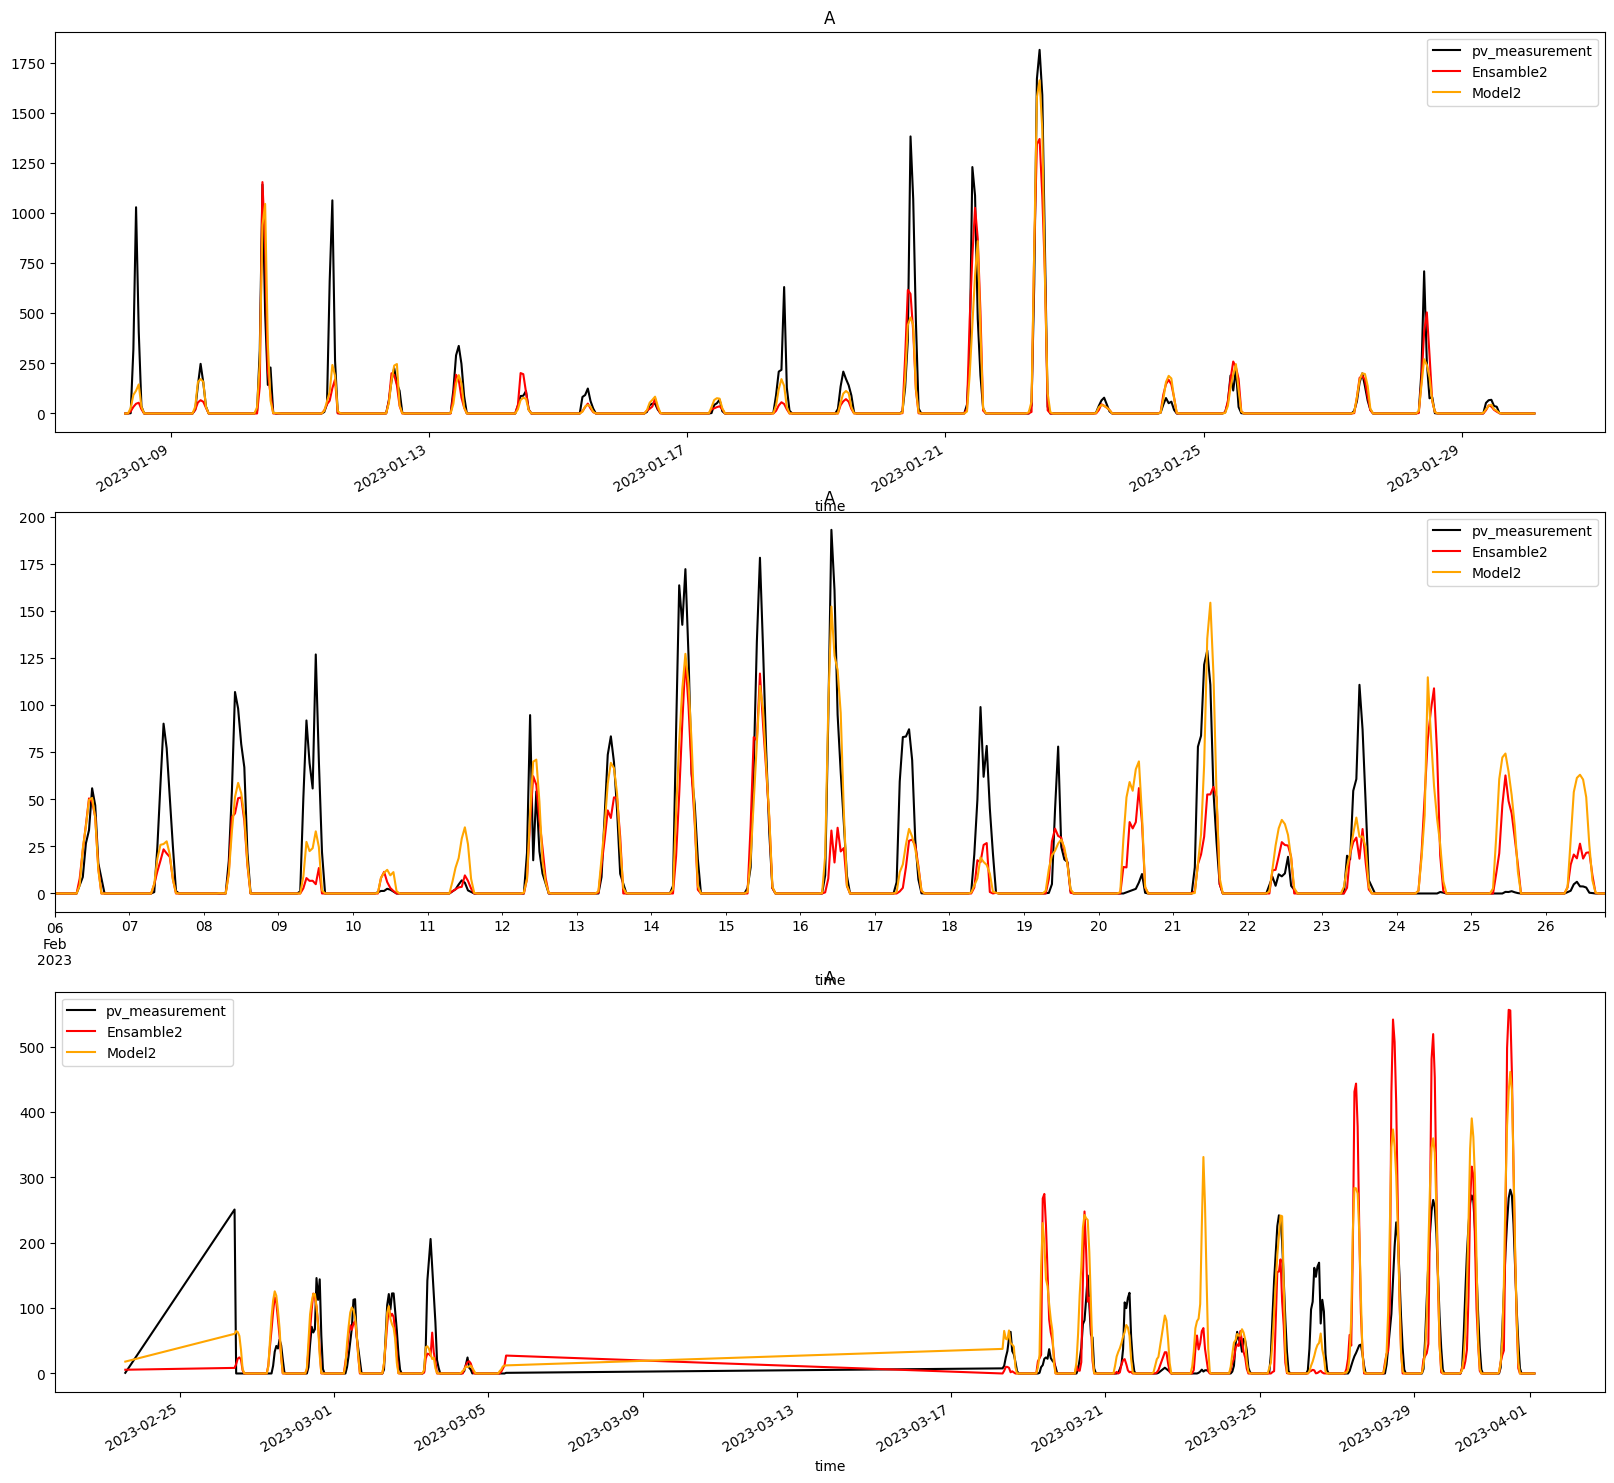

In [36]:
fig, axs = plt.subplots(3, 1, figsize=(20, 20), sharex=False)


comparisonA.iloc[1000:1500][['time', 'pv_measurement']].set_index('time').plot(ax=axs[0], title='A', color='black')
comparisonA.iloc[1000:1500][['time', "Ensamble2"]].set_index('time').plot(ax=axs[0], title='A', color='red')
comparisonA.iloc[1000:1500][['time', "Model2"]].set_index('time').plot(ax=axs[0], title='A', color='orange')
comparisonB.iloc[1000:1500][['time', 'pv_measurement']].set_index('time').plot(ax=axs[1], title='A', color='black')
comparisonB.iloc[1000:1500][['time', "Ensamble2"]].set_index('time').plot(ax=axs[1], title='A', color='red')
comparisonB.iloc[1000:1500][['time', "Model2"]].set_index('time').plot(ax=axs[1], title='A', color='orange')
comparisonC.iloc[1000:1500][['time', 'pv_measurement']].set_index('time').plot(ax=axs[2], title='A', color='black')
comparisonC.iloc[1000:1500][['time', "Ensamble2"]].set_index('time').plot(ax=axs[2], title='A', color='red')
comparisonC.iloc[1000:1500][['time', "Model2"]].set_index('time').plot(ax=axs[2], title='A', color='orange')

## 4.2 Feature Importance

One of our earlier versions we used feature importance to look at how each feature affected the predictions of our model. Here is the model with the results.
Note: the importance of the elevation feature is most likely that the model uses this to determine which location the sample is from, not that elevation is an actual important feature.

In [37]:

#Read dataset
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')
X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')
X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

#add location to each sample
train_a["location"] = "A"
train_b["location"] = "B"
train_c["location"] = "C"
X_train_estimated_a["location"] = "A"
X_train_estimated_b["location"] = "B"
X_train_estimated_c["location"] = "C"
X_train_observed_a["location"] = "A"
X_train_observed_b["location"] = "B"
X_train_observed_c["location"] = "C"

#remove extra minute 00 sample
X_train_observed_a = X_train_observed_a.iloc[:-1,:]
X_train_observed_b = X_train_observed_b.iloc[:-1,:]
X_train_observed_c = X_train_observed_c.iloc[:-1,:]

#add date_calc column same as date_forecast column to observed data
X_train_observed_a.insert(0, "date_calc", X_train_observed_a["date_forecast"])
X_train_observed_b.insert(0, "date_calc", X_train_observed_b["date_forecast"])
X_train_observed_c.insert(0, "date_calc", X_train_observed_c["date_forecast"])

#concat all the samples and remove date_calc column
X_train_raw = pd.concat([X_train_observed_a,
                     X_train_observed_b,
                     X_train_observed_c,
                     X_train_estimated_a,
                     X_train_estimated_b,
                     X_train_estimated_c])

#feature indicating time between date_calc and date_forecast
X_train_raw["calc_time"] =(X_train_raw["date_forecast"] - X_train_raw["date_calc"]).astype('timedelta64[s]')

#fill nans
X_train_raw["snow_density:kgm3"] = X_train_raw["snow_density:kgm3"].apply(
    lambda a : np.isnan(a)
    ).map({True: 0, False: 1})
X_train_raw["ceiling_height_agl:m"] = X_train_raw["ceiling_height_agl:m"].apply(
    lambda a : -1000 if np.isnan(a) else a
)
X_train_raw["cloud_base_agl:m"] = X_train_raw["ceiling_height_agl:m"].apply(
    lambda a : -1000 if np.isnan(a) else a
)

#create seperate dataframes for measurments at minute 00, 15, 30 and 45
X_train00 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 0)].reset_index().iloc[:,1:]
X_train15 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 15)].reset_index().iloc[:,1:]
X_train30 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 30)].reset_index().iloc[:,1:]
X_train45 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 45)].reset_index().iloc[:,1:]

#remove redundant data
X_train15 = X_train15.iloc[:,2:-2]
X_train30 = X_train30.iloc[:,2:-2]
X_train45 = X_train45.iloc[:,2:-2]

#join observations into single sample
X_train = X_train00.join(X_train15, lsuffix="_00", rsuffix="_15").join(X_train30.join(X_train45, lsuffix="_30", rsuffix="_45"))

#rename column for merging with targets
X_train = X_train.rename(columns={"date_forecast" : "time"})

#concat target values and drop NaN values
targets = pd.concat([train_a,
                     train_b,
                     train_c]).dropna()

#merge weatherfeatures with corresponding target pv measurement
dataset = pd.merge(X_train, targets, how="right", on=["time", "location"])

#shuffle dataset
dataset = dataset.sample(frac=1, random_state=43).reset_index().iloc[:,1:]

#split into features and targets
datasetX = dataset.iloc[:, :-1]
datasetX = datasetX.drop('calc_time', axis=1)
datasetY = dataset.iloc[:, -1:]

#add day_of_year and hour feature columns
datasetX["day"] = datasetX["time"].dt.day_of_year
datasetX["hour"] = datasetX["time"].dt.hour

#get indexes of samples in the months of the test dataset
indexMayJuneJuly = datasetX["time"].apply(lambda time : time.month in [5, 6, 7])

#OHE encoding for catagorical feature "location"
datasetX["location_A"] = datasetX["location"].apply(lambda a : a == "A").map({True: 1, False: 0})
datasetX["location_B"] = datasetX["location"].apply(lambda a : a == "B").map({True: 1, False: 0})
datasetX["location_C"] = datasetX["location"].apply(lambda a : a == "C").map({True: 1, False: 0})

datasetX = datasetX.drop("location", axis=1)

#move datecalc column
#date_calc_column = datasetX.pop("date_calc")
#datasetX.insert(183, "is_not_calculated", date_calc_column) #!constant 183 can be source of bugs

#fix nans for some reason???
#datasetX["is_not_calculated"] = datasetX["is_not_calculated"].fillna(method="ffill")

#map location labels to numbers
#datasetX["location"] = datasetX["location"].map({"A": 0, "B": 1, "C": 2})

#drop time and date_calc columns
datasetX = datasetX.iloc[:,2:]

#calculate mean and std for normalizing data, values should also be used for normalizing test data
dataMean = datasetX.mean()
dataStd = datasetX.std()

#normalize data
datasetX.iloc[:,:-4] = ((datasetX.iloc[:,:-4]-dataMean[:-4])/dataStd[:-4]).fillna(value=0)


#partition into training and evalset
trainsetX = datasetX.iloc[:85000,:]
trainsetY = datasetY.iloc[:85000,:]
trainsetIndexMayJuneJuly = indexMayJuneJuly[:85000]
evalsetX = datasetX.iloc[85000:,:]
evalsetY = datasetY.iloc[85000:,:]
evalsetIndexMayJuneJuly = indexMayJuneJuly[85000:]

display(datasetX)




# Model
model = tf.keras.models.Sequential([
    #tf.keras.layers.GaussianNoise(stddev=0.1, seed=42),
    tf.keras.layers.Dense(150, activation="relu"),
    tf.keras.layers.Dense(120, activation="relu"),
    tf.keras.layers.Dense(90, activation="relu"),
    tf.keras.layers.Dense(60, activation="relu"),
    tf.keras.layers.Dense(1, activation="relu"),
])

model.compile(
    optimizer=tf.keras.optimizers.legacy.Adadelta(learning_rate=1, 
                                                        #weight_decay=0.0001
                                                        ),
    loss="mean_absolute_error"
)

history = model.fit(x = trainsetX,
                    y= trainsetY,
                    batch_size = 1000,
                    epochs=100,
                    validation_data=(evalsetX,
                                     evalsetY
                                     ),
                    #sample_weight=trainsetIndexMayJuneJuly.map({True: 2, False: 1})
                    #sample_weight=trainsetX[trainsetX["location_A"].apply(lambda a : a == 1)].map({True: 1, False: 1})
                    )



# Feature importance evaluation
actualLoss = model.evaluate(evalsetX, evalsetY)

losses = np.zeros(len(evalsetX.columns))

for i in range(45):
    dummyX = evalsetX.copy()
    dummyX.iloc[:,i] = dummyX.iloc[:,i].sample(frac=1)
    dummyX.iloc[:,i+45] = dummyX.iloc[:,i+45].sample(frac=1)
    dummyX.iloc[:,i+90] = dummyX.iloc[:,i+90].sample(frac=1)
    dummyX.iloc[:,i+135] = dummyX.iloc[:,i+135].sample(frac=1)
    losses[i] = model.evaluate(dummyX, evalsetY)


lossDiff = losses - actualLoss

lossDiffFrame = pd.DataFrame({
    'feature': pd.Series(evalsetX.columns),
    'loss Difference': lossDiff})
display(lossDiffFrame.iloc[:45,:])

absolute_humidity_2m:gm3_00  air_density_2m:kgm3_00  \
0                         1.761765               -0.585518   
1                         2.056473               -1.514269   
2                        -1.737899                3.539239   
3                         0.693446               -1.049894   
4                        -0.043325               -0.039193   
...                            ...                     ...   
93019                     1.761765               -0.940630   
93020                     1.430217               -1.077211   
93021                    -0.780097                1.381254   
93022                     0.435576                0.261286   
93023                    -1.074805                0.343236   

       ceiling_height_agl:m_00  clear_sky_energy_1h:J_00  clear_sky_rad:W_00  \
0                    -0.372920                 -0.627834           -0.626244   
1                    -1.083697                 -0.511048           -0.405245   
2                    -0.412686                 -0.626565           -0.610052   
3                    -1.083697                  0.532847            0.340902   
4                    -0.325236                 -0.627834           -0.626244   
...                        ...                       ...                 ...   
93019                -0.343415                 -0.609817           -0.541345   
93020                -0.203188                 -0.353779           -0.143984   
93021                -1.083697                 -0.627834           -0.626244   
93022                -1.083697                 -0.627834           -0.626244   
93023                -0.125634                 -0.570831           -0.519902   

       cloud_base_agl:m_00  dew_or_rime:idx_00  dew_point_2m:K_00  \
0                -0.372920           -0.028554           1.486874   
1                -1.083697           -0.028554           1.691712   
2                -0.412686           -0.028554          -2.653814   
3                -1.083697           -0.028554           0.828460   
4                -0.325236           -0.028554           0.140786   
...                    ...                 ...                ...   
93019            -0.343415           -0.028554           1.486874   
93020            -0.203188           -0.028554           1.296667   
93021            -1.083697           -0.028554          -0.722471   
93022            -1.083697           -0.028554           0.565096   
93023            -0.125634           -0.028554          -1.161413   

       diffuse_rad:W_00  diffuse_rad_1h:J_00  direct_rad:W_00  \
0             -0.651235            -0.658524        -0.444504   
1             -0.204391            -0.371468        -0.170922   
2             -0.590227            -0.627996        -0.444504   
3              0.224316             0.276981         1.045587   
4             -0.651235            -0.658524        -0.444504   
...                 ...                  ...              ...   
93019         -0.585281            -0.625446        -0.444504   
93020         -0.326408            -0.456205        -0.443619   
93021         -0.651235            -0.658524        -0.444504   
93022         -0.651235            -0.658524        -0.444504   
93023         -0.474806            -0.565454        -0.444504   

       direct_rad_1h:J_00  effective_cloud_cover:p_00  elevation:m_00  \
0               -0.449899                    0.941265       -0.685740   
1               -0.311598                   -1.900810        1.599325   
2               -0.449899                   -0.359926       -0.685740   
3                1.355175                   -1.889396        1.599325   
4               -0.449899                    0.941265       -0.558792   
...                   ...                         ...             ...   
93019           -0.449899                    0.941265       -0.558792   
93020           -0.449516                    0.941265        1.599325   
93021           -0.449899         

Epoch 1/100
85/85 [==============================] - 1s 5ms/step - loss: 210.9295 - val_loss: 188.6842
Epoch 2/100
85/85 [==============================] - 0s 4ms/step - loss: 165.1124 - val_loss: 115.7412
Epoch 3/100
85/85 [==============================] - 0s 4ms/step - loss: 133.2947 - val_loss: 127.6151
Epoch 4/100
85/85 [==============================] - 0s 5ms/step - loss: 114.8169 - val_loss: 95.2059
Epoch 5/100
85/85 [==============================] - 0s 6ms/step - loss: 103.8366 - val_loss: 92.0676
Epoch 6/100
85/85 [==============================] - 1s 6ms/step - loss: 97.6805 - val_loss: 89.9681
Epoch 7/100
85/85 [==============================] - 1s 8ms/step - loss: 95.9488 - val_loss: 89.2694
Epoch 8/100
85/85 [==============================] - 1s 9ms/step - loss: 92.5340 - val_loss: 87.8771
Epoch 9/100
85/85 [==============================] - 0s 6ms/step - loss: 89.8421 - val_loss: 97.4980
Epoch 10/100
85/85 [==============================] - 0s 5ms/step - loss: 88.9052 -

feature  loss Difference
0         absolute_humidity_2m:gm3_00         3.709946
1              air_density_2m:kgm3_00         3.724312
2             ceiling_height_agl:m_00         1.850647
3            clear_sky_energy_1h:J_00         9.238754
4                  clear_sky_rad:W_00         8.007401
5                 cloud_base_agl:m_00         2.303185
6                  dew_or_rime:idx_00         0.901894
7                   dew_point_2m:K_00         5.868462
8                    diffuse_rad:W_00        10.335526
9                 diffuse_rad_1h:J_00         4.835968
10                    direct_rad:W_00        21.253296
11                 direct_rad_1h:J_00        16.729019
12         effective_cloud_cover:p_00        11.021736
13                     elevation:m_00        36.180229
14               fresh_snow_12h:cm_00         0.498131
15                fresh_snow_1h:cm_00         0.009148
16               fresh_snow_24h:cm_00         1.924858
17                fresh_snow_3h:cm_00         0.761024
18                fresh_snow_6h:cm_00         1.439209
19                      is_day:idx_00         8.525711
20                is_in_shadow:idx_00         5.067299
21                msl_pressure:hPa_00         1.430305
22                  precip_5min:mm_00         1.223518
23            precip_type_5min:idx_00         4.893387
24               pressure_100m:hPa_00         2.320862
25                pressure_50m:hPa_00         2.284393
26                     prob_rime:p_00         0.446960
27                 rain_water:kgm2_00         2.369255
28     relative_humidity_1000hPa:p_00         5.282761
29                sfc_pressure:hPa_00         1.791237
30               snow_density:kgm3_00         1.296028
31                   snow_depth:cm_00         1.143127
32                  snow_drift:idx_00        -0.000015
33              snow_melt_10min:mm_00         0.502151
34                 snow_water:kgm2_00         6.968513
35                   sun_azimuth:d_00        14.652649
36                 sun_elevation:d_00         7.925453
37  super_cooled_liquid_water:kgm2_00         4.165222
38                     t_1000hPa:K_00        12.737099
39             total_cloud_cover:p_00         7.123924
40                    visibility:m_00         8.019218
41               wind_speed_10m:ms_00         4.300583
42             wind_speed_u_10m:ms_00         5.910683
43             wind_speed_v_10m:ms_00         5.142387
44         wind_speed_w_1000hPa:ms_00         0.109177

### Partial Dependence Plots (PDP)

In [41]:

#Read dataset
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')
X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')
X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

#add location to each sample
train_a["location"] = "A"
train_b["location"] = "B"
train_c["location"] = "C"
X_train_estimated_a["location"] = "A"
X_train_estimated_b["location"] = "B"
X_train_estimated_c["location"] = "C"
X_train_observed_a["location"] = "A"
X_train_observed_b["location"] = "B"
X_train_observed_c["location"] = "C"

train_b = pd.concat([train_b[:18690], train_b[20142:]])
train_b["rolling"] = train_b["pv_measurement"].rolling(4).mean()
train_b["keep"] = train_b["pv_measurement"] - train_b["rolling"] != 0 + train_b["pv_measurement"].apply(lambda a: a==0)
train_b = train_b[train_b["keep"]]
train_b = train_b.iloc[:,:3]

#remove extra minute 00 sample
X_train_observed_a = X_train_observed_a.iloc[:-1,:]
X_train_observed_b = X_train_observed_b.iloc[:-1,:]
X_train_observed_c = X_train_observed_c.iloc[:-1,:]

#add date_calc column same as date_forecast column to observed data
X_train_observed_a.insert(0, "date_calc", X_train_observed_a["date_forecast"])
X_train_observed_b.insert(0, "date_calc", X_train_observed_b["date_forecast"])
X_train_observed_c.insert(0, "date_calc", X_train_observed_c["date_forecast"])

#concat all the samples and remove date_calc column
X_train_raw = pd.concat([X_train_observed_a,
                     X_train_observed_b,
                     X_train_observed_c,
                     X_train_estimated_a,
                     X_train_estimated_b,
                     X_train_estimated_c])

#feature indicating time between date_calc and date_forecast
X_train_raw["calc_time"] =(X_train_raw["date_forecast"] - X_train_raw["date_calc"]).astype('timedelta64[s]')

#fill nans
X_train_raw["snow_density:kgm3"] = X_train_raw["snow_density:kgm3"].apply(
    lambda a : np.isnan(a)
    ).map({True: 0, False: 1})
X_train_raw["ceiling_height_agl:m"] = X_train_raw["ceiling_height_agl:m"].apply(
    lambda a : -1000 if np.isnan(a) else a
)
X_train_raw["cloud_base_agl:m"] = X_train_raw["ceiling_height_agl:m"].apply(
    lambda a : -1000 if np.isnan(a) else a
)

#create seperate dataframes for measurments at minute 00, 15, 30 and 45
X_train00 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 0)].reset_index().iloc[:,1:]
X_train15 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 15)].reset_index().iloc[:,1:]
X_train30 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 30)].reset_index().iloc[:,1:]
X_train45 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 45)].reset_index().iloc[:,1:]

#remove redundant data
X_train15 = X_train15.iloc[:,2:-2]
X_train30 = X_train30.iloc[:,2:-2]
X_train45 = X_train45.iloc[:,2:-2]

#join observations into single sample
X_train = X_train00.join(X_train15, lsuffix="_00", rsuffix="_15").join(X_train30.join(X_train45, lsuffix="_30", rsuffix="_45"))

#rename column for merging with targets
X_train = X_train.rename(columns={"date_forecast" : "time"})

#concat target values and drop NaN values
targets = pd.concat([train_a,
                     train_b,
                     train_c]).dropna()

#merge weatherfeatures with corresponding target pv measurement
dataset = pd.merge(X_train, targets, how="inner", on=["time", "location"])

#shuffle dataset
dataset = dataset.sample(frac=1, random_state=43).reset_index().iloc[:,1:]

#split into features and targets
datasetX = dataset.iloc[:, :-1]
datasetY = dataset.iloc[:, -1:]

#add day_of_year and hour feature columns
datasetX["day"] = datasetX["time"].dt.day_of_year
datasetX["hour"] = datasetX["time"].dt.hour

#get indexes of samples in the months of the test dataset
indexMayJuneJuly = datasetX["time"].apply(lambda time : time.month in [5, 6, 7])

#OHE encoding for catagorical feature "location"
datasetX["location_A"] = datasetX["location"].apply(lambda a : a == "A").map({True: 1, False: 0})
datasetX["location_B"] = datasetX["location"].apply(lambda a : a == "B").map({True: 1, False: 0})
datasetX["location_C"] = datasetX["location"].apply(lambda a : a == "C").map({True: 1, False: 0})

datasetX = datasetX.drop("location", axis=1)

#move datecalc column
#date_calc_column = datasetX.pop("date_calc")
#datasetX.insert(183, "is_not_calculated", date_calc_column) #!constant 183 can be source of bugs

#fix nans for some reason???
#datasetX["is_not_calculated"] = datasetX["is_not_calculated"].fillna(method="ffill")

#map location labels to numbers
#datasetX["location"] = datasetX["location"].map({"A": 0, "B": 1, "C": 2})

#drop time and date_calc columns
datasetX = datasetX.iloc[:,2:]

#calculate mean and std for normalizing data, values should also be used for normalizing test data
dataMean = datasetX.mean()
dataStd = datasetX.std()

#normalize data
datasetX.iloc[:,:-4] = ((datasetX.iloc[:,:-4]-dataMean[:-4])/dataStd[:-4]).fillna(value=0)


#partition into training and evalset
trainsetX = datasetX.iloc[:,:]
trainsetY = datasetY.iloc[:,:]
trainsetIndexMayJuneJuly = indexMayJuneJuly[:]
evalsetX = datasetX.iloc[85000:,:]
evalsetY = datasetY.iloc[85000:,:]
evalsetIndexMayJuneJuly = indexMayJuneJuly[85000:]



is_estimated = trainsetX["calc_time"].apply(lambda a : a != trainsetX["calc_time"].min())


tf.keras.utils.set_random_seed(81)#Our group number as the seed to make the results reproducible

numModels = 20

models = []

i = 0
while(i < numModels):
  if(i < 10):
    models.append(tf.keras.models.Sequential([
          tf.keras.layers.Dense(100, activation="tanh"),
          tf.keras.layers.Dense(100, activation="relu"),
          tf.keras.layers.Dense(1, activation="relu"),
      ]))
  else:
    models.append(tf.keras.models.Sequential([
          tf.keras.layers.Dense(150, activation="tanh"),
          tf.keras.layers.Dense(120, activation="relu"),
          tf.keras.layers.Dense(90, activation="relu"),
          tf.keras.layers.Dense(60, activation="relu"),
          tf.keras.layers.Dense(1, activation="relu"),
      ]))
  models[i].compile(
      optimizer=tf.keras.optimizers.experimental.Adadelta(learning_rate=1
                                                          ),
      loss="mean_absolute_error"
  )

  history = models[i].fit(x = trainsetX.sample(frac=0.5 if i < 10 else 1, random_state=i),
                      y= trainsetY.sample(frac=0.5 if i < 10 else 1, random_state=i),
                      batch_size = 1000,
                      epochs=20,
                      verbose=0,
                      sample_weight=is_estimated.map({True: 3, False: 1}).sample(frac=0.5 if i < 10 else 1, random_state=i)
                  )

  #retry if model is nonsensical
  loss = models[i].evaluate(evalsetX, evalsetY)
  if(loss > 200):
      del models[i]
      continue

  print(i, " complete")
  i+=1




X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')

X_test_estimated_a["location"] = "A"
X_test_estimated_b["location"] = "B"
X_test_estimated_c["location"] = "C"

X_test_raw = pd.concat([
                     X_test_estimated_a,
                     X_test_estimated_b,
                     X_test_estimated_c])

#feature indicating time between date_calc and date_forecast
X_test_raw["calc_time"] =(X_test_raw["date_forecast"] - X_test_raw["date_calc"]).astype('timedelta64[s]')

#fill nans
X_test_raw["snow_density:kgm3"] = X_test_raw["snow_density:kgm3"].apply(
    lambda a : np.isnan(a)
    ).map({True: 0, False: 1})
X_test_raw["ceiling_height_agl:m"] = X_test_raw["ceiling_height_agl:m"].apply(
    lambda a : -1000 if np.isnan(a) else a
)
X_test_raw["cloud_base_agl:m"] = X_test_raw["ceiling_height_agl:m"].apply(
    lambda a : -1000 if np.isnan(a) else a
)

#create seperate dataframes for measurments at minute 00, 15, 30 and 45
X_test00 = X_test_raw[X_test_raw["date_forecast"].apply(lambda time: time.minute == 0)].reset_index().iloc[:,1:]
X_test15 = X_test_raw[X_test_raw["date_forecast"].apply(lambda time: time.minute == 15)].reset_index().iloc[:,1:]
X_test30 = X_test_raw[X_test_raw["date_forecast"].apply(lambda time: time.minute == 30)].reset_index().iloc[:,1:]
X_test45 = X_test_raw[X_test_raw["date_forecast"].apply(lambda time: time.minute == 45)].reset_index().iloc[:,1:]

#remove redundant data
X_test15 = X_test15.iloc[:,2:-2]
X_test30 = X_test30.iloc[:,2:-2]
X_test45 = X_test45.iloc[:,2:-2]

#join observations into single sample
X_test_estimated = X_test00.join(X_test15, lsuffix="_00", rsuffix="_15").join(X_test30.join(X_test45, lsuffix="_30", rsuffix="_45"))


X_test_estimated = X_test_estimated.rename(columns={"date_forecast" : "time"})

parse_dates = ['time']
X_test_targets = pd.read_csv("test.csv", parse_dates=parse_dates)

X_test = pd.merge(X_test_estimated, X_test_targets, on=["time", "location"], how="right").iloc[:,:-2]


X_test["day"] = X_test["time"].dt.day_of_year
X_test["hour"] = X_test["time"].dt.hour

X_test["location_A"] = X_test["location"].apply(lambda a : a == "A").map({True: 1, False: 0})
X_test["location_B"] = X_test["location"].apply(lambda a : a == "B").map({True: 1, False: 0})
X_test["location_C"] = X_test["location"].apply(lambda a : a == "C").map({True: 1, False: 0})

X_test = X_test.drop("location", axis=1)

X_test = X_test.iloc[:,2:]


X_test.iloc[:,:-4] = ((X_test.iloc[:,:-4]-dataMean[:-4])/dataStd[:-4]).fillna(value=0)



def models_predict(models, X):
    preds = X.iloc[:,1:2]

    for i in range(len(models)):
        preds[str(i)] = models[i].predict(X)

    preds = preds.iloc[:,1:]
    preds["final"] = preds.mean(axis=1)
    return preds["final"]


test_preds = pd.read_csv("sample_submission.csv")
test_preds["prediction"] = models_predict(models, X_test)
display(test_preds)

X_test["prediction"] = test_preds["prediction"]
display(X_test)

/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/606775650.py:125: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  datasetX.iloc[:,:-4] = ((datasetX.iloc[:,:-4]-dataMean[:-4])/dataStd[:-4]).fillna(value=0)


119/119 [==============================] - 0s 534us/step - loss: 84.0950


0  complete
119/119 [==============================] - 0s 496us/step - loss: 81.5565


1  complete
119/119 [==============================] - 0s 502us/step - loss: 82.2307


2  complete
119/119 [==============================] - 0s 320us/step - loss: 82.8304


3  complete
119/119 [==============================] - 0s 331us/step - loss: 81.5331


4  complete
119/119 [==============================] - 0s 325us/step - loss: 80.8776


5  complete
119/119 [==============================] - 0s 485us/step - loss: 85.0809


6  complete
119/119 [==============================] - 0s 322us/step - loss: 82.1032


7  complete
119/119 [==============================] - 0s 329us/step - loss: 81.1837


8  complete
119/119 [==============================] - 0s 338us/step - loss: 80.1494


9  complete
119/119 [==============================] - 0s 608us/step - loss: 75.0701


10  complete
119/119 [==============================] - 0s 364us/step - loss: 74.6750


11  complete
119/119 [==============================] - 0s 617us/step - loss: 75.6139


12  complete
119/119 [==============================] - 0s 658us/step - loss: 75.1706


13  complete
119/119 [==============================] - 0s 566us/step - loss: 76.4493


14  complete
119/119 [==============================] - 0s 370us/step - loss: 76.0361


15  complete
119/119 [==============================] - 0s 374us/step - loss: 74.9992


16  complete
119/119 [==============================] - 0s 667us/step - loss: 80.3174


17  complete
119/119 [==============================] - 0s 372us/step - loss: 74.7649


18  complete
119/119 [==============================] - 0s 375us/step - loss: 298.2436


119/119 [==============================] - 0s 375us/step - loss: 298.2436


119/119 [==============================] - 0s 597us/step - loss: 74.0687
19  complete
68/68 [==============================] - 0s 320us/step


/var/folders/vq/1r62mkln1rqdv9t7tt0c7m8c0000gn/T/ipykernel_29662/606775650.py:251: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  X_test.iloc[:,:-4] = ((X_test.iloc[:,:-4]-dataMean[:-4])/dataStd[:-4]).fillna(value=0)


68/68 [==============================] - 0s 385us/step


id  prediction
0        0    0.000000
1        1    0.000000
2        2    0.000000
3        3   39.916588
4        4  386.869568
...    ...         ...
2155  2155   48.221687
2156  2156   23.385210
2157  2157    0.596321
2158  2158    0.365592
2159  2159    0.013213

[2160 rows x 2 columns]

absolute_humidity_2m:gm3_00  air_density_2m:kgm3_00  \
0                       -0.581187                0.822366   
1                       -0.618246                0.849555   
2                       -0.655304                0.767986   
3                       -0.692363                0.713602   
4                       -0.766481                0.713602   
...                           ...                     ...   
2155                     0.864104               -1.624782   
2156                     0.938221               -1.543210   
2157                     1.049398               -1.461638   
2158                     1.123515               -1.352877   
2159                     1.123515               -1.325686   

      ceiling_height_agl:m_00  clear_sky_energy_1h:J_00  clear_sky_rad:W_00  \
0                   -0.382900                 -0.619627           -0.618049   
1                   -1.085710                 -0.619627           -0.618049   
2                   -0.173677                 -0.619627           -0.618049   
3                    0.129317                 -0.619627           -0.618049   
4                    0.135379                 -0.546506           -0.429154   
...                       ...                       ...                 ...   
2155                 0.579692                  0.133114           -0.103201   
2156                 0.541699                 -0.289848           -0.442333   
2157                 0.198506                 -0.531551           -0.596523   
2158                 0.015666                 -0.617941           -0.618049   
2159                 0.018679                 -0.619627           -0.618049   

      cloud_base_agl:m_00  dew_or_rime:idx_00  dew_point_2m:K_00  \
0               -0.382900           -0.026723          -0.499357   
1               -1.085710           -0.026723          -0.513980   
2               -0.173677           -0.026723          -0.572466   
3                0.129317           -0.026723          -0.630958   
4                0.135379           -0.026723          -0.704067   
...                   ...                 ...                ...   
2155             0.579692           -0.026723           0.948210   
2156             0.541699           -0.026723           0.992074   
2157             0.198506           -0.026723           1.035942   
2158             0.015666           -0.026723           1.094429   
2159             0.018679           -0.026723           1.079806   

      diffuse_rad:W_00  diffuse_rad_1h:J_00  direct_rad:W_00  \
0            -0.644227            -0.651409        -0.440973   
1            -0.644227            -0.651409        -0.440973   
2            -0.644227            -0.651409        -0.440973   
3            -0.644227            -0.651409        -0.440973   
4            -0.124352            -0.388337        -0.343506   
...                ...                  ...              ...   
2155          0.039558             0.275186        -0.297430   
2156         -0.318063            -0.140474        -0.388695   
2157         -0.561444            -0.444488        -0.440973   
2158         -0.644227            -0.609705        -0.440973   
2159         -0.644227            -0.651409        -0.440973   

      direct_rad_1h:J_00  effective_cloud_cover:p_00  elevation:m_00  \
0              -0.446313                    0.393971       -0.700896   
1              -0.446313                   -0.067391       -0.700896   
2              -0.446313                    0.784135       -0.700896   
3              -0.446313                    0.231640       -0.700896   
4              -0.397041                   -0.235418       -0.700896   
...                  ...                         ...             ...   
2155           -0.303928                    0.647435        1.549095   
2156           -0.346992                    0.499344        1.549095   
2157           -0.419715                    0.055069        1.549095   
2158           -0.

KeyError: 'prediction'

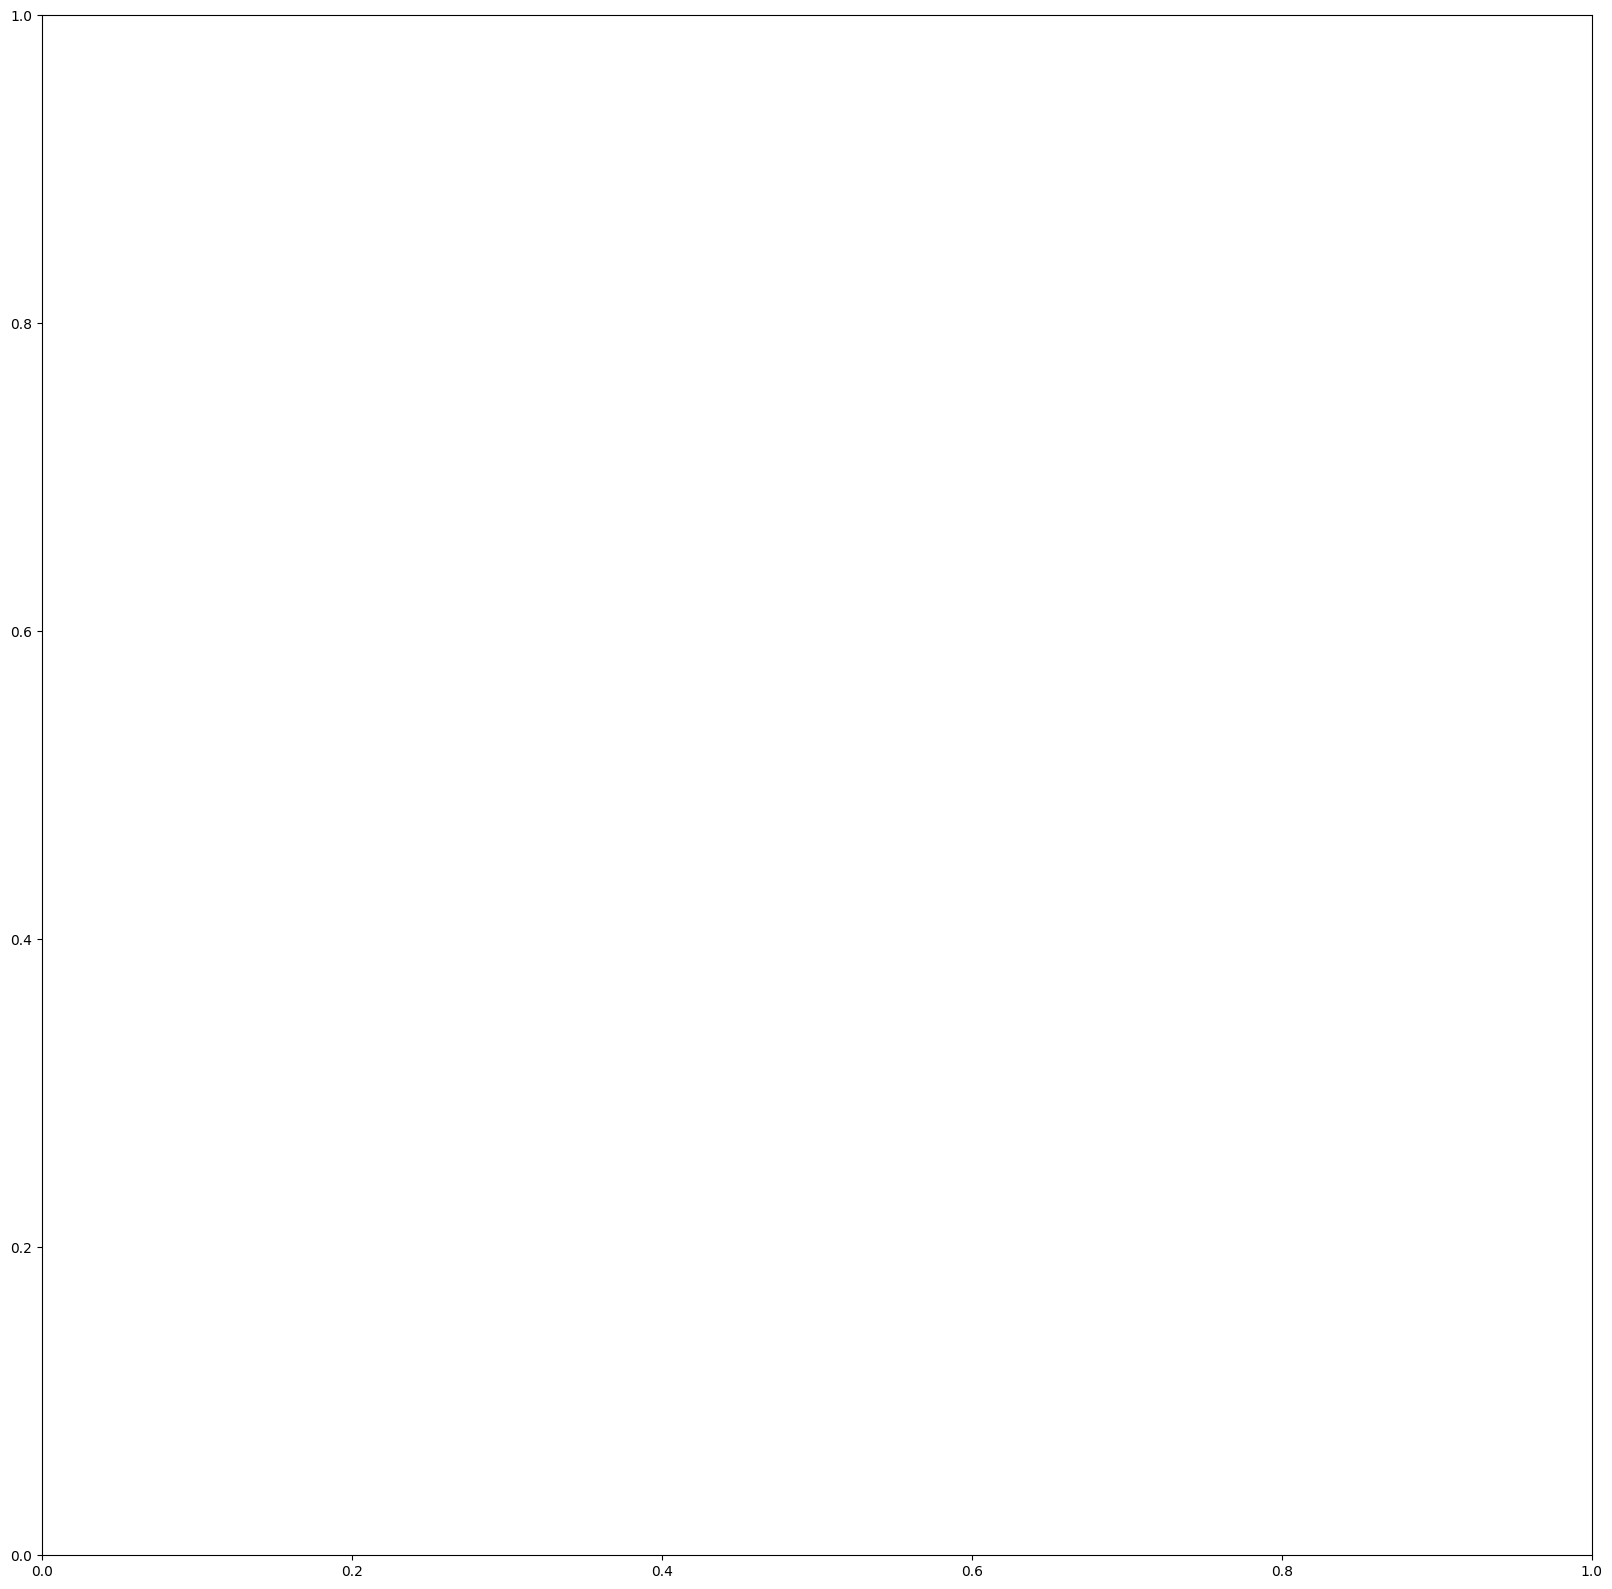

In [40]:
fig, axs = plt.subplots(1, 1, figsize=(20, 20), sharex=True)
axs.plot(X_test['sun_elevation:d_00'], X_test['prediction'])
axs.set_title('Dataset A')
plt.show()